# MOOG synth spectra

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pymc3 as pm
import os
from astropy.io import fits
from scipy.interpolate import interp1d

import synth_spectra

In [366]:
import importlib
import synth_spectra
importlib.reload(synth_spectra)

<module 'synth_spectra' from '/home/hannakasperer/Dissertation-/MOOG_SYN/synth_spectra.py'>

In [367]:
from synth_spectra import create_synth
from synth_spectra import plot_synth
from synth_spectra import obs_spectrum

from synth_spectra import rv_shift
from synth_spectra import create_synth_rv

### Mg abund from EW measurements

In [15]:
path = '/home/hannakasperer/Dissertation-/Sample/main_sample_ab.csv'
sample = pd.read_csv(path,sep=',') 
sample[["star","MgI_rel_sun"]]

star  MgI_rel_sun
0      55Cnc_SINGLEHR11_ESPRESSO_2022        0.379
1              CoRoT-07_ESPRESSO_2024       -0.019
2                K2-106_ESPRESSO_2024        0.074
3                K2-314_ESPRESSO_2024        0.267
4                K2-229_ESPRESSO_2024       -0.065
5   HD136352_SINGLEHR11_ESPRESSO_2022       -0.133
6              HD137496_ESPRESSO_2024        0.008
7               TOI-402_ESPRESSO_2024        0.106
8               HD20329_ESPRESSO_2024        0.135
9              HD213885_ESPRESSO_2024       -0.019
10               HD3167_ESPRESSO_2024        0.014
11              HD80653_ESPRESSO_2024        0.308
12   TOI-469_SINGLEHR11_ESPRESSO_2022        0.258
13               K2-111_ESPRESSO_2024       -0.201
14               K2-131_ESPRESSO_2024       -0.191
15               K2-265_ESPRESSO_2024        0.076
16             HD285181_ESPRESSO_2024        0.080
17                K2-38_ESPRESSO_2024        0.328
18   TOI-238_SINGLEHR11_ESPRESSO_2022       -0.124
19              TOI-561_ESPRESSO_2024       -0.178
20              WASP-47_ESPRESSO_2024        0.415

In [101]:
sample[["star","teff","logg","feh","planet_name"]]

star  teff   logg    feh       planet_name
0      55Cnc_SINGLEHR11_ESPRESSO_2022  5310  4.211  0.299          55 Cnc e
1              CoRoT-07_ESPRESSO_2024  5269  4.381  0.044         CoRoT-7 b
2                K2-106_ESPRESSO_2024  5505  4.338  0.080  EPIC 220674823 b
3                K2-314_ESPRESSO_2024  5555  4.023  0.163  EPIC 249893012 b
4                K2-229_ESPRESSO_2024  5126  4.336 -0.088          K2-229 b
5   HD136352_SINGLEHR11_ESPRESSO_2022  5652  4.371 -0.353       HD 136352 b
6              HD137496_ESPRESSO_2024  5797  4.093 -0.034       HD 137496 b
7               TOI-402_ESPRESSO_2024  5067  4.201  0.054        HD 15337 b
8               HD20329_ESPRESSO_2024  5574  4.285 -0.106        HD 20329 b
9              HD213885_ESPRESSO_2024  5906  4.427 -0.005       HD 213885 b
10               HD3167_ESPRESSO_2024  5228  4.285 -0.019         HD 3167 b
11              HD80653_ESPRESSO_2024  5951  4.330  0.344        HD 80653 b
12   TOI-469_SINGLEHR11_ESPRESSO_2022  5289  4.237  0.239       HIP 29442 c
13               K2-111_ESPRESSO_2024  5791  4.346 -0.477          K2-111 b
14               K2-131_ESPRESSO_2024  5043  4.272 -0.157          K2-131 b
15               K2-265_ESPRESSO_2024  5427  4.345  0.049          K2-265 b
16             HD285181_ESPRESSO_2024  5554  4.436  0.107          K2-291 b
17                K2-38_ESPRESSO_2024  5726  4.266  0.257           K2-38 b
18   TOI-238_SINGLEHR11_ESPRESSO_2022  4923  4.269 -0.156         TOI-238 b
19              TOI-561_ESPRESSO_2024  5318  4.390 -0.404         TOI-561 b
20              WASP-47_ESPRESSO_2024  5552  4.296  0.404         WASP-47 e

### check for the step

In [16]:
hdul = fits.open("spectra/K2-229_ESPRESSO_2025.fits")
header = hdul[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =               824926                                                  
CDELT1  =                0.005                                                  
CRVAL1  =    3771.274365557745                                                  
CTYPE1  = 'Angstrom'                                                            
MERGED  = 'Merged with python Astropy combine_espresso_spectra_sn.py'           
SPIKES  = 'Spikes removed with sigclip aka RemoveSpikes, sigma=3'               
SNR     =    306.3864053495903                                                  
FILE000 = 'ADP.2021-09-07T09:23:32.861.fits'                                    
FILE001 = 'ADP.2021-09-07T09:23:32.855.fits'                                    
FILE002 = 'ADP.2021-09-07T09

In [ ]:
def synth_compare(atmosphere,abundances,wave_start,wave_end,step,w_obs_in,f_obs_in,smoothing_type,vsini,limb_dark,vmac):

    filenames = []

    #creating  synthetic spectra
    for abund in abundances:
        create_synth(atmosphere,12,abund,wave_start,wave_end,step,smoothing_type,vsini,limb_dark,vmac)

        #output files name list for plotting
        atmosphere_name = os.path.basename(atmosphere).split('_')[0]
        output_filename = f"smoothed_out_{atmosphere_name}_12_abund{abund}.txt"
        filenames.append((output_filename, 12, abund))

    #create and normalize the observed spectra
    #w_obs, f_obs = obs_spectrum(fits,wave_start,wave_end)

    mask = (w_obs_in >= wave_start) & (w_obs_in <= wave_end)

    w_obs = w_obs_in[mask]
    f_obs = f_obs_in[mask]

    #plot the comparison
    #plot_synth(filenames, w_obs, f_obs)

    #chi2 minimalization

    chi2_list = []

    for output_filename, ele_num, abund in filenames:
        w_syn = []
        f_syn = []

        with open(output_filename, "r") as file:
            lines = file.readlines()[2:]  
            for line in lines:
                parts = line.split()
                if len(parts) == 2:
                    w_syn.append(float(parts[0]))
                    f_syn.append(float(parts[1]))

        w_syn = np.array(w_syn)
        f_syn = np.array(f_syn)

        chi2 = np.sum((f_obs-f_syn)**2/f_syn**2)
        chi2_list.append((chi2,abund,output_filename, w_syn, f_syn))

    best_chi2, best_abund, best_file, best_w_syn, best_f_syn = min(chi2_list,key=lambda x: x[0])
    print(f"LOWEST CHI2: Mg abundance: {best_abund} with chi2={best_chi2}")

    for chi2, abund, _, _ ,_ in chi2_list:
        print(f"Mg abundance: {abund}, chi2: {chi2}")
    
    plot_synth([(best_file, 12, best_abund)], w_obs, f_obs)

    return best_w_syn, best_f_syn, best_chi2, best_abund

In [386]:
def synth_compare_with_rv_shift(atmosphere,abundances,wave_start,wave_end,step,w_obs_in,f_obs_in,smoothing_type,vsini,limb_dark,vmac,rv_shift):

    filenames = []

    #creating  synthetic spectra
    for abund in abundances:
        create_synth_rv(atmosphere,12,abund,wave_start,wave_end,step,smoothing_type,vsini,limb_dark,vmac,rv_shift)

        #output files name list for plotting
        atmosphere_name = os.path.basename(atmosphere).split('_')[0]
        output_filename = f"smoothed_out_{atmosphere_name}_12_abund{abund}.txt"
        filenames.append((output_filename, 12, abund))

    #create and normalize the observed spectra
    #w_obs, f_obs = obs_spectrum(fits,wave_start,wave_end)

    mask = (w_obs_in >= wave_start) & (w_obs_in <= wave_end)

    w_obs = w_obs_in[mask]
    f_obs = f_obs_in[mask]

    #plot the comparison
    #plot_synth(filenames, w_obs, f_obs)

    #chi2 minimalization
    c = 299792.45 #km/s
    chi2_list = []

    for output_filename, ele_num, abund in filenames:
        w_syn = []
        f_syn = []

        with open(output_filename, "r") as file:
            lines = file.readlines()[2:]  
            for line in lines:
                parts = line.split()
                if len(parts) == 2:
                    w_syn.append(float(parts[0]))
                    f_syn.append(float(parts[1]))

        w_syn = np.array(w_syn)
        f_syn = np.array(f_syn)

        w_syn_shifted = w_syn * (1 + rv_shift / c)

        interpolate_f = interp1d(w_syn_shifted,f_syn,kind='linear', fill_value='extrapolate')
        f_syn_shifted = interpolate_f(w_obs)

        chi2 = np.sum((f_obs - f_syn_shifted) ** 2 / f_syn_shifted**2)
        chi2_list.append((chi2, abund, output_filename, w_syn_shifted, f_syn_shifted))

    best_chi2, best_abund, best_file, best_w_syn, best_f_syn = min(chi2_list,key=lambda x: x[0])
    print(f"LOWEST CHI2: Mg abundance: {best_abund} with chi2={best_chi2}")

    for chi2, abund, _, _ ,_ in chi2_list:
        print(f"Mg abundance: {abund}, chi2: {chi2}")
    
    #plot_synth([(best_file, 12, best_abund)], w_obs, f_obs)
    plt.figure(figsize=(12,7))
    plt.scatter(w_obs, f_obs, label='observed spectrum', color="black", s= 10)
    plt.plot(best_w_syn, best_f_syn, label=f'Synthetic (RV={rv_shift:+.2f} km/s)')
    plt.xlabel("wavelength")
    plt.ylabel("flux")
    plt.legend()
    plt.show()


    return best_w_syn, best_f_syn, best_chi2, best_abund

In [18]:
files = [
    -("55Cnc_SINGLEHR11_ESPRESSO_2022_orig.atm", "spectra/55Cnc_SINGLEHR11_ESPRESSO_2022.fits"),
    -("CoRoT-07_ESPRESSO_2024_orig.atm", "spectra/CoRoT-07_ESPRESSO_2024.fits"),
    -("K2-106_ESPRESSO_2024_orig.atm","spectra/K2-106_ESPRESSO_2024_c.fits"),
    -("K2-314_ESPRESSO_2024_orig.atm","spectra/K2-314_ESPRESSO_2024.fits"),
    -("K2-229_ESPRESSO_2024_orig.atm","spectra/K2-229_ESPRESSO_2024.fits"),
    
    -("HD136352_SINGLEHR11_ESPRESSO_2022_orig.atm","spectra/HD136352_SINGLEHR11_ESPRESSO_2022.fits"),
    -("HD137496_ESPRESSO_2024_orig.atm","spectra/HD137496_ESPRESSO_2024_c.fits"),
    -("TOI-402_ESPRESSO_2024_orig.atm","spectra/TOI-402_ESPRESSO_2024.fits"),
    -("HD20329_ESPRESSO_2024_orig.atm","spectra/HD20329_ESPRESSO_2024.fits"),
    
    -("HD213885_ESPRESSO_2024_orig.atm","spectra/HD213885_ESPRESSO_2024.fits"),
    -("HD3167_ESPRESSO_2024_orig.atm", "spectra/HD3167_ESPRESSO_2024.fits"),
    
    -("HD80653_ESPRESSO_2024_orig.atm","spectra/HD80653_ESPRESSO_2024_c.fits"),
    -("TOI-469_SINGLEHR11_ESPRESSO_2022_orig.atm","spectra/TOI-469_SINGLEHR11_ESPRESSO_2024.fits"),
    -("K2-111_ESPRESSO_2024_orig.atm","spectra/K2-111_ESPRESSO_2024.fits"),
    
    -("K2-131_ESPRESSO_2024_orig.atm","spectra/K2-131_ESPRESSO_2024_c.fits"),
    -("K2-265_ESPRESSO_2024_orig.atm","spectra/K2-265_ESPRESSO_2024.fits"),
    -("HD285181_ESPRESSO_2024_orig.atm","spectra/HD285181_ESPRESSO_2024_c.fits"),
    
    ("K2-38_ESPRESSO_2024_orig.atm","spectra/K2-38_ESPRESSO_2024.fits"),
    ("TOI-238_SINGLEHR11_ESPRESSO_2022_orig.atm","spectra/TOI-238_SINGLEHR11_ESPRESSO_2022.fits"),
    ("TOI-561_ESPRESSO_2024_orig.atm","spectra/TOI-561_ESPRESSO_2024_c.fits"),
    ("WASP-47_ESPRESSO_2024_orig.atm","spectra/WASP-47_ESPRESSO_2024.fits")
]


TypeError: bad operand type for unary -: 'tuple'

### normalizated spectra

In [19]:
wave_start1 = 5705
wave_end1 = 5718

2025-04-23 12:29:20.355 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...


2025-04-23 12:29:21.211 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 12:29:21.216 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 12:29:21.267 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 12:29:23.999 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 12:29:24.868 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 12:29:24.872 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 12:29:24.917 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 12:29:27.241 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 12:29:27.591 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 12:29:27.594 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 12:29:27.620 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 12:29:

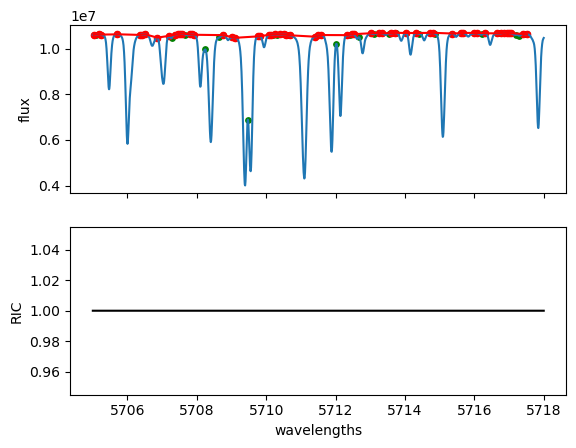

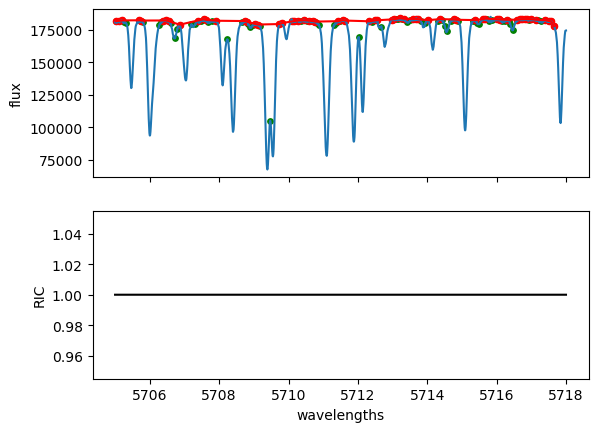

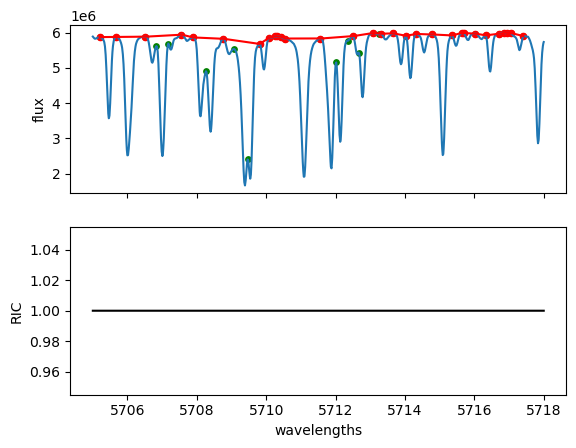

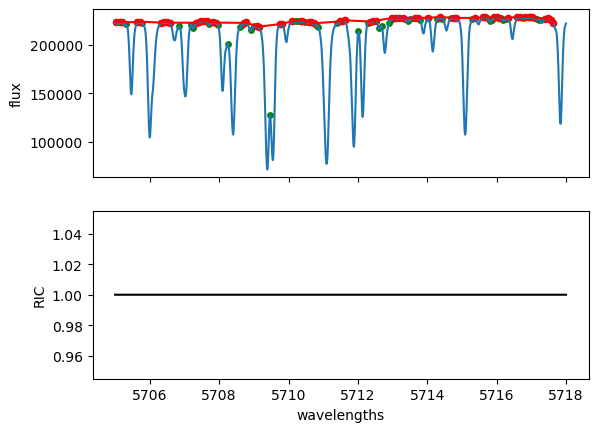

In [20]:
w_obs_hd136, f_obs_hd136 = obs_spectrum("spectra/HD136352_SINGLEHR11_ESPRESSO_2022.fits", wave_start1, wave_end1)
w_obs_hd137, f_obs_hd137 = obs_spectrum("spectra/HD137496_ESPRESSO_2024_c.fits", wave_start1, wave_end1)
w_obs_toi402, f_obs_toi402 = obs_spectrum("spectra/TOI-402_ESPRESSO_2024.fits", wave_start1, wave_end1)
w_obs_hd203, f_obs_hd203 = obs_spectrum("spectra/HD20329_ESPRESSO_2024.fits", wave_start1, wave_end1)

2025-04-23 12:29:36.024 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 12:29:36.436 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 12:29:36.439 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 12:29:36.467 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 12:29:38.430 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 12:29:39.388 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 12:29:39.392 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 12:29:39.420 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 12:29:41.464 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 12:29:42.291 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 12:29:42.296 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 12:29:42.338

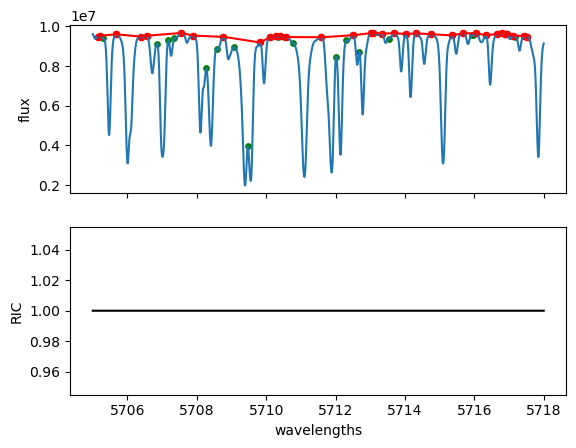

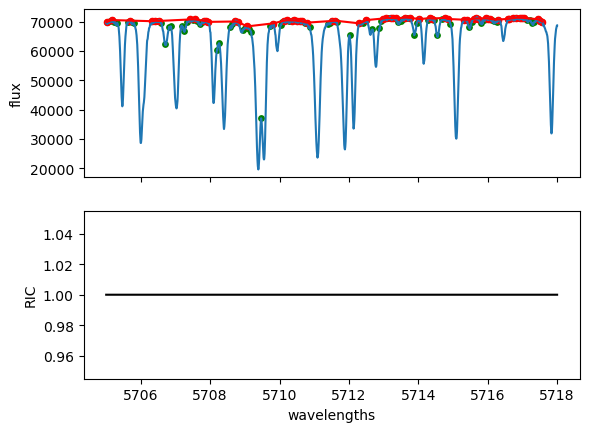

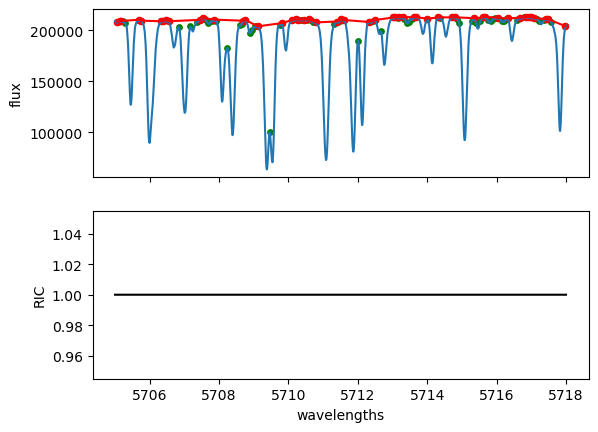

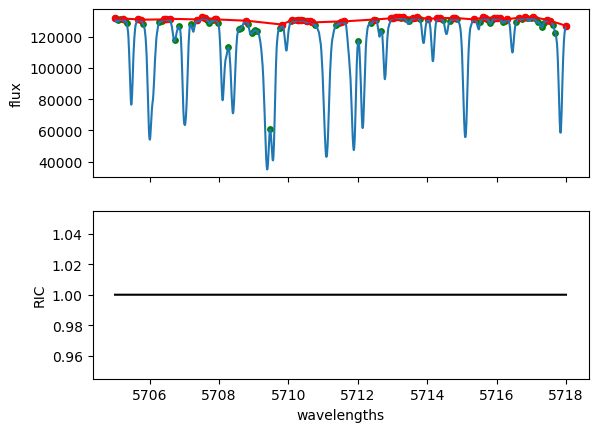

In [21]:
w_obs_55cnc, f_obs_55cnc = obs_spectrum("spectra/55Cnc_SINGLEHR11_ESPRESSO_2022.fits", wave_start1, wave_end1)
w_obs_k2106, f_obs_k2106 = obs_spectrum("spectra/K2-106_ESPRESSO_2024_c.fits", wave_start1, wave_end1)
w_obs_k2314, f_obs_k2314 = obs_spectrum("spectra/K2-314_ESPRESSO_2024.fits", wave_start1, wave_end1)
w_obs_k2229, f_obs_k2229 = obs_spectrum("spectra/K2-229_ESPRESSO_2025.fits", wave_start1, wave_end1)

2025-04-23 13:06:55.863 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...


2025-04-23 13:06:56.741 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:06:56.745 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:06:56.794 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:06:59.367 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:00.108 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:00.112 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:00.147 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:02.392 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:03.097 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:03.102 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:03.144 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:

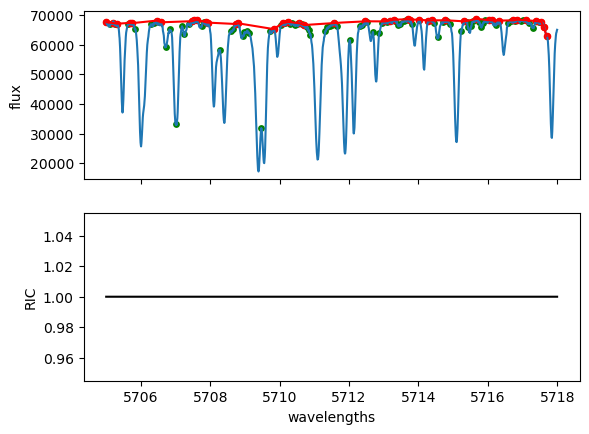

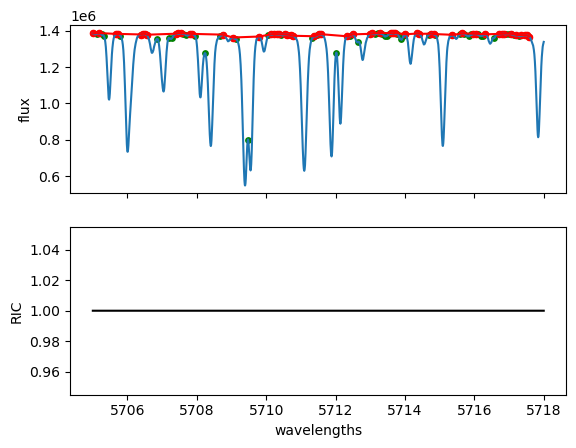

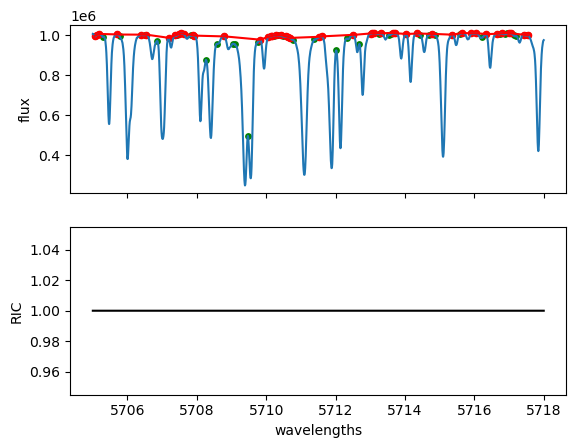

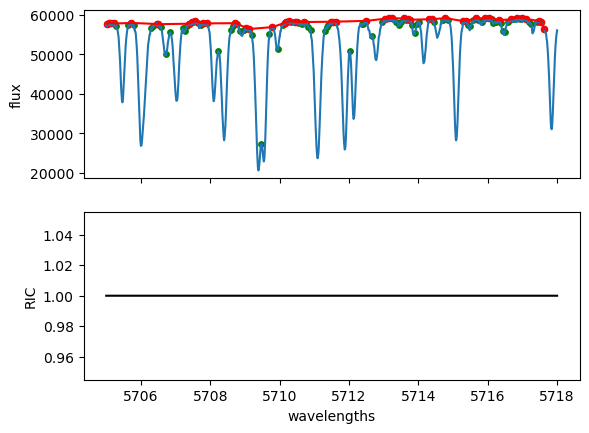

In [27]:
w_obs_corot, f_obs_corot = obs_spectrum("spectra/CoRoT-07_ESPRESSO_2024.fits", wave_start1, wave_end1)
w_obs_hd213, f_obs_hd213 = obs_spectrum("spectra/HD213885_ESPRESSO_2024.fits", wave_start1, wave_end1)
w_obs_hd3167, f_obs_hd3167 = obs_spectrum("spectra/HD3167_ESPRESSO_2024.fits", wave_start1, wave_end1)
w_obs_hd806, f_obs_hd806 = obs_spectrum("spectra/HD80653_ESPRESSO_2024_c.fits", wave_start1, wave_end1)

2025-04-23 13:07:12.284 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...


2025-04-23 13:07:13.018 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:13.022 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:13.058 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:15.745 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:16.623 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:16.627 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:16.658 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots


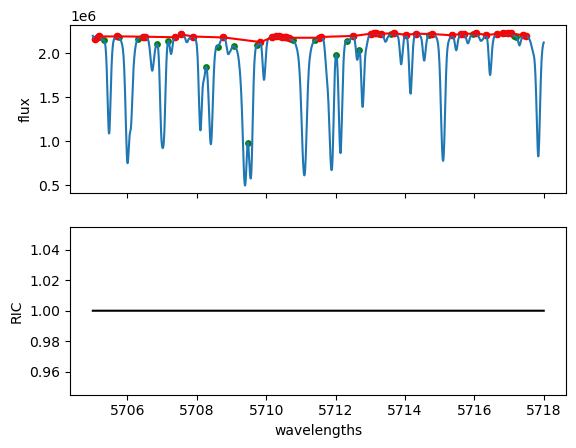

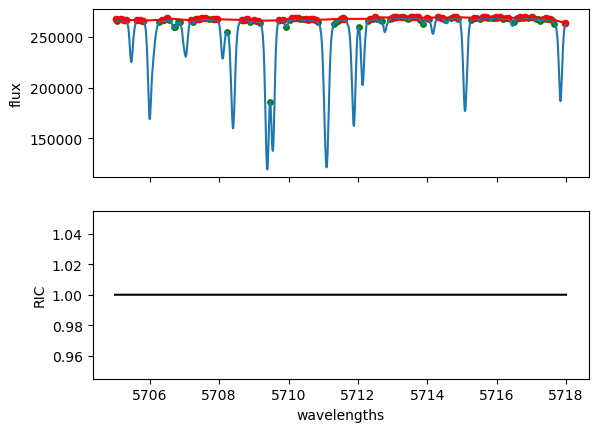

In [28]:
w_obs_toi469, f_obs_toi469 = obs_spectrum("spectra/TOI-469_SINGLEHR11_ESPRESSO_2022.fits", wave_start1, wave_end1)
w_obs_k2111, f_obs_k2111 = obs_spectrum("spectra/K2-111_ESPRESSO_2024.fits", wave_start1, wave_end1)

2025-04-23 13:07:21.771 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:22.642 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:22.645 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:22.688 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:25.150 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:25.829 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:25.832 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:25.865 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:28.853 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:30.027 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:30.031 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:30.086

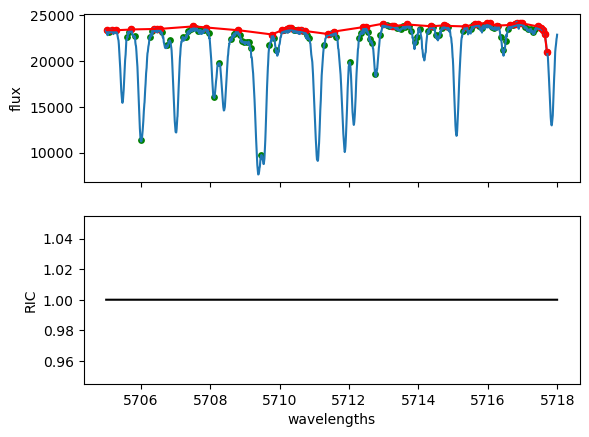

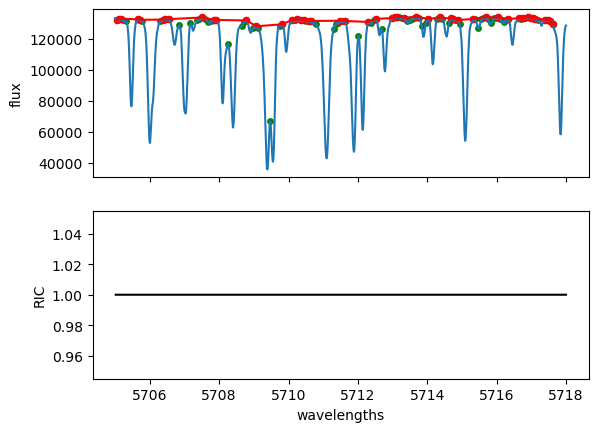

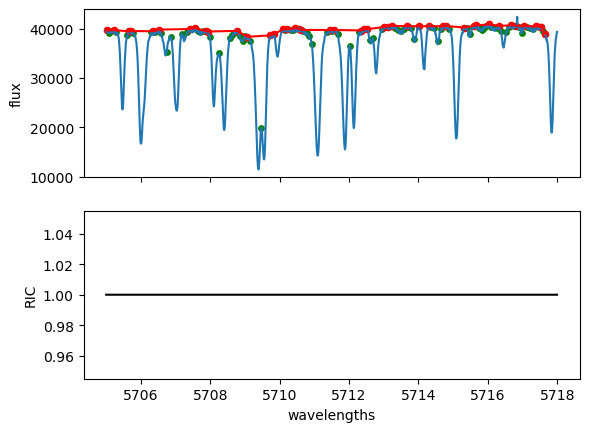

In [29]:
w_obs_k2131, f_obs_k2131 = obs_spectrum("spectra/K2-131_ESPRESSO_2024_c.fits", wave_start1, wave_end1)
w_obs_k2265, f_obs_k2265 = obs_spectrum("spectra/K2-265_ESPRESSO_2024.fits", wave_start1, wave_end1)
w_obs_hd285, f_obs_hd285 = obs_spectrum("spectra/HD285181_ESPRESSO_2024_c.fits", wave_start1, wave_end1)

2025-04-23 13:07:35.547 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:36.043 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:36.046 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:36.081 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:38.356 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:38.843 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:38.847 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:38.876 | INFO     | SNT.snt:normalize_spectra:95 - Generating plots
2025-04-23 13:07:40.900 | DEBUG    | SNT.snt:normalize_spectra:47 - Running...
2025-04-23 13:07:41.623 | INFO     | SNT.snt:normalize_spectra:77 - Data storage folder set to SNT_data
2025-04-23 13:07:41.627 | INFO     | SNT.snt:normalize_spectra:78 - Saving text files
2025-04-23 13:07:41.660

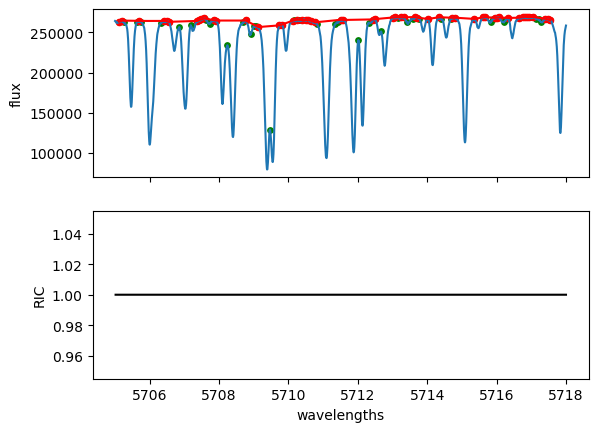

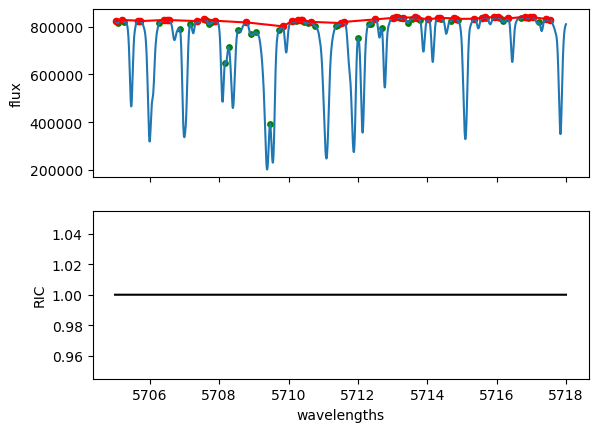

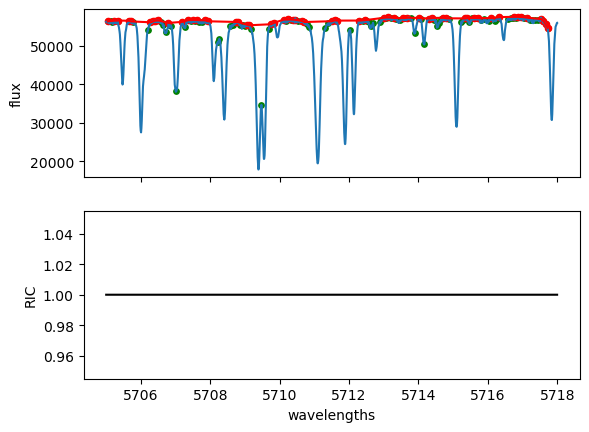

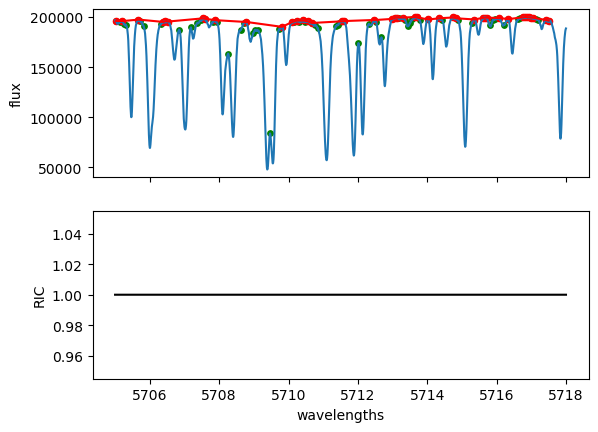

In [30]:
w_obs_k238, f_obs_k238 = obs_spectrum("spectra/K2-38_ESPRESSO_2024.fits",wave_start1,wave_end1)
w_obs_toi238, f_obs_toi238 = obs_spectrum("spectra/TOI-238_SINGLEHR11_ESPRESSO_2022.fits",wave_start1,wave_end1)
w_obs_toi561, f_obs_toi561 = obs_spectrum("spectra/TOI-561_ESPRESSO_2024_c.fits", wave_start1,wave_end1)
w_obs_wasp47, f_obs_wasp47 = obs_spectrum("spectra/WASP-47_ESPRESSO_2024.fits",wave_start1,wave_end1)

### comparing with synth spectra

In [ ]:
sample["star"]

0        55Cnc_SINGLEHR11_ESPRESSO_2022
1                CoRoT-07_ESPRESSO_2024
2                  K2-106_ESPRESSO_2024
3                  K2-314_ESPRESSO_2024
4                  K2-229_ESPRESSO_2024
5     HD136352_SINGLEHR11_ESPRESSO_2022
6                HD137496_ESPRESSO_2024
7                 TOI-402_ESPRESSO_2024
8                 HD20329_ESPRESSO_2024
9                HD213885_ESPRESSO_2024
10                 HD3167_ESPRESSO_2024
11                HD80653_ESPRESSO_2024
12     TOI-469_SINGLEHR11_ESPRESSO_2022
13                 K2-111_ESPRESSO_2024
14                 K2-131_ESPRESSO_2024
15                 K2-265_ESPRESSO_2024
16               HD285181_ESPRESSO_2024
17                  K2-38_ESPRESSO_2024
18     TOI-238_SINGLEHR11_ESPRESSO_2022
19                TOI-561_ESPRESSO_2024
20                WASP-47_ESPRESSO_2024
Name: star, dtype: object

In [118]:
abundances = np.arange(-1, 0.6, 0.01)
abundances = np.round(abundances, 3)

In [91]:
#fwhm_gaussian = lambda / R
5711.09 / 140000

0.0407935

##### corot07

In [273]:
vsini_corot = 2.71
vmac_corot = vmac[1]
limb_corot = 0.693

LOWEST CHI2: Mg abundance: 0.17 with chi2=0.0697852067868066
Mg abundance: -1.0, chi2: 7.0611837702414855
Mg abundance: -0.99, chi2: 6.984756603288247
Mg abundance: -0.98, chi2: 6.907227566665041
Mg abundance: -0.97, chi2: 6.8298834827871415
Mg abundance: -0.96, chi2: 6.7524386729622705
Mg abundance: -0.95, chi2: 6.674420795705471
Mg abundance: -0.94, chi2: 6.596759817255897
Mg abundance: -0.93, chi2: 6.518202465419728
Mg abundance: -0.92, chi2: 6.439728349462675
Mg abundance: -0.91, chi2: 6.360858827567617
Mg abundance: -0.9, chi2: 6.281990266493569
Mg abundance: -0.89, chi2: 6.202965004806511
Mg abundance: -0.88, chi2: 6.124075598499076
Mg abundance: -0.87, chi2: 6.044772632433024
Mg abundance: -0.86, chi2: 5.965604755605853
Mg abundance: -0.85, chi2: 5.886370813084465
Mg abundance: -0.84, chi2: 5.806809856008868
Mg abundance: -0.83, chi2: 5.727892487759443
Mg abundance: -0.82, chi2: 5.648140733252341
Mg abundance: -0.81, chi2: 5.5687105599247335
Mg abundance: -0.8, chi2: 5.489147361

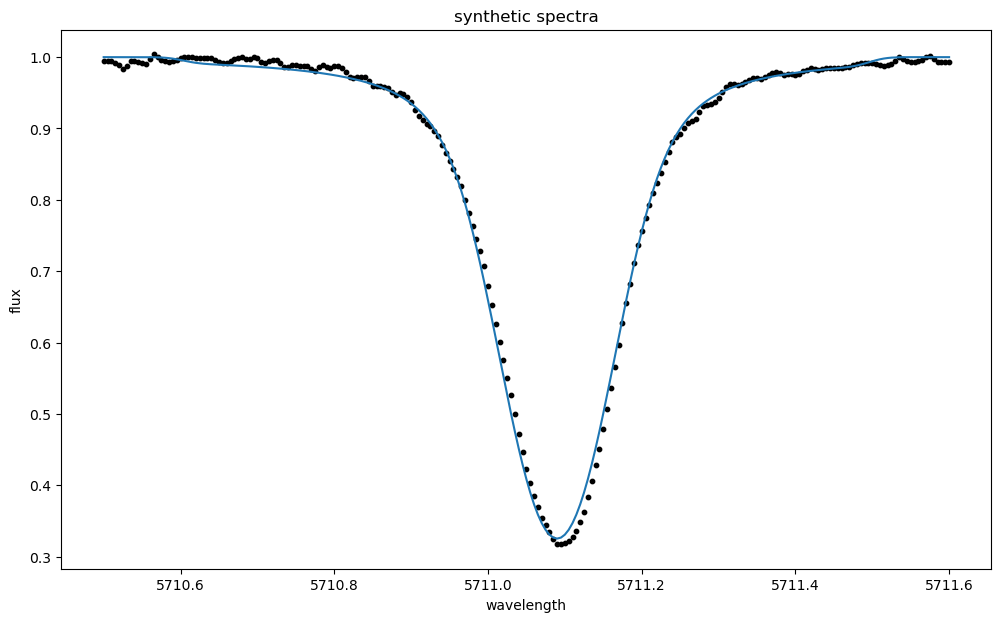

In [277]:
abundances1 = np.append(abundances, -0.019)
abundances1 = np.sort(abundances1) #line abundance (= 0) avg abundaces =-0.019
w_syn_corot,f_syn_corot,best_chi2_corot,best_abund_corot = synth_compare("CoRoT-07_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_corot,f_obs_corot,"r", vsini_corot,limb_corot,vmac_corot)

In [391]:
#rv_corot = 31.110 #simbad km/s
#rv_corot = 0.5 #intervall ca -0.5 bis 0.5

rv_range = np.arange(-10,10,0.01)
rv_range = np.round(rv_range, 3)

mask = (w_obs_corot >= 5710.5) & (w_obs_corot <= 5711.605)
w_obs_corot_cut = w_obs_corot[mask]
f_obs_corot_cut = f_obs_corot[mask]

chi2 from flux diff without shift: 0.0697852067868066
LOWEST CHI2 SHIFTED for RV= 0.2 km/s with chi2=0.024384169637462014


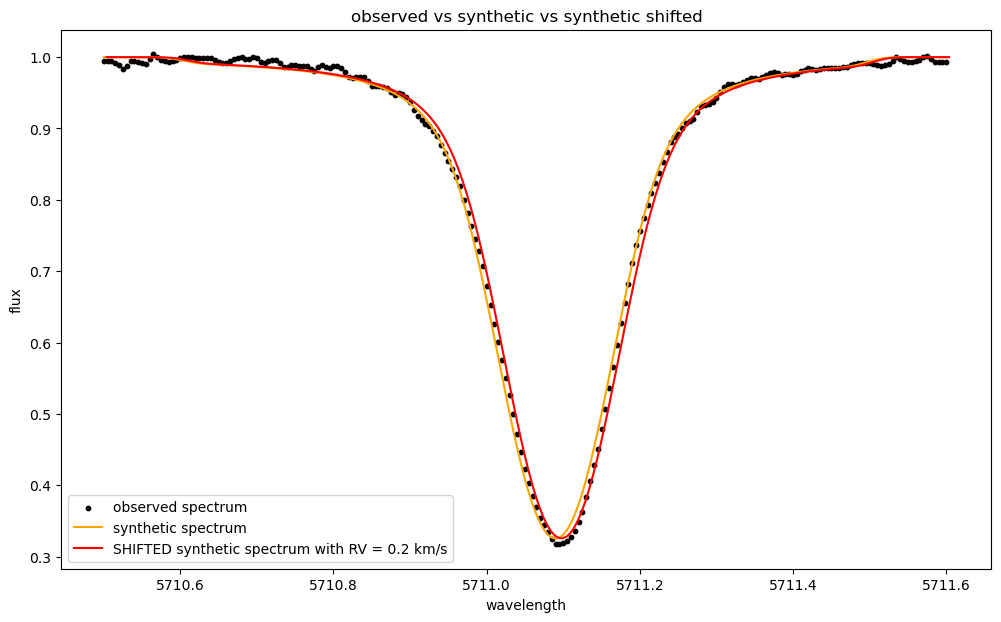

In [392]:
best_rv_corot,best_chi2_corot = rv_shift(rv_range, w_syn_corot,f_syn_corot, w_obs_corot_cut, f_obs_corot_cut)

LOWEST CHI2: Mg abundance: 0.18 with chi2=0.023711020484567153
Mg abundance: -1.0, chi2: 7.060305341434393
Mg abundance: -0.99, chi2: 6.983800888741355
Mg abundance: -0.98, chi2: 6.906190755673053
Mg abundance: -0.97, chi2: 6.828762725712959
Mg abundance: -0.96, chi2: 6.751230564075172
Mg abundance: -0.95, chi2: 6.673122056343713
Mg abundance: -0.94, chi2: 6.5953674540968885
Mg abundance: -0.93, chi2: 6.516712270101703
Mg abundance: -0.92, chi2: 6.438137382143581
Mg abundance: -0.91, chi2: 6.359162509650823
Mg abundance: -0.9, chi2: 6.280186159683156
Mg abundance: -0.89, chi2: 6.201048585657022
Mg abundance: -0.88, chi2: 6.1220431438141905
Mg abundance: -0.87, chi2: 6.042620409142092
Mg abundance: -0.86, chi2: 5.963329029491746
Mg abundance: -0.85, chi2: 5.883967923099248
Mg abundance: -0.84, chi2: 5.80427503538653
Mg abundance: -0.83, chi2: 5.725221863422407
Mg abundance: -0.82, chi2: 5.645330982249638
Mg abundance: -0.81, chi2: 5.565755661406277
Mg abundance: -0.8, chi2: 5.4860442554

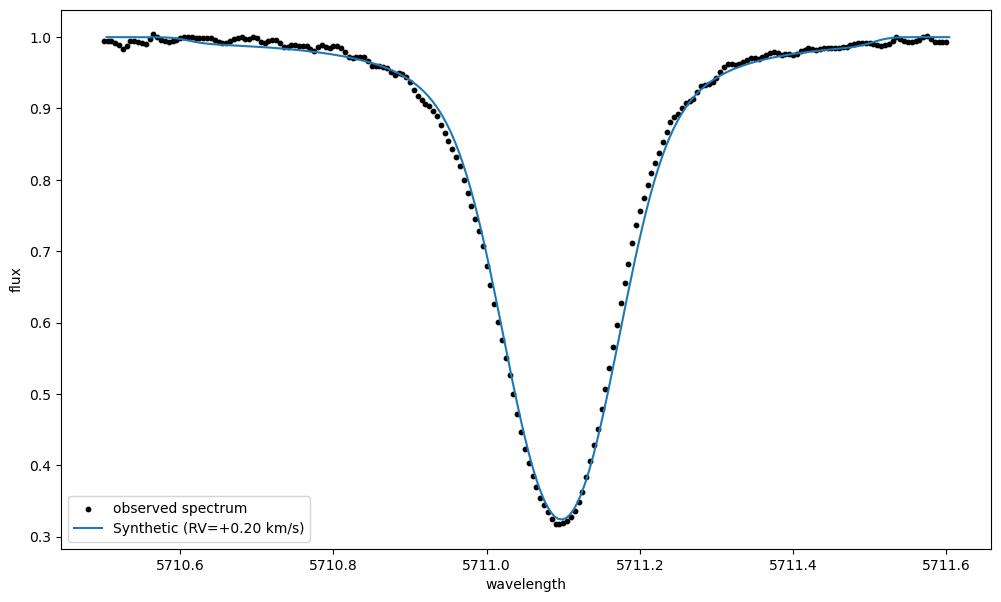

In [390]:
abundances1 = np.append(abundances, -0.019)
abundances1 = np.sort(abundances1) #line abundance (= 0) avg abundaces =-0.019
w_syn_corot_rv,f_syn_corot_rv,best_chi2_corot_rv,best_abund_corot_rv = synth_compare_with_rv_shift("CoRoT-07_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_corot,f_obs_corot,"r", vsini_corot,limb_corot,vmac_corot,best_rv_corot)

##### 55 cnc

In [135]:
vsini_55 = 2.24
vmac_55 = vmac[0]
limb_dark55 = 0.714

LOWEST CHI2: Mg abundance: 0.26 with chi2=0.11616598350494113
Mg abundance: -1.0, chi2: 8.488968028614481
Mg abundance: -0.99, chi2: 8.401871624540004
Mg abundance: -0.98, chi2: 8.314376844106347
Mg abundance: -0.97, chi2: 8.226754379010288
Mg abundance: -0.96, chi2: 8.139200141216186
Mg abundance: -0.95, chi2: 8.051861840588073
Mg abundance: -0.94, chi2: 7.964074351285569
Mg abundance: -0.93, chi2: 7.876511500039866
Mg abundance: -0.92, chi2: 7.788368370383013
Mg abundance: -0.91, chi2: 7.700961132789905
Mg abundance: -0.9, chi2: 7.612539865115126
Mg abundance: -0.89, chi2: 7.524615110696217
Mg abundance: -0.88, chi2: 7.436425628220363
Mg abundance: -0.87, chi2: 7.348917511492576
Mg abundance: -0.86, chi2: 7.261159814563643
Mg abundance: -0.85, chi2: 7.173239920048136
Mg abundance: -0.84, chi2: 7.084949137979157
Mg abundance: -0.83, chi2: 6.997173897185688
Mg abundance: -0.82, chi2: 6.909566933019133
Mg abundance: -0.81, chi2: 6.821365737866918
Mg abundance: -0.8, chi2: 6.733565754179

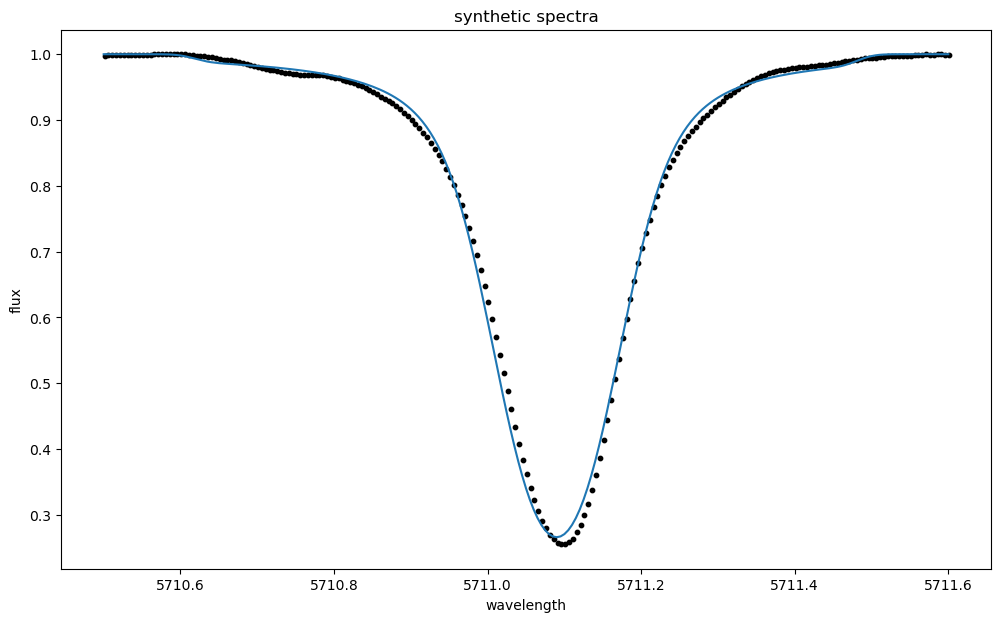

In [278]:
abundances1 = np.append(abundances, 0.379)
abundances1 = np.sort(abundances1) #avg abundance
w_syn_55cnc, f_syn_55cnc, best_chi2_55cnc,best_abund_55Cnc = synth_compare("55Cnc_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_55cnc,f_obs_55cnc,"r",vsini_55,limb_dark55,vmac_55)

chi2 from flux diff without shift: 0.11616598350494113
LOWEST CHI2 SHIFTED for RV= 0.25 km/s with chi2=0.05523552757738062


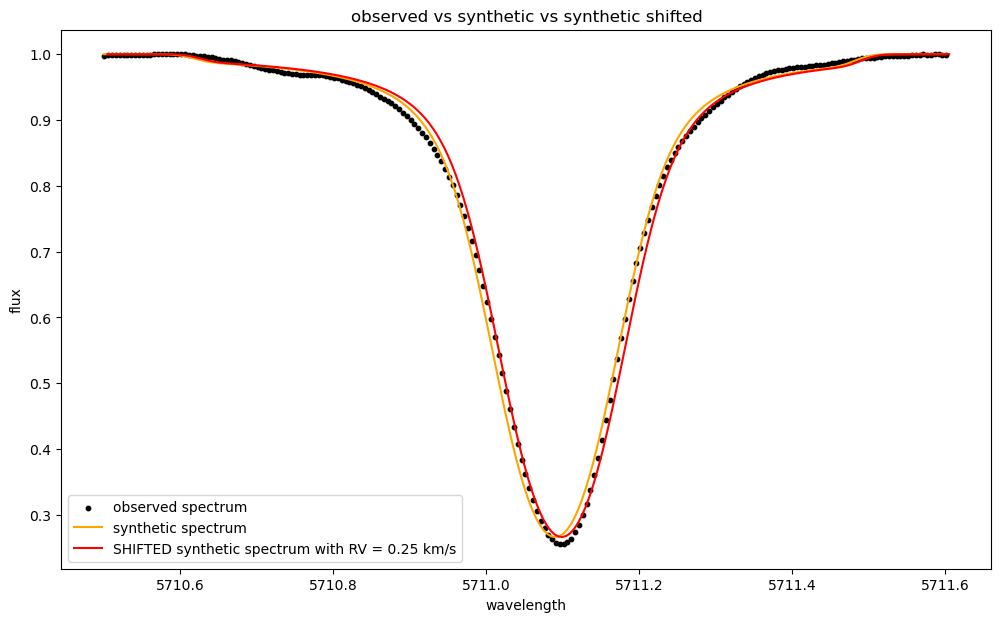

In [393]:
mask = (w_obs_55cnc >= 5710.5) & (w_obs_55cnc <= 5711.605)
w_obs_55cnc_cut = w_obs_55cnc[mask]
f_obs_55cnc_cut = f_obs_55cnc[mask]

best_rv_55cnc ,best_chi2_55cnc = rv_shift(rv_range, w_syn_55cnc,f_syn_55cnc, w_obs_55cnc_cut, f_obs_55cnc_cut)

LOWEST CHI2: Mg abundance: 0.26 with chi2=0.0552355275818513
Mg abundance: -1.0, chi2: 8.489339257506225
Mg abundance: -0.99, chi2: 8.402142790282419
Mg abundance: -0.98, chi2: 8.314544060903053
Mg abundance: -0.97, chi2: 8.226813763843815
Mg abundance: -0.96, chi2: 8.13914739160102
Mg abundance: -0.95, chi2: 8.051692770267113
Mg abundance: -0.94, chi2: 7.9637845862967795
Mg abundance: -0.93, chi2: 7.8760975237912545
Mg abundance: -0.92, chi2: 7.787824282609373
Mg abundance: -0.91, chi2: 7.700284345570285
Mg abundance: -0.9, chi2: 7.611723861311004
Mg abundance: -0.89, chi2: 7.5236564888747335
Mg abundance: -0.88, chi2: 7.435319564664512
Mg abundance: -0.87, chi2: 7.347659765858535
Mg abundance: -0.86, chi2: 7.25974544313779
Mg abundance: -0.85, chi2: 7.171664138429353
Mg abundance: -0.84, chi2: 7.083206825384377
Mg abundance: -0.83, chi2: 6.995259976291699
Mg abundance: -0.82, chi2: 6.9074771053808455
Mg abundance: -0.81, chi2: 6.81909406692834
Mg abundance: -0.8, chi2: 6.731107805338

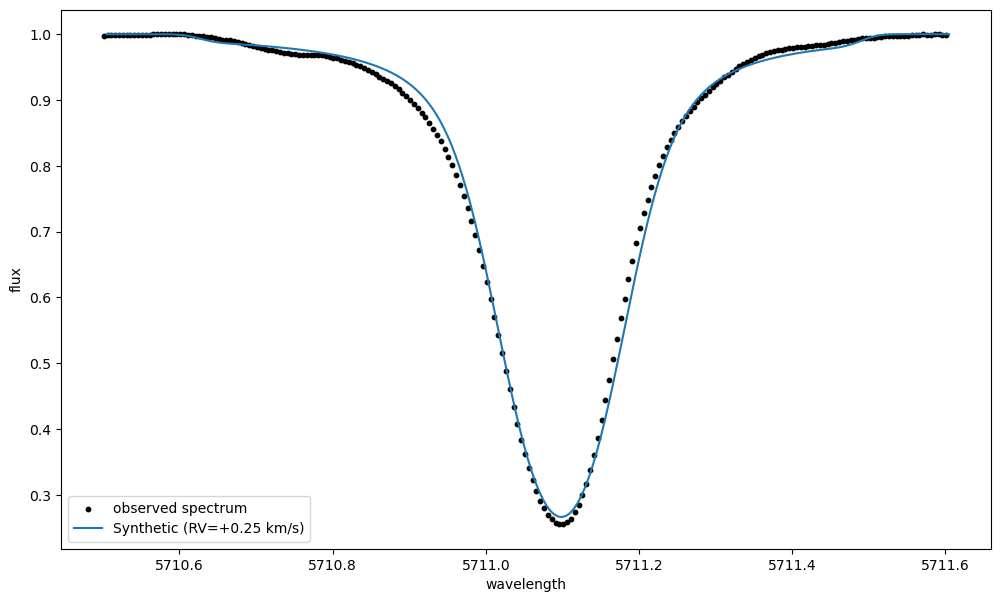

In [395]:
abundances1 = np.append(abundances, 0.379)
abundances1 = np.sort(abundances1) #avg abundance
w_syn_55cnc_rv, f_syn_55cnc_rv, best_chi2_55cnc_rv,best_abund_55Cnc_rv = synth_compare_with_rv_shift("55Cnc_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_55cnc,f_obs_55cnc,"r",vsini_55,limb_dark55,vmac_55,best_rv_55cnc)

##### k2-106

In [195]:
vsini_k2106 = 1.74
vmac_k2106 = vmac[2]
limb_k2106 = 0.662

LOWEST CHI2: Mg abundance: 0.1 with chi2=0.028730757633444834
Mg abundance: -1.0, chi2: 5.894528681744659
Mg abundance: -0.99, chi2: 5.8220591019604795
Mg abundance: -0.98, chi2: 5.749377813316581
Mg abundance: -0.97, chi2: 5.6765273424358185
Mg abundance: -0.96, chi2: 5.603147709068308
Mg abundance: -0.95, chi2: 5.52992799020493
Mg abundance: -0.94, chi2: 5.456319148447072
Mg abundance: -0.93, chi2: 5.382312277254306
Mg abundance: -0.92, chi2: 5.308232907773602
Mg abundance: -0.91, chi2: 5.234069936801145
Mg abundance: -0.9, chi2: 5.159801278888977
Mg abundance: -0.89, chi2: 5.0851147568444945
Mg abundance: -0.88, chi2: 5.010918456635703
Mg abundance: -0.87, chi2: 4.936310640760223
Mg abundance: -0.86, chi2: 4.8613827575982835
Mg abundance: -0.85, chi2: 4.786962174130652
Mg abundance: -0.84, chi2: 4.711827540494527
Mg abundance: -0.83, chi2: 4.63739710168887
Mg abundance: -0.82, chi2: 4.562776933338022
Mg abundance: -0.81, chi2: 4.488184992580614
Mg abundance: -0.8, chi2: 4.4132158515

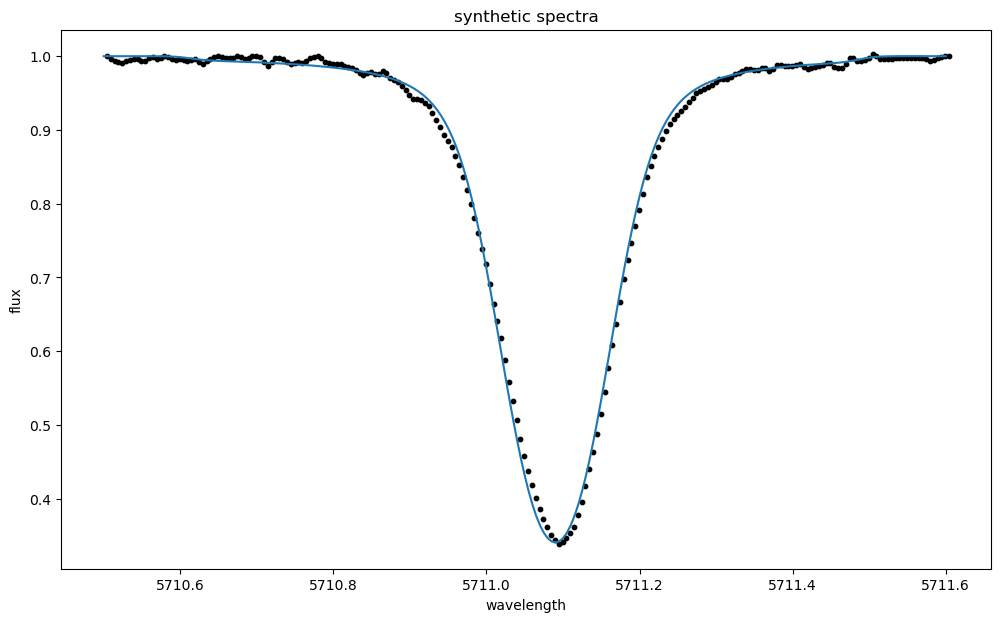

In [197]:
#avg abundance
abundances1 = np.append(abundances, 0.074)
abundances1 = np.sort(abundances1)
w_syn_k2106,f_syn_k2106,best_chi2_k2106,best_abund_k2106 = synth_compare("K2-106_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2106,f_obs_k2106,"r",vsini_k2106,limb_k2106, vmac_k2106)

chi2 from flux diff without shift: 0.028730757633444834
LOWEST CHI2 SHIFTED for RV= 0.16 km/s with chi2=0.023210690093468277


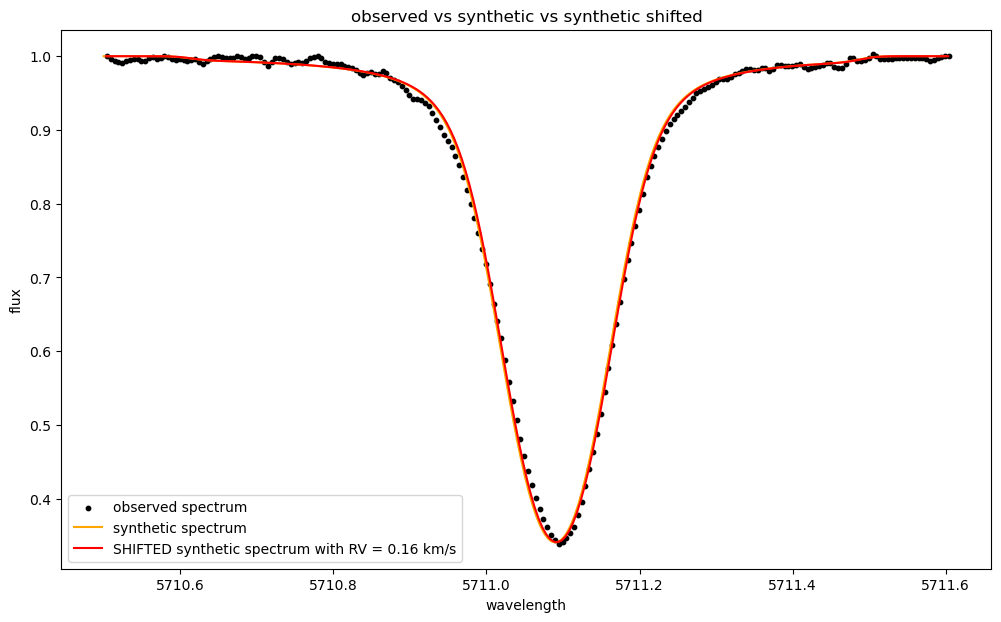

LOWEST CHI2: Mg abundance: 0.1 with chi2=0.023210690078151793
Mg abundance: -1.0, chi2: 5.89513249842185
Mg abundance: -0.99, chi2: 5.822680294856142
Mg abundance: -0.98, chi2: 5.7500162865763444
Mg abundance: -0.97, chi2: 5.6771829918588566
Mg abundance: -0.96, chi2: 5.6038205339332485
Mg abundance: -0.95, chi2: 5.5306179406964855
Mg abundance: -0.94, chi2: 5.45702578872111
Mg abundance: -0.93, chi2: 5.383035900712161
Mg abundance: -0.92, chi2: 5.308972822652398
Mg abundance: -0.91, chi2: 5.234826141084072
Mg abundance: -0.9, chi2: 5.160573438401648
Mg abundance: -0.89, chi2: 5.085902761086903
Mg abundance: -0.88, chi2: 5.01172144566254
Mg abundance: -0.87, chi2: 4.937128786363764
Mg abundance: -0.86, chi2: 4.862215369746423
Mg abundance: -0.85, chi2: 4.787808915876804
Mg abundance: -0.84, chi2: 4.7126880265074425
Mg abundance: -0.83, chi2: 4.6382702249313645
Mg abundance: -0.82, chi2: 4.563662740375653
Mg abundance: -0.81, chi2: 4.489082584793367
Mg abundance: -0.8, chi2: 4.414124483

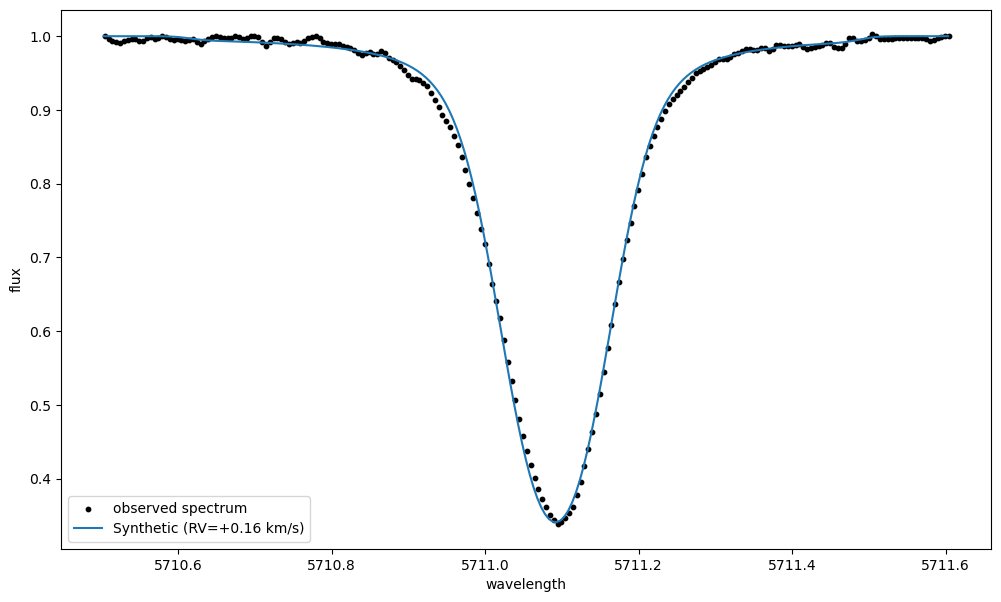

In [397]:
mask = (w_obs_k2106 >= 5710.5) & (w_obs_k2106 <= 5711.605)
w_obs_k2106_cut = w_obs_k2106[mask]
f_obs_k2106_cut = f_obs_k2106[mask]

best_rv_k2106, best_chi2_k2106 = rv_shift(rv_range, w_syn_k2106, f_syn_k2106, w_obs_k2106_cut, f_obs_k2106_cut)

#avg abundance
abundances1 = np.append(abundances, 0.074)
abundances1 = np.sort(abundances1)
w_syn_k2106_rv,f_syn_k2106_rv,best_chi2_k2106_rv,best_abund_k2106_rv = synth_compare_with_rv_shift("K2-106_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2106,f_obs_k2106,"r",vsini_k2106,limb_k2106, vmac_k2106, best_rv_k2106)

##### k2-314

In [198]:
vsini_k2314 = 2.34 
vmac_k2314 = vmac[3]
limb_k2314 = 0.659

LOWEST CHI2: Mg abundance: 0.09 with chi2=0.2868870770639804
Mg abundance: -1.0, chi2: 5.644498130430288
Mg abundance: -0.99, chi2: 5.573818928517443
Mg abundance: -0.98, chi2: 5.50337130186362
Mg abundance: -0.97, chi2: 5.432683300684774
Mg abundance: -0.96, chi2: 5.362187893231818
Mg abundance: -0.95, chi2: 5.290662492195084
Mg abundance: -0.94, chi2: 5.220062097643226
Mg abundance: -0.93, chi2: 5.14913522302097
Mg abundance: -0.92, chi2: 5.077867483012
Mg abundance: -0.91, chi2: 5.00682219584117
Mg abundance: -0.9, chi2: 4.935794547495285
Mg abundance: -0.89, chi2: 4.86467273804725
Mg abundance: -0.88, chi2: 4.793643108889723
Mg abundance: -0.87, chi2: 4.722586737304885
Mg abundance: -0.86, chi2: 4.651761018656857
Mg abundance: -0.85, chi2: 4.581103853641812
Mg abundance: -0.84, chi2: 4.509929653023458
Mg abundance: -0.83, chi2: 4.439508266354136
Mg abundance: -0.82, chi2: 4.369051884940016
Mg abundance: -0.81, chi2: 4.299170117235498
Mg abundance: -0.8, chi2: 4.228961103971217
Mg a

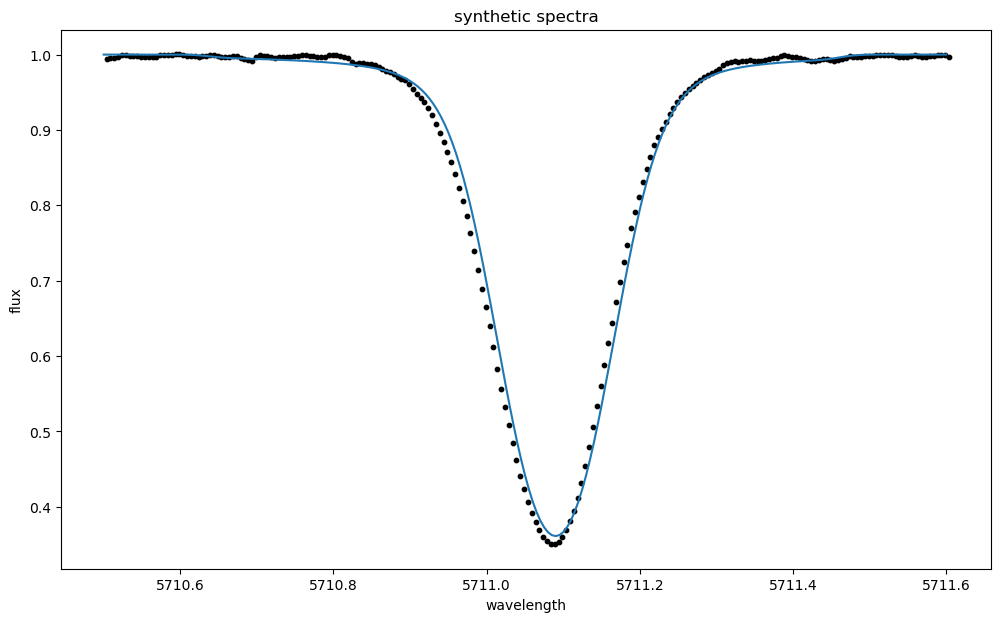

In [200]:
#line abundances
abundances1 = np.append(abundances, 0.271)
abundances1 = np.sort(abundances1)
w_syn_k2314,f_syn_k2314,best_chi2_k2314,best_abund_k2314 = synth_compare("K2-314_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2314,f_obs_k2314,"r",vsini_k2314,limb_k2314, vmac_k2314)

chi2 from flux diff without shift: 0.2868870770639804
LOWEST CHI2 SHIFTED for RV= -0.32 km/s with chi2=0.0161824601699056


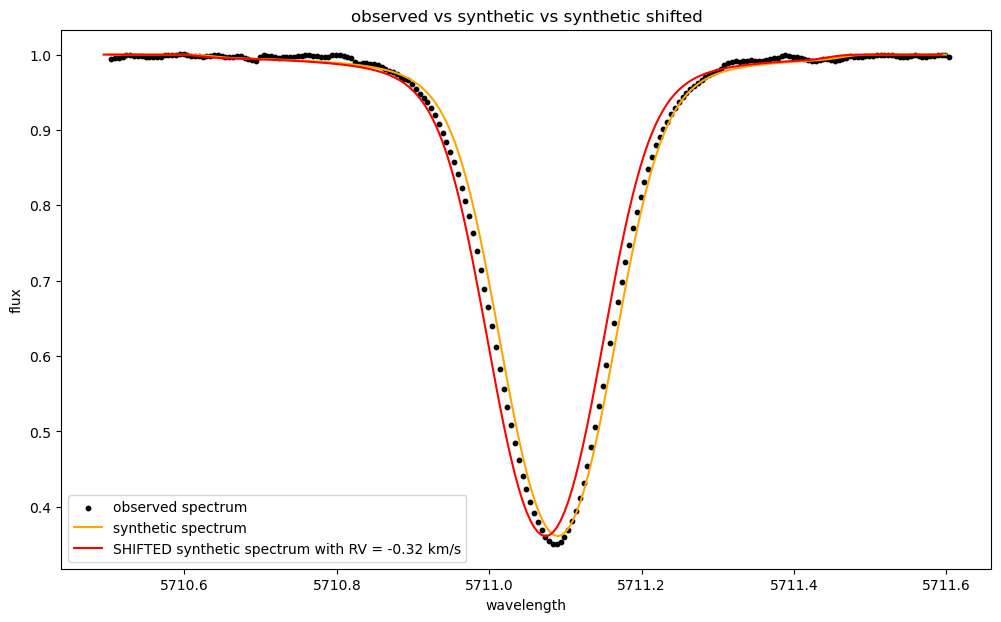

LOWEST CHI2: Mg abundance: 0.12 with chi2=0.009759924553616201
Mg abundance: -1.0, chi2: 5.608638088950645
Mg abundance: -0.99, chi2: 5.5370852251706
Mg abundance: -0.98, chi2: 5.465749395314342
Mg abundance: -0.97, chi2: 5.3941553322069975
Mg abundance: -0.96, chi2: 5.32273867536683
Mg abundance: -0.95, chi2: 5.250262742918588
Mg abundance: -0.94, chi2: 5.178704779539833
Mg abundance: -0.93, chi2: 5.106799920949875
Mg abundance: -0.92, chi2: 5.03453068691511
Mg abundance: -0.91, chi2: 4.962468843360936
Mg abundance: -0.9, chi2: 4.89040628815433
Mg abundance: -0.89, chi2: 4.818228588551701
Mg abundance: -0.88, chi2: 4.746125056929538
Mg abundance: -0.87, chi2: 4.673970453476665
Mg abundance: -0.86, chi2: 4.602032904100134
Mg abundance: -0.85, chi2: 4.530244791076823
Mg abundance: -0.84, chi2: 4.457910728892087
Mg abundance: -0.83, chi2: 4.386317048040882
Mg abundance: -0.82, chi2: 4.314667431561529
Mg abundance: -0.81, chi2: 4.243576571835415
Mg abundance: -0.8, chi2: 4.172132524456261

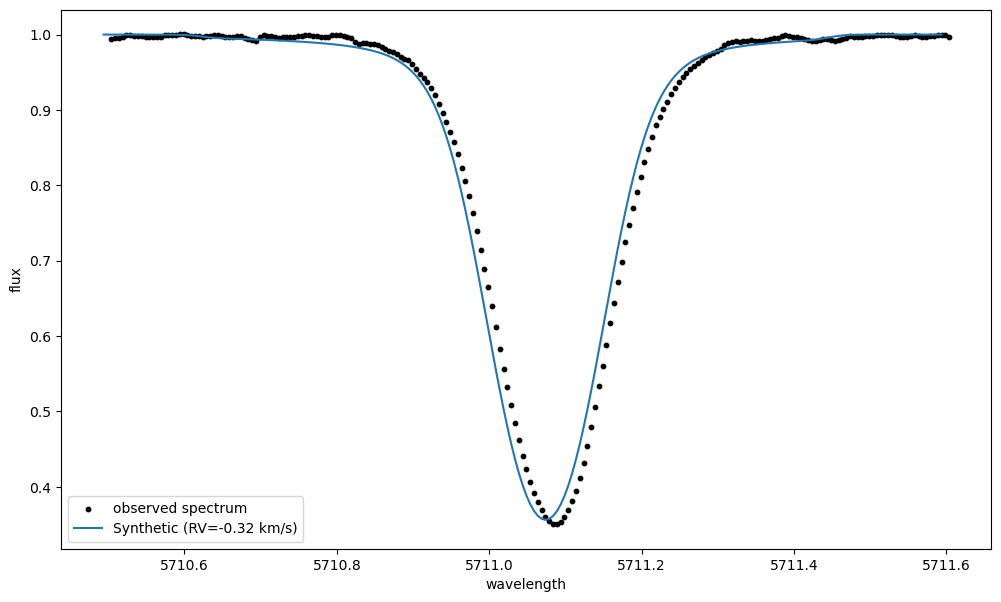

In [399]:
mask = (w_obs_k2314 >= 5710.5) & (w_obs_k2314 <= 5711.605)
w_obs_k2314_cut = w_obs_k2314[mask]
f_obs_k2314_cut = f_obs_k2314[mask]

best_rv_k2314, best_chi2_k2314 = rv_shift(rv_range, w_syn_k2314, f_syn_k2314, w_obs_k2314_cut, f_obs_k2314_cut)

#line abundances
abundances1 = np.append(abundances, 0.271)
abundances1 = np.sort(abundances1)
w_syn_k2314_rv,f_syn_k2314_rv,best_chi2_k2314_rv,best_abund_k2314_rv = synth_compare_with_rv_shift("K2-314_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2314,f_obs_k2314,"r",vsini_k2314,limb_k2314, vmac_k2314,best_rv_k2314)


##### k2-229

In [ ]:
vsini_k2229 = 2.41
vmac_k2229 = vmac[4]
limb_k2229 = 0.693

LOWEST CHI2: Mg abundance: 0.16 with chi2=0.02129058039531659
Mg abundance: -1.0, chi2: 7.087645597717215
Mg abundance: -0.99, chi2: 7.010866201637578
Mg abundance: -0.98, chi2: 6.93355204030435
Mg abundance: -0.97, chi2: 6.856393196433566
Mg abundance: -0.96, chi2: 6.77803054243746
Mg abundance: -0.95, chi2: 6.699837249073921
Mg abundance: -0.94, chi2: 6.621201397501724
Mg abundance: -0.93, chi2: 6.542312189165372
Mg abundance: -0.92, chi2: 6.462995735160926
Mg abundance: -0.91, chi2: 6.383457977421126
Mg abundance: -0.9, chi2: 6.304039533748845
Mg abundance: -0.89, chi2: 6.22406325414212
Mg abundance: -0.88, chi2: 6.144274240027718
Mg abundance: -0.87, chi2: 6.063661186900119
Mg abundance: -0.86, chi2: 5.98299075088059
Mg abundance: -0.85, chi2: 5.902504838302654
Mg abundance: -0.84, chi2: 5.821610945225094
Mg abundance: -0.83, chi2: 5.7406475415677205
Mg abundance: -0.82, chi2: 5.659662255051859
Mg abundance: -0.81, chi2: 5.578566635796334
Mg abundance: -0.8, chi2: 5.497217603027451

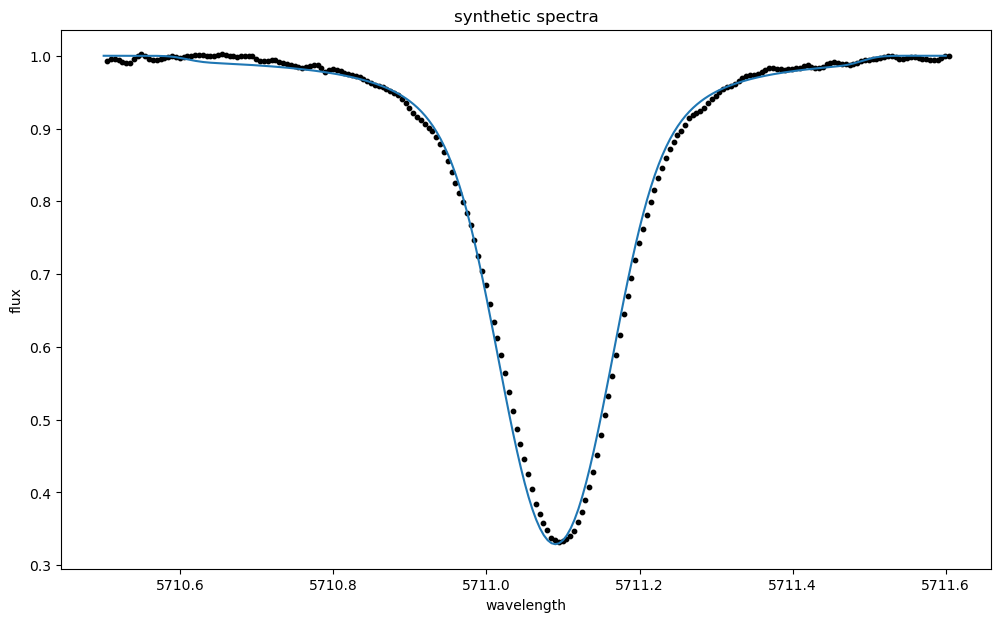

In [203]:
#avg abundance
abundances1 = np.append(abundances, -0.065)
abundances1 = np.sort(abundances1)
w_syn_k2229,f_syn_k2229, best_chi2_k2229, best_abund_k2229 = synth_compare("K2-229_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2229,f_obs_k2229,"r",vsini_k2229,limb_k2229, vmac_k2229)

chi2 from flux diff without shift: 0.02129058039531659
LOWEST CHI2 SHIFTED for RV= 0.25 km/s with chi2=0.02060407883829565


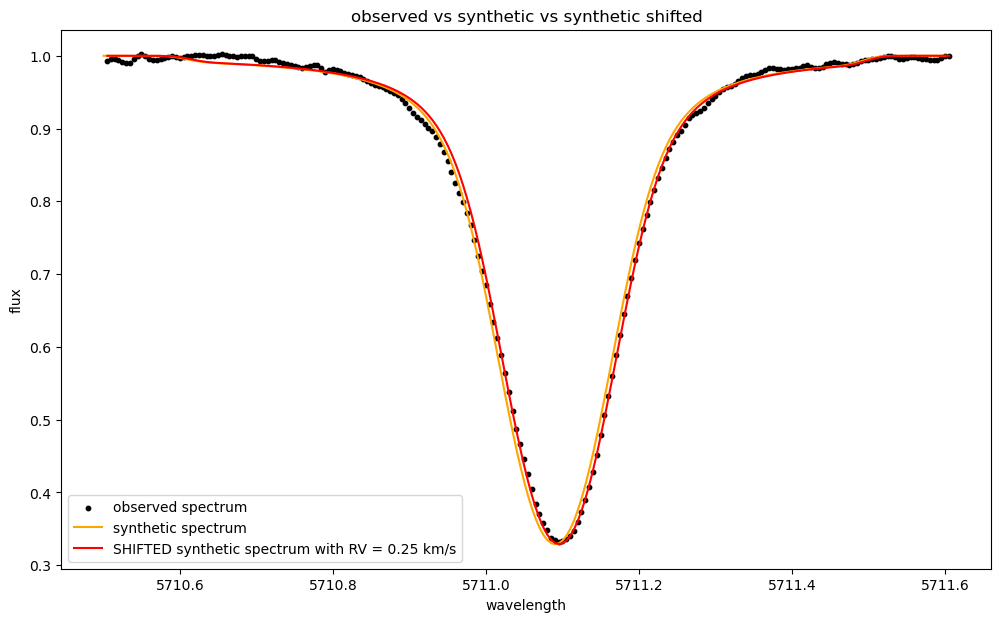

LOWEST CHI2: Mg abundance: 0.16 with chi2=0.020604078779284895
Mg abundance: -1.0, chi2: 7.088279828387469
Mg abundance: -0.99, chi2: 7.011511300537801
Mg abundance: -0.98, chi2: 6.934207998366521
Mg abundance: -0.97, chi2: 6.857059980596
Mg abundance: -0.96, chi2: 6.778708127518743
Mg abundance: -0.95, chi2: 6.7005255766853935
Mg abundance: -0.94, chi2: 6.621900422968777
Mg abundance: -0.93, chi2: 6.5430218675203955
Mg abundance: -0.92, chi2: 6.463715956497702
Mg abundance: -0.91, chi2: 6.384188672615554
Mg abundance: -0.9, chi2: 6.304780547058958
Mg abundance: -0.89, chi2: 6.2248145182594525
Mg abundance: -0.88, chi2: 6.1450355878548075
Mg abundance: -0.87, chi2: 6.064432595820332
Mg abundance: -0.86, chi2: 5.983772039749121
Mg abundance: -0.85, chi2: 5.90329583334157
Mg abundance: -0.84, chi2: 5.8224114421166275
Mg abundance: -0.83, chi2: 5.741457392983949
Mg abundance: -0.82, chi2: 5.660481230565144
Mg abundance: -0.81, chi2: 5.579394581390335
Mg abundance: -0.8, chi2: 5.4980543155

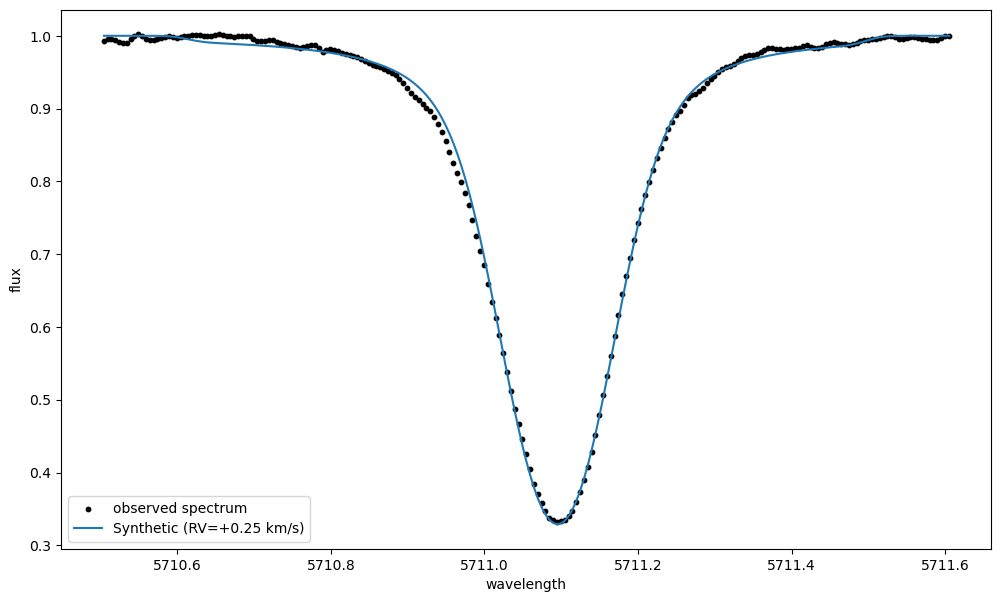

In [400]:
mask = (w_obs_k2229 >= 5710.5) & (w_obs_k2229 <= 5711.605)
w_obs_k2229_cut = w_obs_k2229[mask]
f_obs_k2229_cut = f_obs_k2229[mask]

best_rv_k2229, best_chi2_k2229 = rv_shift(rv_range, w_syn_k2229, f_syn_k2229, w_obs_k2229_cut, f_obs_k2229_cut)

#avg abundance
abundances1 = np.append(abundances, -0.065)
abundances1 = np.sort(abundances1)
w_syn_k2229_rv,f_syn_k2229_rv, best_chi2_k2229_rv, best_abund_k2229_rv = synth_compare_with_rv_shift("K2-229_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2229,f_obs_k2229,"r",vsini_k2229,limb_k2229, vmac_k2229,best_rv_k2229)

##### hd 136

In [204]:
vsini_hd136 = 2.55
vmac_hd136 = vmac[5]
limb_hd136 = 0.601

LOWEST CHI2: Mg abundance: 0.34 with chi2=0.055056646666796695
Mg abundance: -1.0, chi2: 6.253451888448553
Mg abundance: -0.99, chi2: 6.213239593758569
Mg abundance: -0.98, chi2: 6.172617726527727
Mg abundance: -0.97, chi2: 6.131334082117148
Mg abundance: -0.96, chi2: 6.089399522750734
Mg abundance: -0.95, chi2: 6.047252813745477
Mg abundance: -0.94, chi2: 6.004322459365769
Mg abundance: -0.93, chi2: 5.960517539090513
Mg abundance: -0.92, chi2: 5.9165015852558565
Mg abundance: -0.91, chi2: 5.871701774562455
Mg abundance: -0.9, chi2: 5.82611895378714
Mg abundance: -0.89, chi2: 5.780169919849099
Mg abundance: -0.88, chi2: 5.733889243015385
Mg abundance: -0.87, chi2: 5.686946465649018
Mg abundance: -0.86, chi2: 5.639303974801965
Mg abundance: -0.85, chi2: 5.590627485793442
Mg abundance: -0.84, chi2: 5.542440230867654
Mg abundance: -0.83, chi2: 5.492902065953973
Mg abundance: -0.82, chi2: 5.442955589951937
Mg abundance: -0.81, chi2: 5.39257661317727
Mg abundance: -0.8, chi2: 5.341402659843

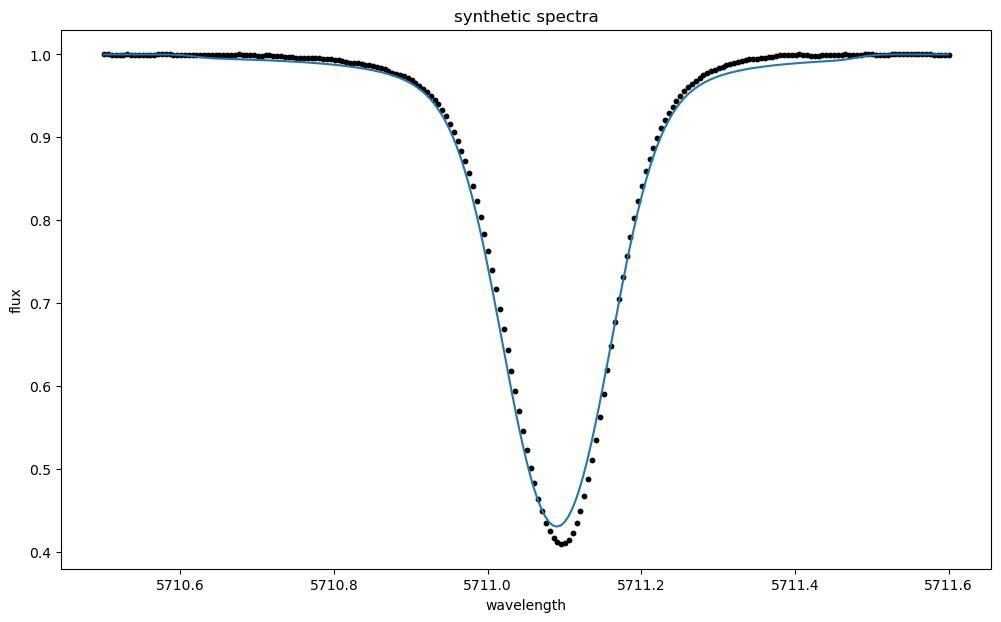

In [205]:
#avg abund
abundances1 = np.append(abundances, -0.133)
abundances1 = np.sort(abundances1)
w_syn_hd136,f_syn_hd136,best_chi2_hd136, best_abund_hd136 = synth_compare("HD136352_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd136,f_obs_hd136,"r",vsini_hd136,limb_hd136, vmac_hd136)

chi2 from flux diff without shift: 0.055056646666796695
LOWEST CHI2 SHIFTED for RV= 0.17 km/s with chi2=0.04431195281087279


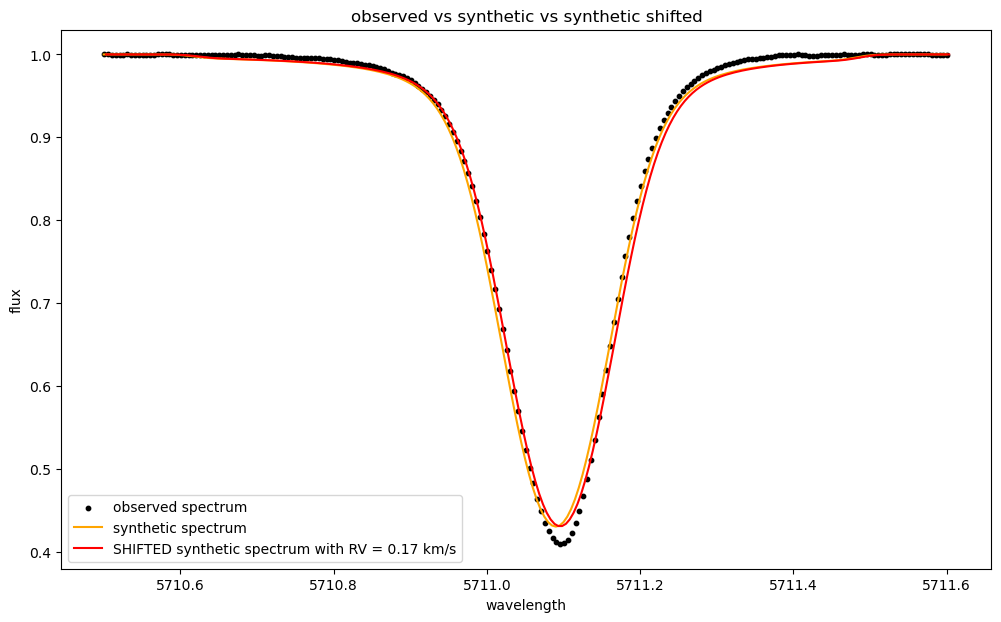

LOWEST CHI2: Mg abundance: 0.35 with chi2=0.04406931295106791
Mg abundance: -1.0, chi2: 6.254030553522323
Mg abundance: -0.99, chi2: 6.2138267328323735
Mg abundance: -0.98, chi2: 6.1732131508106525
Mg abundance: -0.97, chi2: 6.131937846117191
Mg abundance: -0.96, chi2: 6.090011571069135
Mg abundance: -0.95, chi2: 6.0478727393758165
Mg abundance: -0.94, chi2: 6.004950466468391
Mg abundance: -0.93, chi2: 5.961153467950844
Mg abundance: -0.92, chi2: 5.9171451959391135
Mg abundance: -0.91, chi2: 5.87235300815054
Mg abundance: -0.9, chi2: 5.8267775554837975
Mg abundance: -0.89, chi2: 5.780835850292827
Mg abundance: -0.88, chi2: 5.734562095480895
Mg abundance: -0.87, chi2: 5.687626022648777
Mg abundance: -0.86, chi2: 5.639990101173089
Mg abundance: -0.85, chi2: 5.591319905264363
Mg abundance: -0.84, chi2: 5.5431384317266845
Mg abundance: -0.83, chi2: 5.493605992181891
Mg abundance: -0.82, chi2: 5.443664798742836
Mg abundance: -0.81, chi2: 5.393290663010922
Mg abundance: -0.8, chi2: 5.3421212

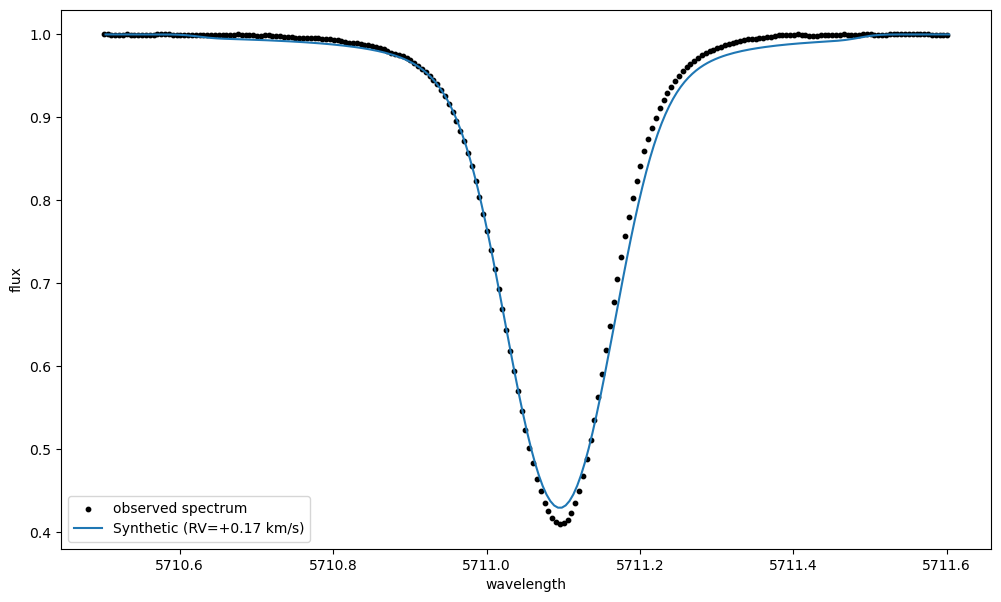

In [401]:
mask = (w_obs_hd136 >= 5710.5) & (w_obs_hd136 <= 5711.605)
w_obs_hd136_cut = w_obs_hd136[mask]
f_obs_hd136_cut = f_obs_hd136[mask]

best_rv_hd136, best_chi2_hd136 = rv_shift(rv_range, w_syn_hd136, f_syn_hd136, w_obs_hd136_cut, f_obs_hd136_cut)

#avg abund
abundances1 = np.append(abundances, -0.133)
abundances1 = np.sort(abundances1)
w_syn_hd136_rv,f_syn_hd136_rv,best_chi2_hd136_rv, best_abund_hd136_rv = synth_compare_with_rv_shift("HD136352_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd136,f_obs_hd136,"r",vsini_hd136,limb_hd136, vmac_hd136, best_rv_hd136)


##### toi 402

In [206]:
vsini_toi402 = 1.26 
vmac_toi402 = vmac[7]
limb_toi402 = 0.721

LOWEST CHI2: Mg abundance: 0.11 with chi2=0.3244131267143769
Mg abundance: -1.0, chi2: 6.8655573728002395
Mg abundance: -0.99, chi2: 6.784120646438987
Mg abundance: -0.98, chi2: 6.703208476057325
Mg abundance: -0.97, chi2: 6.622826180623946
Mg abundance: -0.96, chi2: 6.541137811809925
Mg abundance: -0.95, chi2: 6.460098843922333
Mg abundance: -0.94, chi2: 6.3785652470133005
Mg abundance: -0.93, chi2: 6.296790405657648
Mg abundance: -0.92, chi2: 6.2154449577638005
Mg abundance: -0.91, chi2: 6.13423846657343
Mg abundance: -0.9, chi2: 6.053231158335708
Mg abundance: -0.89, chi2: 5.971545902089882
Mg abundance: -0.88, chi2: 5.890274238918494
Mg abundance: -0.87, chi2: 5.809146430676948
Mg abundance: -0.86, chi2: 5.727829568029372
Mg abundance: -0.85, chi2: 5.647085204129949
Mg abundance: -0.84, chi2: 5.5657317657232435
Mg abundance: -0.83, chi2: 5.485125381920646
Mg abundance: -0.82, chi2: 5.404621223518976
Mg abundance: -0.81, chi2: 5.3237165199771
Mg abundance: -0.8, chi2: 5.243049169303

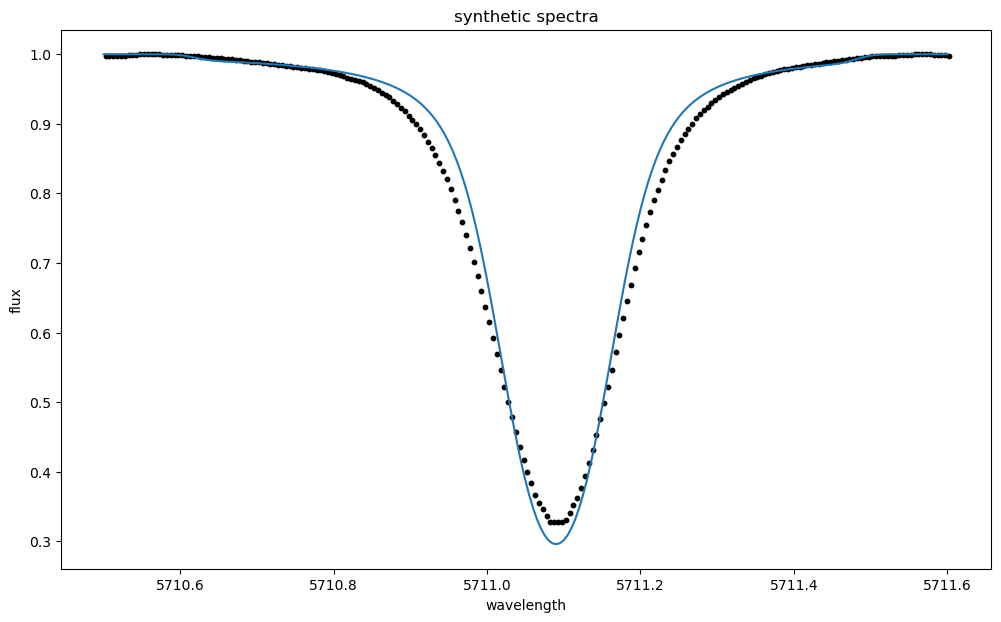

In [207]:
#avg abundance
abundances1 = np.append(abundances, 0.106)
abundances1 = np.sort(abundances1)
w_syn_toi402, f_syn_toi402, best_chi2_toi402, best_abund_toi402 = synth_compare("TOI-402_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi402,f_obs_toi402,"r",vsini_toi402,limb_toi402, vmac_toi402)

chi2 from flux diff without shift: 0.3244131267143769
LOWEST CHI2 SHIFTED for RV= 0.01 km/s with chi2=0.3005467526652294


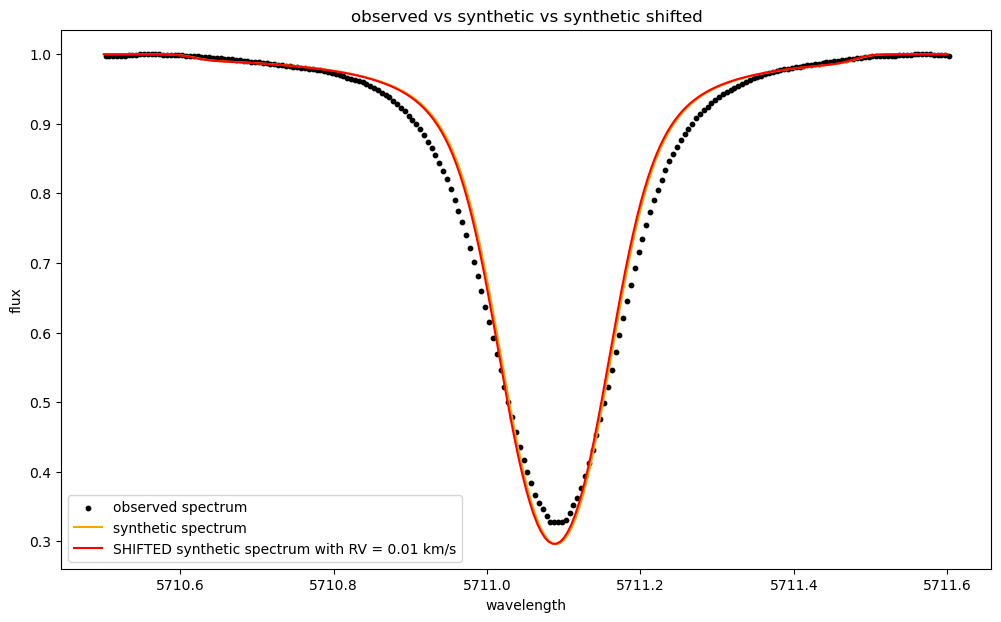

LOWEST CHI2: Mg abundance: 0.11 with chi2=0.30054675266728403
Mg abundance: -1.0, chi2: 6.865913655571734
Mg abundance: -0.99, chi2: 6.784463204906697
Mg abundance: -0.98, chi2: 6.703536118334052
Mg abundance: -0.97, chi2: 6.623137549929442
Mg abundance: -0.96, chi2: 6.541430451299499
Mg abundance: -0.95, chi2: 6.460371505966769
Mg abundance: -0.94, chi2: 6.378815665517194
Mg abundance: -0.93, chi2: 6.297016897450933
Mg abundance: -0.92, chi2: 6.215645480869945
Mg abundance: -0.91, chi2: 6.134411120558148
Mg abundance: -0.9, chi2: 6.053374075672346
Mg abundance: -0.89, chi2: 5.971656594930898
Mg abundance: -0.88, chi2: 5.890350622067977
Mg abundance: -0.87, chi2: 5.809186200273944
Mg abundance: -0.86, chi2: 5.727830368240898
Mg abundance: -0.85, chi2: 5.647045190691033
Mg abundance: -0.84, chi2: 5.565647653326528
Mg abundance: -0.83, chi2: 5.484995103543248
Mg abundance: -0.82, chi2: 5.404442286493243
Mg abundance: -0.81, chi2: 5.323486106687593
Mg abundance: -0.8, chi2: 5.242764361060

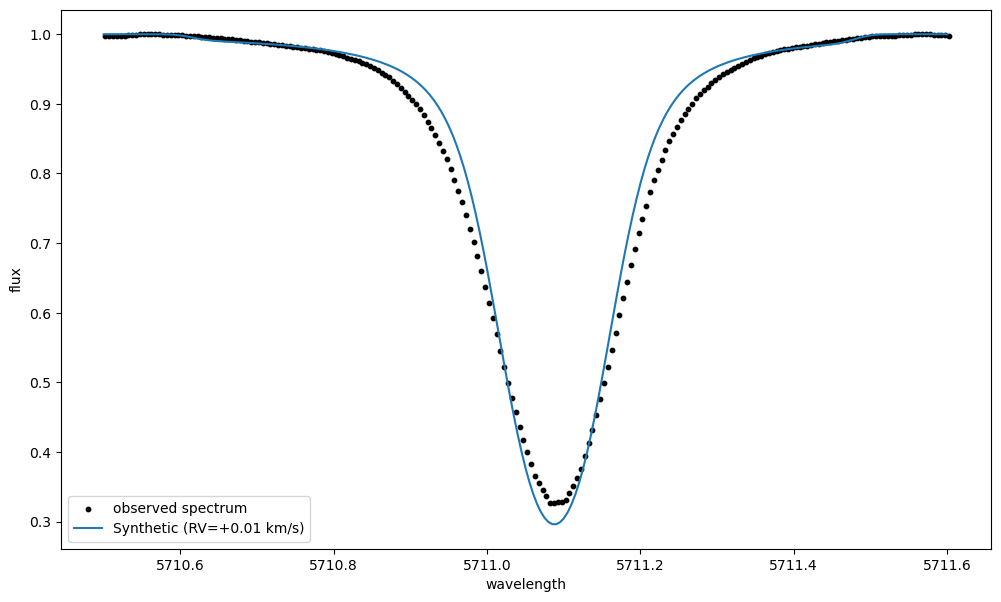

In [402]:
mask = (w_obs_toi402 >= 5710.5) & (w_obs_toi402 <= 5711.605)
w_obs_toi402_cut = w_obs_toi402[mask]
f_obs_toi402_cut = f_obs_toi402[mask]

best_rv_toi402, best_chi2_toi402 = rv_shift(rv_range, w_syn_toi402, f_syn_toi402, w_obs_toi402_cut, f_obs_toi402_cut)

#avg abundance
abundances1 = np.append(abundances, 0.106)
abundances1 = np.sort(abundances1)
w_syn_toi402_rv, f_syn_toi402_rv, best_chi2_toi402_rv, best_abund_toi402_rv = synth_compare_with_rv_shift("TOI-402_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi402,f_obs_toi402,"r",vsini_toi402,limb_toi402, vmac_toi402,best_rv_toi402)


##### hd213

In [222]:
vsini_hd213 = 3.5
vmac_hd213 = vmac[9]
limb_hd213 = 0.605

LOWEST CHI2: Mg abundance: 0.08 with chi2=0.034115443733223325
Mg abundance: -1.0, chi2: 4.400046524109857
Mg abundance: -0.99, chi2: 4.351090523049122
Mg abundance: -0.98, chi2: 4.302147344896895
Mg abundance: -0.97, chi2: 4.2520529949474835
Mg abundance: -0.96, chi2: 4.202095278213567
Mg abundance: -0.95, chi2: 4.151501448261469
Mg abundance: -0.94, chi2: 4.100511513632446
Mg abundance: -0.93, chi2: 4.049210768002004
Mg abundance: -0.92, chi2: 3.9980099196215653
Mg abundance: -0.91, chi2: 3.9459971572651105
Mg abundance: -0.9, chi2: 3.8935014919522954
Mg abundance: -0.89, chi2: 3.8408258412417022
Mg abundance: -0.88, chi2: 3.788088321847767
Mg abundance: -0.87, chi2: 3.734597539742954
Mg abundance: -0.86, chi2: 3.6812436221015825
Mg abundance: -0.85, chi2: 3.6273839767800493
Mg abundance: -0.84, chi2: 3.573770837881406
Mg abundance: -0.83, chi2: 3.5197361055554715
Mg abundance: -0.82, chi2: 3.465129682742551
Mg abundance: -0.81, chi2: 3.4106623633483633
Mg abundance: -0.8, chi2: 3.35

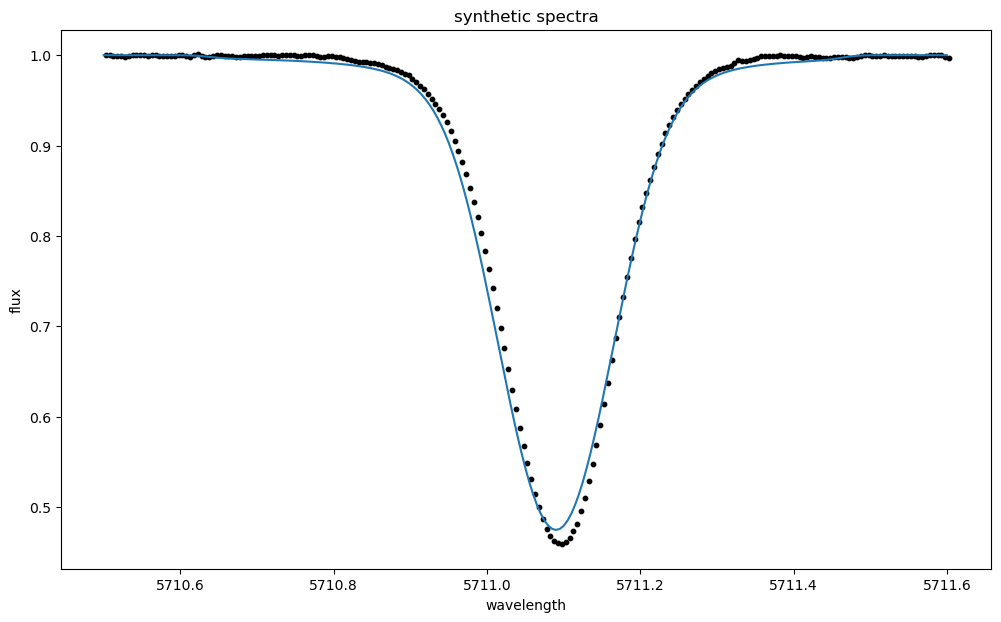

In [223]:
#avg abundance
abundances1 = np.append(abundances, -0.019)
abundances1 = np.sort(abundances1)
w_syn_hd213, f_syn_hd213, best_chi2_hd213, best_abund_hd213 = synth_compare("HD213885_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd213,f_obs_hd213,"r",vsini_hd213,limb_hd213, vmac_hd213)

chi2 from flux diff without shift: 0.034115443733223325
LOWEST CHI2 SHIFTED for RV= 0.23 km/s with chi2=0.03010325088828021


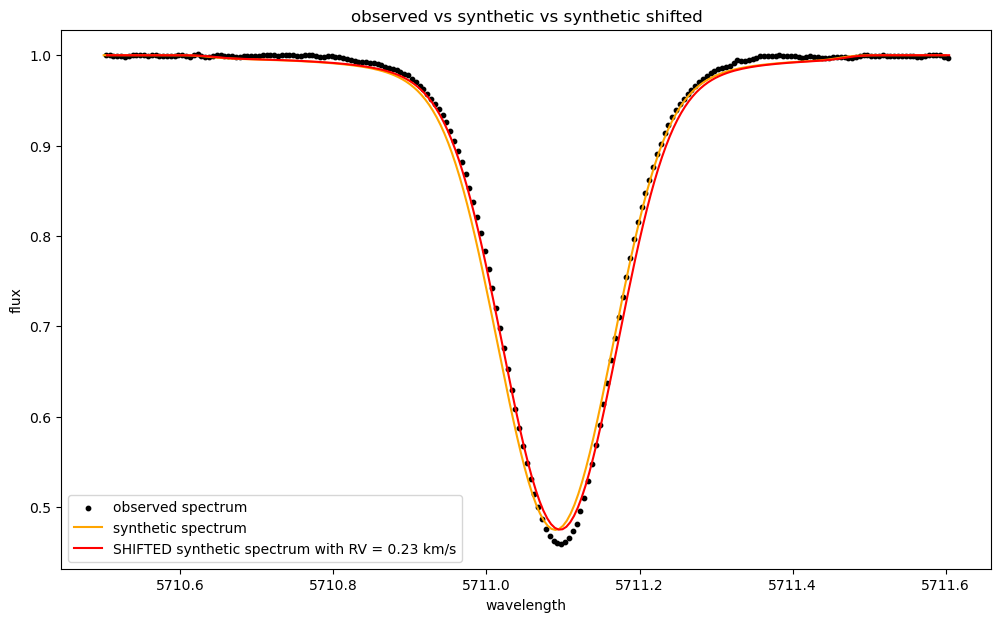

LOWEST CHI2: Mg abundance: 0.08 with chi2=0.03010325088114231
Mg abundance: -1.0, chi2: 4.400537056269239
Mg abundance: -0.99, chi2: 4.351586637170576
Mg abundance: -0.98, chi2: 4.302648782196604
Mg abundance: -0.97, chi2: 4.252559712272987
Mg abundance: -0.96, chi2: 4.202607028267487
Mg abundance: -0.95, chi2: 4.152018063479875
Mg abundance: -0.94, chi2: 4.101032808373501
Mg abundance: -0.93, chi2: 4.049736509980751
Mg abundance: -0.92, chi2: 3.9985397920434975
Mg abundance: -0.91, chi2: 3.9465310395707762
Mg abundance: -0.9, chi2: 3.894039041134547
Mg abundance: -0.89, chi2: 3.8413668391046993
Mg abundance: -0.88, chi2: 3.788632406234973
Mg abundance: -0.87, chi2: 3.735144384650727
Mg abundance: -0.86, chi2: 3.6817929156257545
Mg abundance: -0.85, chi2: 3.6279353072842566
Mg abundance: -0.84, chi2: 3.574323779970725
Mg abundance: -0.83, chi2: 3.5202903769815563
Mg abundance: -0.82, chi2: 3.465684779008942
Mg abundance: -0.81, chi2: 3.411217859436029
Mg abundance: -0.8, chi2: 3.356426

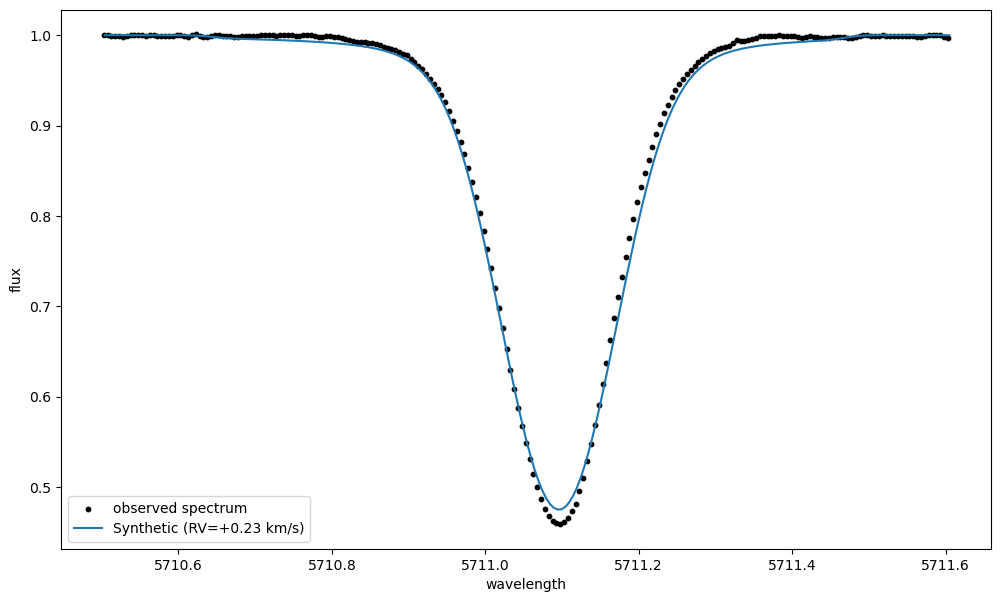

In [403]:
mask = (w_obs_hd213 >= 5710.5) & (w_obs_hd213 <= 5711.605)
w_obs_hd213_cut = w_obs_hd213[mask]
f_obs_hd213_cut = f_obs_hd213[mask]

best_rv_hd213, best_chi2_hd213 = rv_shift(rv_range, w_syn_hd213, f_syn_hd213, w_obs_hd213_cut, f_obs_hd213_cut)

#avg abundance
abundances1 = np.append(abundances, -0.019)
abundances1 = np.sort(abundances1)
w_syn_hd213_rv, f_syn_hd213_rv, best_chi2_hd213_rv, best_abund_hd213_rv = synth_compare_with_rv_shift("HD213885_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd213,f_obs_hd213,"r",vsini_hd213,limb_hd213, vmac_hd213, best_rv_hd213)


##### hd3167

In [224]:
vsini_hd3167 = 1.17
vmac_hd3167 = vmac[10]
limb_hd3167 = 0.693

LOWEST CHI2: Mg abundance: 0.19 with chi2=0.06606907844693151
Mg abundance: -1.0, chi2: 7.365759016742688
Mg abundance: -0.99, chi2: 7.287540392263331
Mg abundance: -0.98, chi2: 7.2085821168995885
Mg abundance: -0.97, chi2: 7.1297328174967465
Mg abundance: -0.96, chi2: 7.049714595686425
Mg abundance: -0.95, chi2: 6.970046738606524
Mg abundance: -0.94, chi2: 6.890213772369696
Mg abundance: -0.93, chi2: 6.809563706963351
Mg abundance: -0.92, chi2: 6.72898580269744
Mg abundance: -0.91, chi2: 6.648251280484498
Mg abundance: -0.9, chi2: 6.567177807040172
Mg abundance: -0.89, chi2: 6.485480923081857
Mg abundance: -0.88, chi2: 6.404389959289169
Mg abundance: -0.87, chi2: 6.322349774291687
Mg abundance: -0.86, chi2: 6.240512238218515
Mg abundance: -0.85, chi2: 6.158817186971547
Mg abundance: -0.84, chi2: 6.0765805551457905
Mg abundance: -0.83, chi2: 5.994911955787691
Mg abundance: -0.82, chi2: 5.912516248609677
Mg abundance: -0.81, chi2: 5.830178834687644
Mg abundance: -0.8, chi2: 5.7479940564

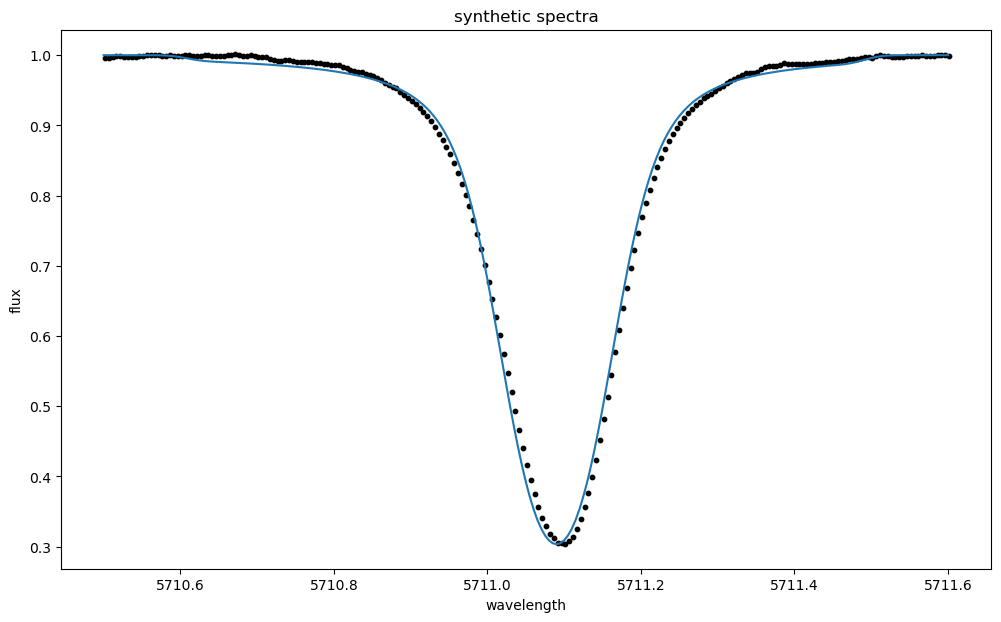

In [225]:
#avg abundance
abundances1 = np.append(abundances, 0.014)
abundances1 = np.sort(abundances1)
w_syn_hd3167, f_syn_hd3167, best_chi2_hd3167, best_abund_hd3167 = synth_compare("HD3167_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd3167,f_obs_hd3167,"r",vsini_hd3167,limb_hd3167, vmac_hd3167)

chi2 from flux diff without shift: 0.06606907844693151
LOWEST CHI2 SHIFTED for RV= 0.24 km/s with chi2=0.030699857251297365


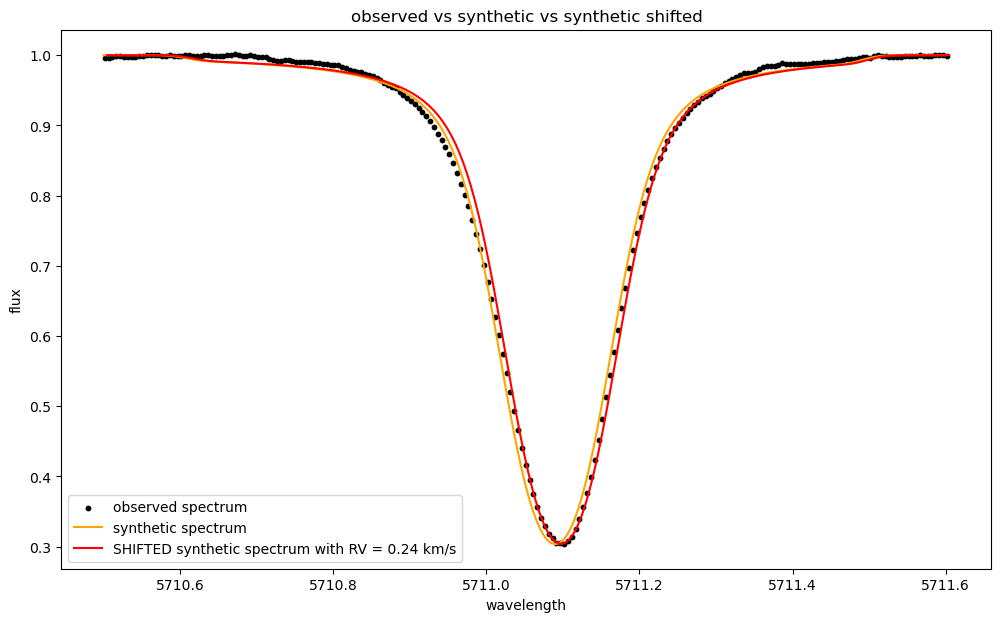

LOWEST CHI2: Mg abundance: 0.19 with chi2=0.030699857324425303
Mg abundance: -1.0, chi2: 7.3671851185251125
Mg abundance: -0.99, chi2: 7.2889373610750265
Mg abundance: -0.98, chi2: 7.209947067042255
Mg abundance: -0.97, chi2: 7.131063542840572
Mg abundance: -0.96, chi2: 7.051007606509964
Mg abundance: -0.95, chi2: 6.971299245349093
Mg abundance: -0.94, chi2: 6.891422977598526
Mg abundance: -0.93, chi2: 6.810726303551884
Mg abundance: -0.92, chi2: 6.730098520715753
Mg abundance: -0.91, chi2: 6.649310874812287
Mg abundance: -0.9, chi2: 6.568181214145079
Mg abundance: -0.89, chi2: 6.486424402237688
Mg abundance: -0.88, chi2: 6.405269786170091
Mg abundance: -0.87, chi2: 6.323162108634822
Mg abundance: -0.86, chi2: 6.241253879506639
Mg abundance: -0.85, chi2: 6.159484238156688
Mg abundance: -0.84, chi2: 6.077169178051405
Mg abundance: -0.83, chi2: 5.995418740651038
Mg abundance: -0.82, chi2: 5.912936359651589
Mg abundance: -0.81, chi2: 5.830508150047243
Mg abundance: -0.8, chi2: 5.748228639

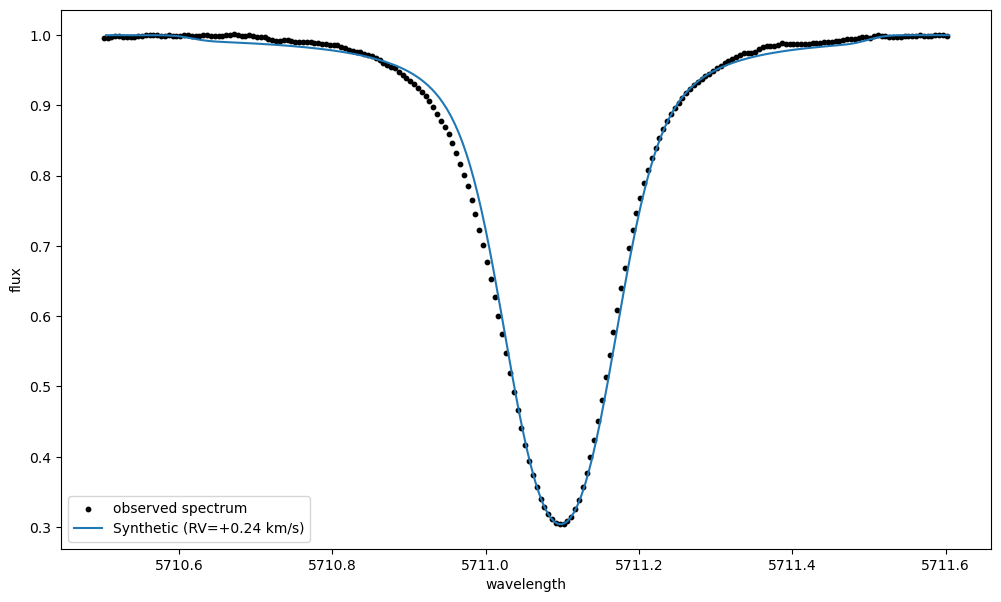

In [404]:
mask = (w_obs_hd3167 >= 5710.5) & (w_obs_hd3167 <= 5711.605)
w_obs_hd3167_cut = w_obs_hd3167[mask]
f_obs_hd3167_cut = f_obs_hd3167[mask]

best_rv_hd3167, best_chi2_hd3167 = rv_shift(rv_range, w_syn_hd3167, f_syn_hd3167, w_obs_hd3167_cut, f_obs_hd3167_cut)

#avg abundance
abundances1 = np.append(abundances, 0.014)
abundances1 = np.sort(abundances1)
w_syn_hd3167_rv, f_syn_hd3167_rv, best_chi2_hd3167_rv, best_abund_hd3167_rv = synth_compare_with_rv_shift("HD3167_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd3167,f_obs_hd3167,"r",vsini_hd3167,limb_hd3167, vmac_hd3167,best_rv_hd3167)

##### toi 496

In [226]:
vsini_toi496 = 2.03
vmac_toi496 = vmac[12]
limb_toi496 = 0.69

LOWEST CHI2: Mg abundance: 0.16 with chi2=0.05934721710282449
Mg abundance: -1.0, chi2: 7.11326572052231
Mg abundance: -0.99, chi2: 7.030192662657226
Mg abundance: -0.98, chi2: 6.9472658763207376
Mg abundance: -0.97, chi2: 6.8642792511718875
Mg abundance: -0.96, chi2: 6.78109835408711
Mg abundance: -0.95, chi2: 6.698028394278016
Mg abundance: -0.94, chi2: 6.61427418515568
Mg abundance: -0.93, chi2: 6.531559362694265
Mg abundance: -0.92, chi2: 6.4477578198570775
Mg abundance: -0.91, chi2: 6.365206664271966
Mg abundance: -0.9, chi2: 6.281648113587285
Mg abundance: -0.89, chi2: 6.198306102462357
Mg abundance: -0.88, chi2: 6.115351375796366
Mg abundance: -0.87, chi2: 6.032198882476353
Mg abundance: -0.86, chi2: 5.948907583942584
Mg abundance: -0.85, chi2: 5.8659123991618385
Mg abundance: -0.84, chi2: 5.783188527655633
Mg abundance: -0.83, chi2: 5.700392474209701
Mg abundance: -0.82, chi2: 5.617883023297786
Mg abundance: -0.81, chi2: 5.535152398316911
Mg abundance: -0.8, chi2: 5.45286861471

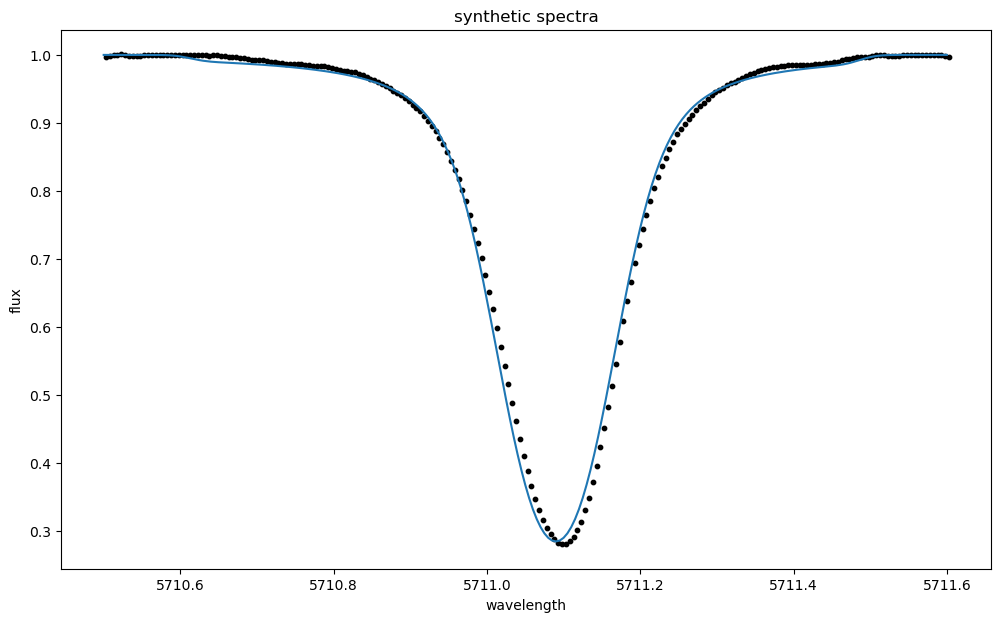

In [227]:
#avg abundance
abundances1 = np.append(abundances, 0.258)
abundances1 = np.sort(abundances1)
w_syn_toi469, f_syn_toi469, best_chi2_toi469, best_abund_toi469 = synth_compare("TOI-469_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi469,f_obs_toi469,"r",vsini_toi496,limb_toi496, vmac_toi496)

chi2 from flux diff without shift: 0.05934721710282449
LOWEST CHI2 SHIFTED for RV= 0.31 km/s with chi2=0.023340066752260403


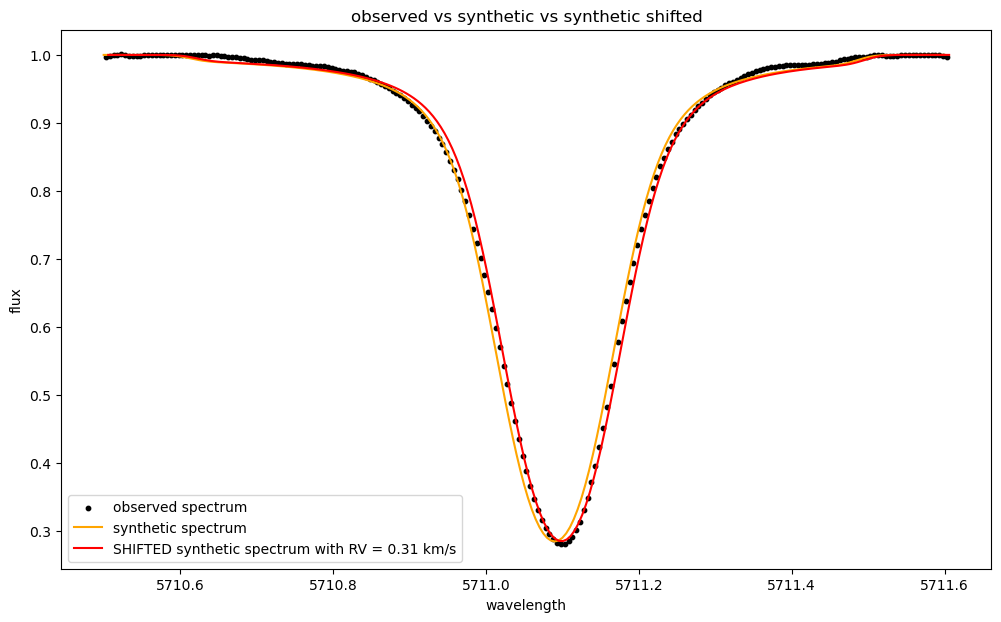

LOWEST CHI2: Mg abundance: 0.16 with chi2=0.023340066700659974
Mg abundance: -1.0, chi2: 7.114719005908013
Mg abundance: -0.99, chi2: 7.031596007685698
Mg abundance: -0.98, chi2: 6.948616648691621
Mg abundance: -0.97, chi2: 6.865574604566511
Mg abundance: -0.96, chi2: 6.782334949320139
Mg abundance: -0.95, chi2: 6.699203279568554
Mg abundance: -0.94, chi2: 6.61538368463835
Mg abundance: -0.93, chi2: 6.532601072321151
Mg abundance: -0.92, chi2: 6.448727078700061
Mg abundance: -0.91, chi2: 6.366101639334691
Mg abundance: -0.9, chi2: 6.282464230229123
Mg abundance: -0.89, chi2: 6.1990399778500835
Mg abundance: -0.88, chi2: 6.11600010849168
Mg abundance: -0.87, chi2: 6.032758527602381
Mg abundance: -0.86, chi2: 5.949373970817941
Mg abundance: -0.85, chi2: 5.866282163858065
Mg abundance: -0.84, chi2: 5.783458188000257
Mg abundance: -0.83, chi2: 5.700558225483477
Mg abundance: -0.82, chi2: 5.617940788094313
Mg abundance: -0.81, chi2: 5.535097909764614
Mg abundance: -0.8, chi2: 5.452698459035

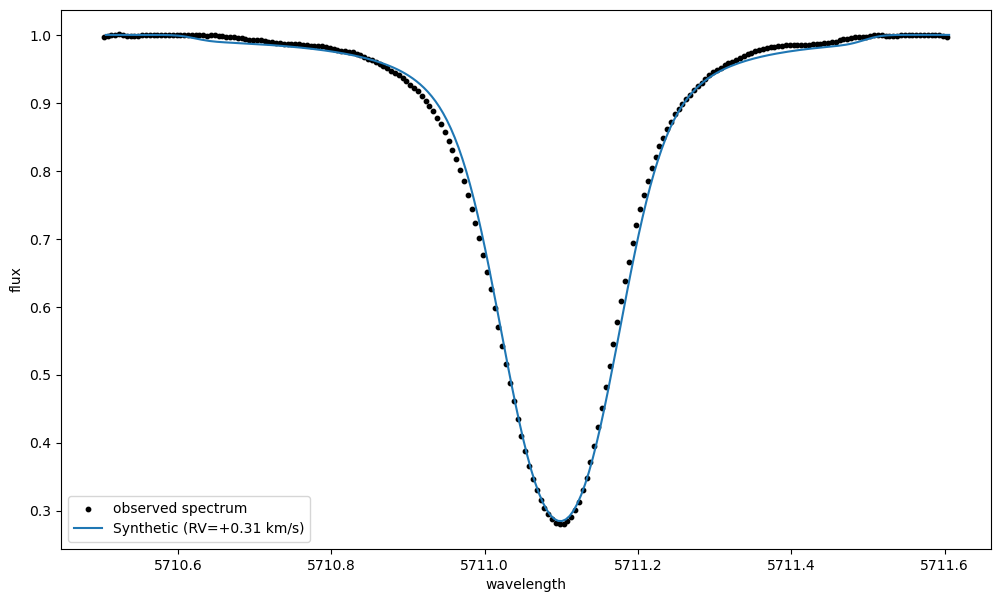

In [405]:
mask = (w_obs_toi469 >= 5710.5) & (w_obs_toi469 <= 5711.605)
w_obs_toi469_cut = w_obs_toi469[mask]
f_obs_toi469_cut = f_obs_toi469[mask]

best_rv_toi469, best_chi2_toi469 = rv_shift(rv_range, w_syn_toi469, f_syn_toi469, w_obs_toi469_cut, f_obs_toi469_cut)

#avg abundance
abundances1 = np.append(abundances, 0.258)
abundances1 = np.sort(abundances1)
w_syn_toi469_rv, f_syn_toi469_rv, best_chi2_toi469_rv, best_abund_toi469_rv = synth_compare_with_rv_shift("TOI-469_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi469,f_obs_toi469,"r",vsini_toi496,limb_toi496, vmac_toi496, best_rv_toi469)

##### k2-111

In [228]:
vsini_k2111 = 1.73
vmac_k2111 = vmac[13]
limb_k2111 = 0.601

LOWEST CHI2: Mg abundance: 0.38 with chi2=0.025601096026447407
Mg abundance: -1.0, chi2: 5.604365102068797
Mg abundance: -0.99, chi2: 5.576436035874931
Mg abundance: -0.98, chi2: 5.547840305447361
Mg abundance: -0.97, chi2: 5.518542953639322
Mg abundance: -0.96, chi2: 5.489030614594501
Mg abundance: -0.95, chi2: 5.458576176345531
Mg abundance: -0.94, chi2: 5.4280950961441805
Mg abundance: -0.93, chi2: 5.396839469769813
Mg abundance: -0.92, chi2: 5.365440380129999
Mg abundance: -0.91, chi2: 5.332949160989301
Mg abundance: -0.9, chi2: 5.300430390199342
Mg abundance: -0.89, chi2: 5.267209105396214
Mg abundance: -0.88, chi2: 5.233186406544475
Mg abundance: -0.87, chi2: 5.199206852985094
Mg abundance: -0.86, chi2: 5.164134913848108
Mg abundance: -0.85, chi2: 5.128851332068116
Mg abundance: -0.84, chi2: 5.092898375916322
Mg abundance: -0.83, chi2: 5.056486686274483
Mg abundance: -0.82, chi2: 5.019402689389628
Mg abundance: -0.81, chi2: 4.981892978673889
Mg abundance: -0.8, chi2: 4.9438526903

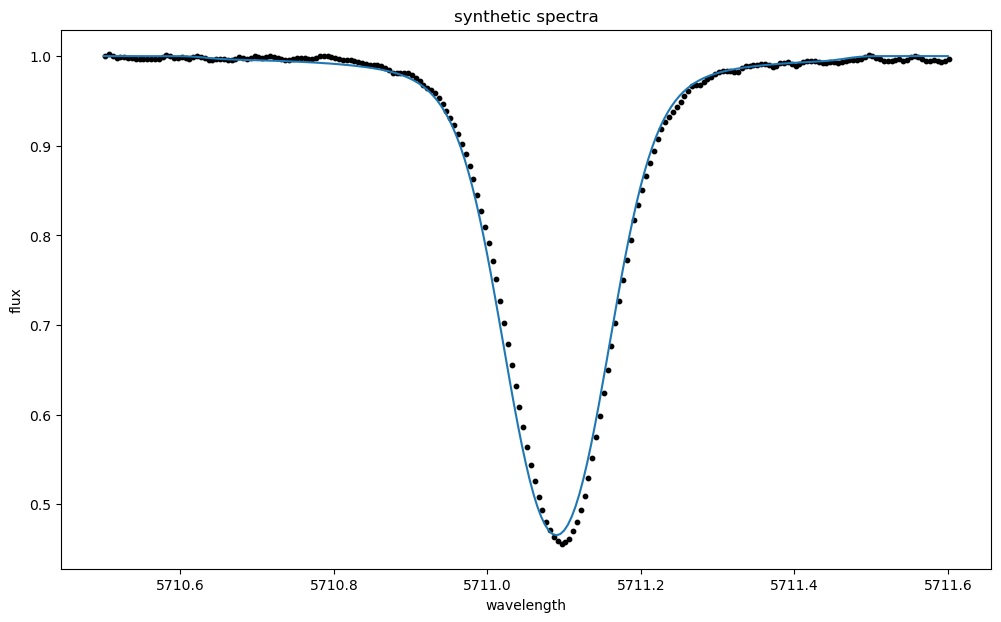

In [229]:
#avg abundance
abundances1 = np.append(abundances, -0.201)
abundances1 = np.sort(abundances1)
w_syn_k2111, f_syn_k2111, best_chi2_k2111, best_abund_k2111 = synth_compare("K2-111_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2111,f_obs_k2111,"r",vsini_k2111,limb_k2111, vmac_k2111)

chi2 from flux diff without shift: 0.025601096026447407
LOWEST CHI2 SHIFTED for RV= 0.26 km/s with chi2=0.007886864399500908


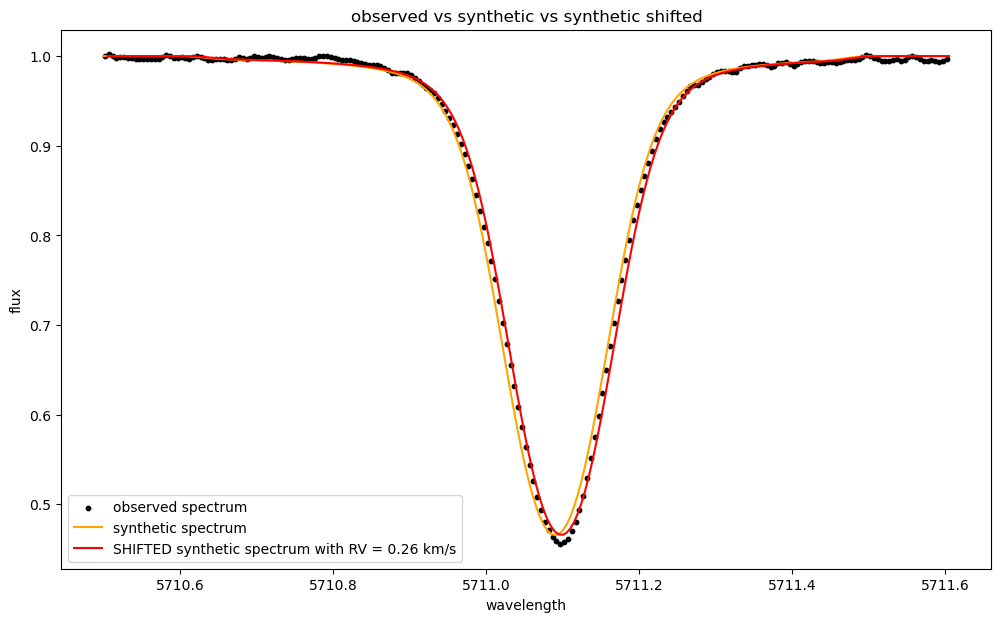

LOWEST CHI2: Mg abundance: 0.38 with chi2=0.007886864388945983
Mg abundance: -1.0, chi2: 5.604252301975762
Mg abundance: -0.99, chi2: 5.576317945984628
Mg abundance: -0.98, chi2: 5.547716752515556
Mg abundance: -0.97, chi2: 5.5184135613239125
Mg abundance: -0.96, chi2: 5.488895049611749
Mg abundance: -0.95, chi2: 5.458434196775827
Mg abundance: -0.94, chi2: 5.427946472642132
Mg abundance: -0.93, chi2: 5.396683848573498
Mg abundance: -0.92, chi2: 5.365277365937644
Mg abundance: -0.91, chi2: 5.332778602101511
Mg abundance: -0.9, chi2: 5.300251875330225
Mg abundance: -0.89, chi2: 5.267022077488383
Mg abundance: -0.88, chi2: 5.232990593967181
Mg abundance: -0.87, chi2: 5.199001966901863
Mg abundance: -0.86, chi2: 5.163920185688601
Mg abundance: -0.85, chi2: 5.128626639153269
Mg abundance: -0.84, chi2: 5.092663154985695
Mg abundance: -0.83, chi2: 5.056240438292119
Mg abundance: -0.82, chi2: 5.019144941862287
Mg abundance: -0.81, chi2: 4.9816230570665025
Mg abundance: -0.8, chi2: 4.943570155

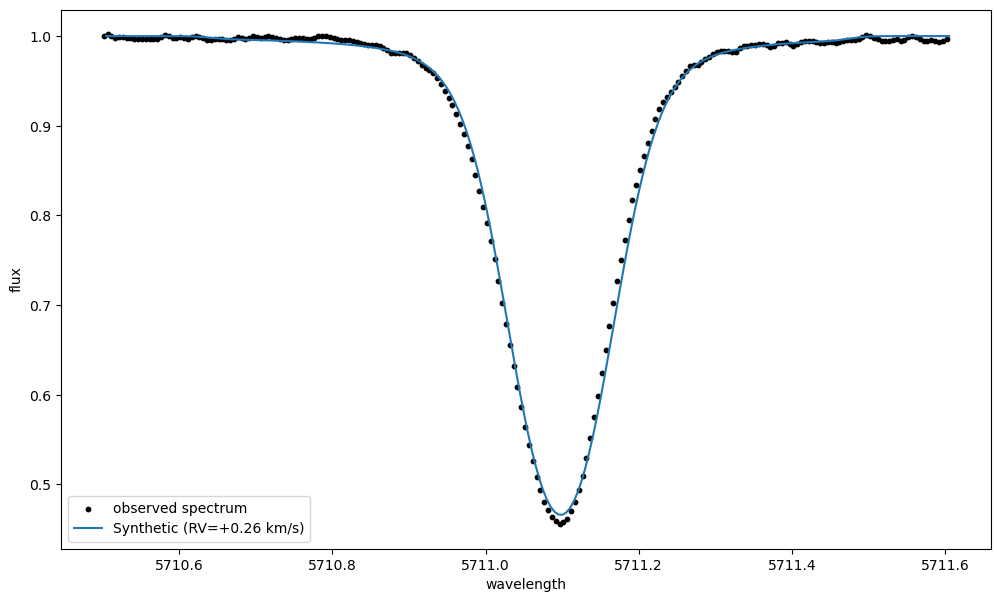

In [406]:
mask = (w_obs_k2111 >= 5710.5) & (w_obs_k2111 <= 5711.605)
w_obs_k2111_cut = w_obs_k2111[mask]
f_obs_k2111_cut = f_obs_k2111[mask]

best_rv_k2111, best_chi2_k2111 = rv_shift(rv_range, w_syn_k2111, f_syn_k2111, w_obs_k2111_cut, f_obs_k2111_cut)

#avg abundance
abundances1 = np.append(abundances, -0.201)
abundances1 = np.sort(abundances1)
w_syn_k2111_rv, f_syn_k2111_rv, best_chi2_k2111_rv, best_abund_k2111_rv = synth_compare_with_rv_shift("K2-111_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2111,f_obs_k2111,"r",vsini_k2111,limb_k2111, vmac_k2111, best_rv_k2111)


##### k2-131

In [230]:
vsini_k2131 = 4.17
vmac_k2131 = vmac[14]
limb_k2131 = 0.724

LOWEST CHI2: Mg abundance: 0.12 with chi2=0.03672236313176881
Mg abundance: -1.0, chi2: 6.023802660755411
Mg abundance: -0.99, chi2: 5.954243216961113
Mg abundance: -0.98, chi2: 5.884937244135273
Mg abundance: -0.97, chi2: 5.814478816091564
Mg abundance: -0.96, chi2: 5.744223555381423
Mg abundance: -0.95, chi2: 5.673465665476997
Mg abundance: -0.94, chi2: 5.6030752292899155
Mg abundance: -0.93, chi2: 5.532040399883407
Mg abundance: -0.92, chi2: 5.4606989955187375
Mg abundance: -0.91, chi2: 5.389194617590702
Mg abundance: -0.9, chi2: 5.317482708076966
Mg abundance: -0.89, chi2: 5.245736593369001
Mg abundance: -0.88, chi2: 5.17370304489506
Mg abundance: -0.87, chi2: 5.101674216028156
Mg abundance: -0.86, chi2: 5.0294989426537855
Mg abundance: -0.85, chi2: 4.957319130185186
Mg abundance: -0.84, chi2: 4.884779515633168
Mg abundance: -0.83, chi2: 4.812580135428999
Mg abundance: -0.82, chi2: 4.7398704255527
Mg abundance: -0.81, chi2: 4.6675945453204495
Mg abundance: -0.8, chi2: 4.59534735142

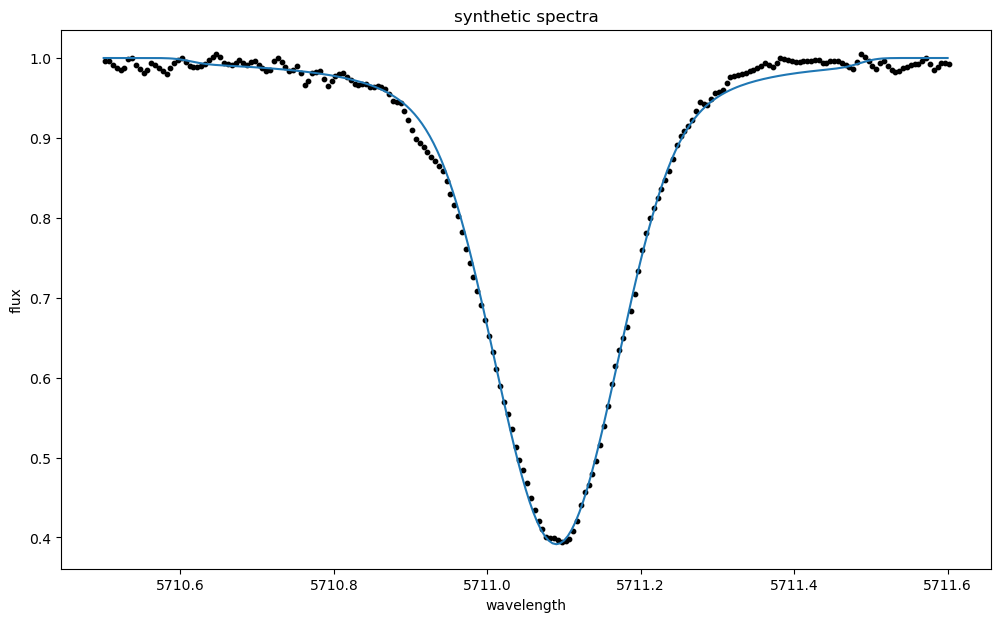

In [231]:
#avg abundance
abundances1 = np.append(abundances, -0.191)
abundances1 = np.sort(abundances1)
w_syn_k2131, f_syn_k2131, best_chi2_k2131, best_abund_k2131 = synth_compare("K2-131_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2131,f_obs_k2131,"r",vsini_k2131,limb_k2131, vmac_k2131)

chi2 from flux diff without shift: 0.03672236313176881
LOWEST CHI2 SHIFTED for RV= 0.01 km/s with chi2=0.029891491479676957


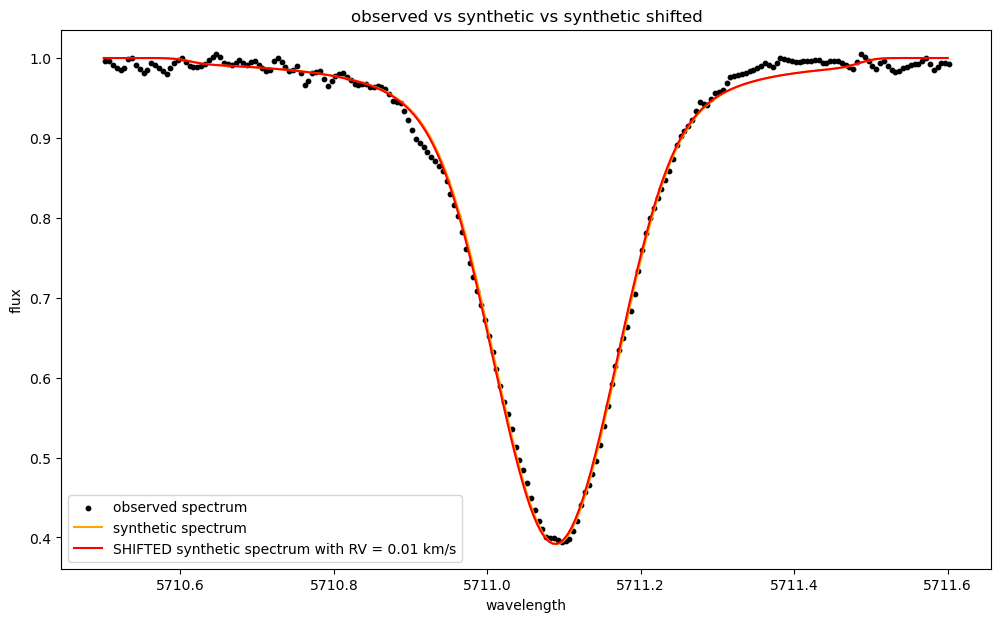

LOWEST CHI2: Mg abundance: 0.12 with chi2=0.029891491480889036
Mg abundance: -1.0, chi2: 6.023686157120401
Mg abundance: -0.99, chi2: 5.954125623712021
Mg abundance: -0.98, chi2: 5.884818605914246
Mg abundance: -0.97, chi2: 5.814358766695418
Mg abundance: -0.96, chi2: 5.744102077694868
Mg abundance: -0.95, chi2: 5.673341916598536
Mg abundance: -0.94, chi2: 5.602949856629282
Mg abundance: -0.93, chi2: 5.531912948380975
Mg abundance: -0.92, chi2: 5.460568681236808
Mg abundance: -0.91, chi2: 5.3890617684405955
Mg abundance: -0.9, chi2: 5.31734655776572
Mg abundance: -0.89, chi2: 5.245597021234565
Mg abundance: -0.88, chi2: 5.173559991416445
Mg abundance: -0.87, chi2: 5.101526758962485
Mg abundance: -0.86, chi2: 5.029347019526078
Mg abundance: -0.85, chi2: 4.95716230514062
Mg abundance: -0.84, chi2: 4.884617465643069
Mg abundance: -0.83, chi2: 4.812412460694285
Mg abundance: -0.82, chi2: 4.739696292114972
Mg abundance: -0.81, chi2: 4.667413800368791
Mg abundance: -0.8, chi2: 4.595159768617

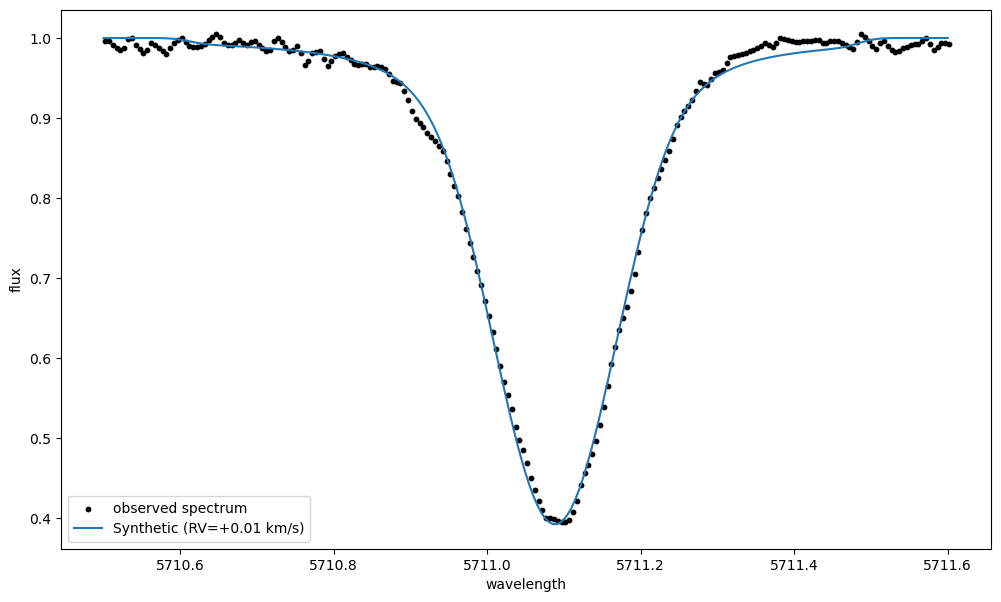

In [407]:
mask = (w_obs_k2131 >= 5710.5) & (w_obs_k2131 <= 5711.605)
w_obs_k2131_cut = w_obs_k2131[mask]
f_obs_k2131_cut = f_obs_k2131[mask]

best_rv_k2131, best_chi2_k2131 = rv_shift(rv_range, w_syn_k2131, f_syn_k2131, w_obs_k2131_cut, f_obs_k2131_cut)

#avg abundance
abundances1 = np.append(abundances, -0.191)
abundances1 = np.sort(abundances1)
w_syn_k2131_rv, f_syn_k2131_rv, best_chi2_k2131_rv, best_abund_k2131_rv = synth_compare_with_rv_shift("K2-131_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2131,f_obs_k2131,"r",vsini_k2131,limb_k2131, vmac_k2131,best_rv_k2131)


##### k2-265

In [232]:
vsini_k2265 = 2.61
vmac_k2265 = vmac[15]
limb_k2265 = 0.662

LOWEST CHI2: Mg abundance: 0.18 with chi2=0.055951181552608406
Mg abundance: -1.0, chi2: 6.7282682038387485
Mg abundance: -0.99, chi2: 6.655438970432089
Mg abundance: -0.98, chi2: 6.581672808292662
Mg abundance: -0.97, chi2: 6.508370854346215
Mg abundance: -0.96, chi2: 6.43442687075246
Mg abundance: -0.95, chi2: 6.3599925093629235
Mg abundance: -0.94, chi2: 6.285428688478354
Mg abundance: -0.93, chi2: 6.210180213379829
Mg abundance: -0.92, chi2: 6.135408184104742
Mg abundance: -0.91, chi2: 6.060079114422037
Mg abundance: -0.9, chi2: 5.984829509520406
Mg abundance: -0.89, chi2: 5.909239149295892
Mg abundance: -0.88, chi2: 5.833740980870282
Mg abundance: -0.87, chi2: 5.7576896504222015
Mg abundance: -0.86, chi2: 5.681370733939344
Mg abundance: -0.85, chi2: 5.605661572798388
Mg abundance: -0.84, chi2: 5.5294832320601595
Mg abundance: -0.83, chi2: 5.453271821567668
Mg abundance: -0.82, chi2: 5.376629063107268
Mg abundance: -0.81, chi2: 5.30064391694039
Mg abundance: -0.8, chi2: 5.224130659

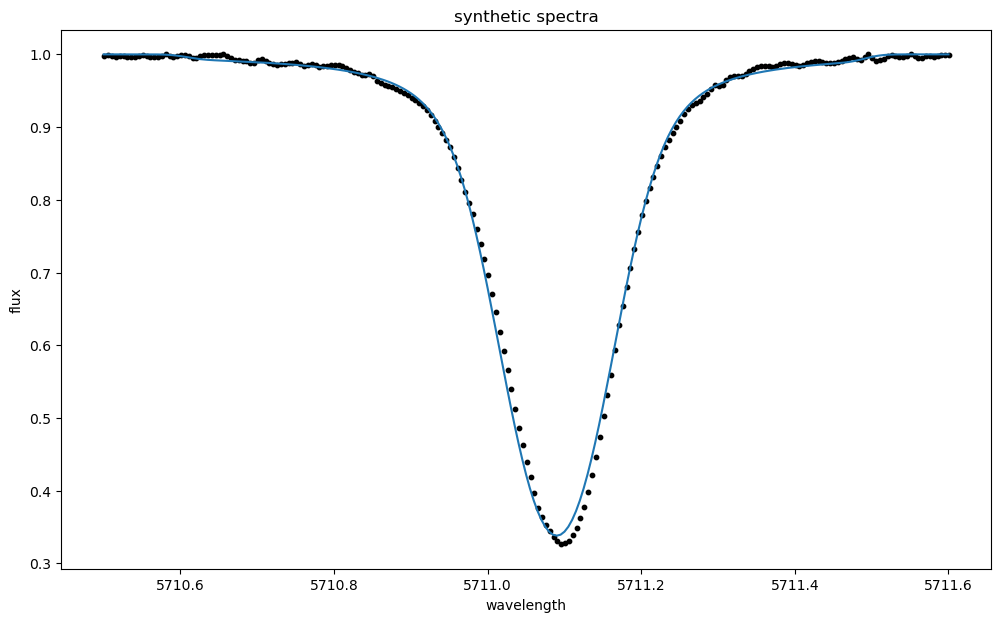

In [233]:
#avg abundance
abundances1 = np.append(abundances, 0.076)
abundances1 = np.sort(abundances1)
w_syn_k2265, f_syn_k2265, best_chi2_k2265, best_abund_k2265 = synth_compare("K2-265_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2265,f_obs_k2265,"r",vsini_k2265,limb_k2265, vmac_k2265)

chi2 from flux diff without shift: 0.055951181552608406
LOWEST CHI2 SHIFTED for RV= 0.2 km/s with chi2=0.027860920149297787


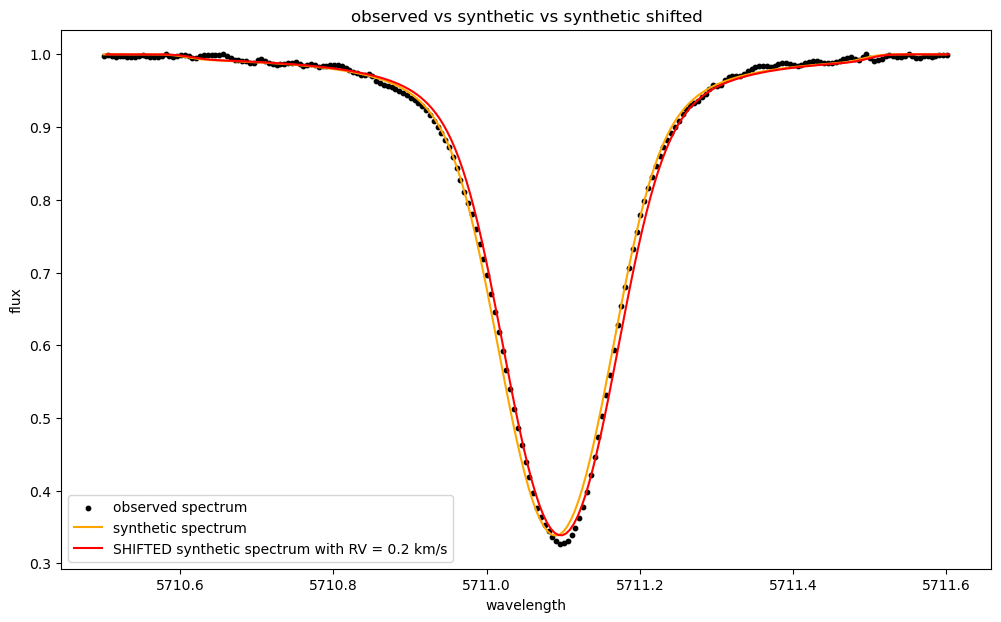

LOWEST CHI2: Mg abundance: 0.19 with chi2=0.027351472814451543
Mg abundance: -1.0, chi2: 6.728993628626499
Mg abundance: -0.99, chi2: 6.656138521352189
Mg abundance: -0.98, chi2: 6.582344660069835
Mg abundance: -0.97, chi2: 6.509013101690995
Mg abundance: -0.96, chi2: 6.435037546354258
Mg abundance: -0.95, chi2: 6.360569393172467
Mg abundance: -0.94, chi2: 6.28596956341294
Mg abundance: -0.93, chi2: 6.210682732093866
Mg abundance: -0.92, chi2: 6.135870137196396
Mg abundance: -0.91, chi2: 6.060498035755783
Mg abundance: -0.9, chi2: 5.985203403754544
Mg abundance: -0.89, chi2: 5.909565368962697
Mg abundance: -0.88, chi2: 5.834017126014427
Mg abundance: -0.87, chi2: 5.757912546791577
Mg abundance: -0.86, chi2: 5.681537864006843
Mg abundance: -0.85, chi2: 5.605770635861153
Mg abundance: -0.84, chi2: 5.529531546758742
Mg abundance: -0.83, chi2: 5.453255979398452
Mg abundance: -0.82, chi2: 5.376546306186919
Mg abundance: -0.81, chi2: 5.300491740163821
Mg abundance: -0.8, chi2: 5.223905388935

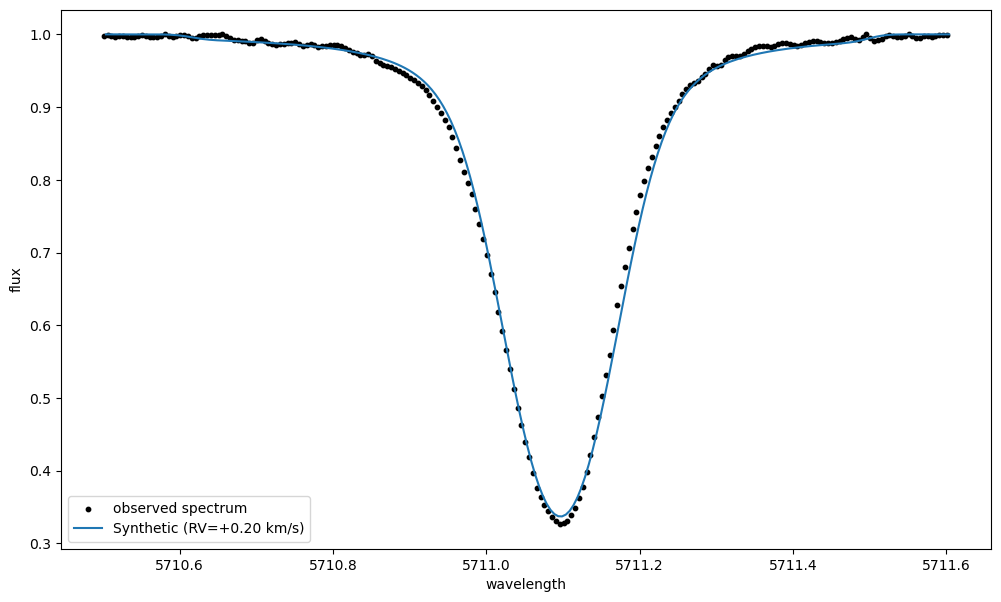

In [408]:
mask = (w_obs_k2265 >= 5710.5) & (w_obs_k2265 <= 5711.605)
w_obs_k2265_cut = w_obs_k2265[mask]
f_obs_k2265_cut = f_obs_k2265[mask]

best_rv_k2265, best_chi2_k2265 = rv_shift(rv_range, w_syn_k2265, f_syn_k2265, w_obs_k2265_cut, f_obs_k2265_cut)

#avg abundance
abundances1 = np.append(abundances, 0.076)
abundances1 = np.sort(abundances1)
w_syn_k2265_rv, f_syn_k2265_rv, best_chi2_k2265_rv, best_abund_k2265_rv = synth_compare_with_rv_shift("K2-265_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k2265,f_obs_k2265,"r",vsini_k2265,limb_k2265, vmac_k2265, best_rv_k2265)

##### hd 285

In [234]:
vsini_hd285 = 2.32
vmac_hd285 = vmac[16]
limb_hd285 = 0.662

LOWEST CHI2: Mg abundance: 0.06 with chi2=0.05048956463728825
Mg abundance: -1.0, chi2: 5.6857853797851865
Mg abundance: -0.99, chi2: 5.612662740073715
Mg abundance: -0.98, chi2: 5.54014081071237
Mg abundance: -0.97, chi2: 5.467111393651963
Mg abundance: -0.96, chi2: 5.393278374559645
Mg abundance: -0.95, chi2: 5.319794378043613
Mg abundance: -0.94, chi2: 5.245641784181685
Mg abundance: -0.93, chi2: 5.171401419568016
Mg abundance: -0.92, chi2: 5.097181944160357
Mg abundance: -0.91, chi2: 5.022815425736437
Mg abundance: -0.9, chi2: 4.948417944340072
Mg abundance: -0.89, chi2: 4.873949524880301
Mg abundance: -0.88, chi2: 4.799561038633932
Mg abundance: -0.87, chi2: 4.724279155713116
Mg abundance: -0.86, chi2: 4.649759392658458
Mg abundance: -0.85, chi2: 4.574983463475963
Mg abundance: -0.84, chi2: 4.50019441855626
Mg abundance: -0.83, chi2: 4.425897997941899
Mg abundance: -0.82, chi2: 4.351008145610556
Mg abundance: -0.81, chi2: 4.276224705956694
Mg abundance: -0.8, chi2: 4.2019648497877

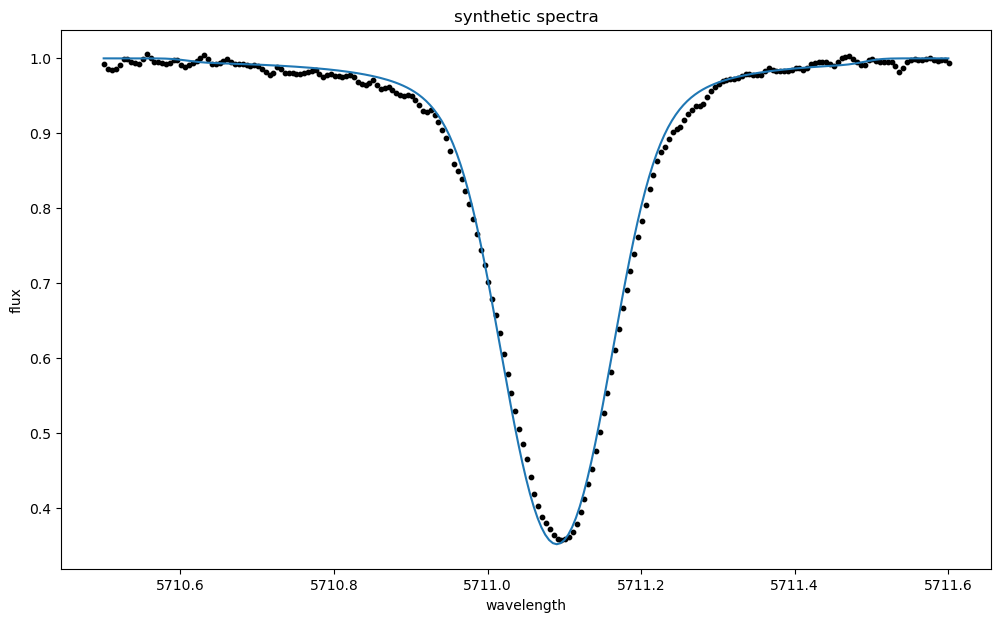

In [235]:
#avg abundance
abundances1 = np.append(abundances, 0.080)
abundances1 = np.sort(abundances1)
w_syn_hd285, f_syn_hd285, best_chi2_hd285, best_abund_hd285 = synth_compare("HD285181_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd285,f_obs_hd285,"r",vsini_hd285,limb_hd285, vmac_hd285)

chi2 from flux diff without shift: 0.05048956463728825
LOWEST CHI2 SHIFTED for RV= 0.18 km/s with chi2=0.0313664787369921


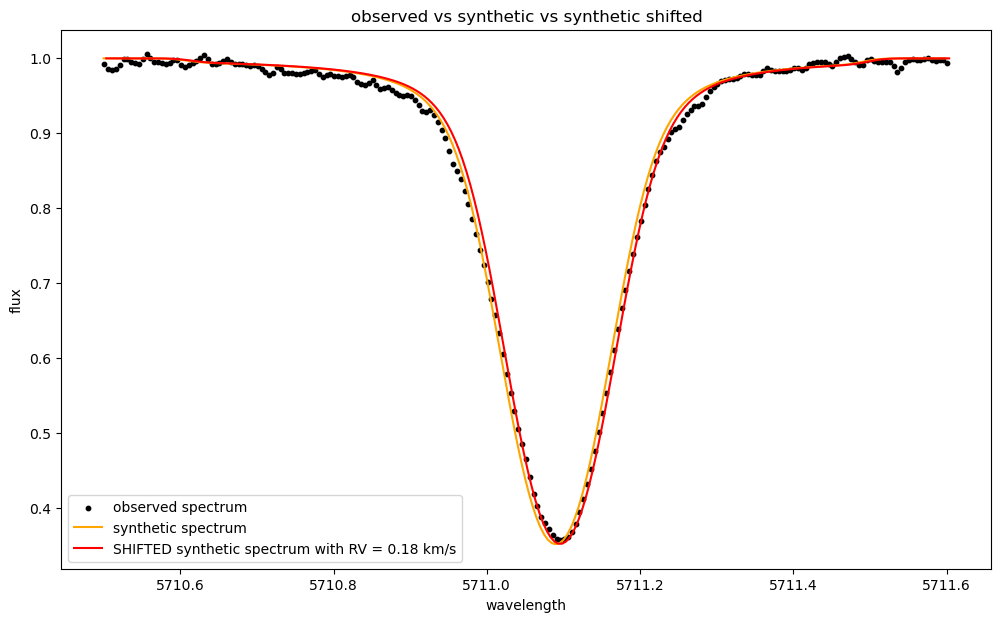

LOWEST CHI2: Mg abundance: 0.06 with chi2=0.03136647868776956
Mg abundance: -1.0, chi2: 5.686578222570536
Mg abundance: -0.99, chi2: 5.613439595835471
Mg abundance: -0.98, chi2: 5.540899930426651
Mg abundance: -0.97, chi2: 5.467850980764632
Mg abundance: -0.96, chi2: 5.393996606302895
Mg abundance: -0.95, chi2: 5.320489966737781
Mg abundance: -0.94, chi2: 5.246312210446924
Mg abundance: -0.93, chi2: 5.17204502512998
Mg abundance: -0.92, chi2: 5.097796589337416
Mg abundance: -0.91, chi2: 5.023399107112805
Mg abundance: -0.9, chi2: 4.9489684952559
Mg abundance: -0.89, chi2: 4.874464610633107
Mg abundance: -0.88, chi2: 4.800038853253817
Mg abundance: -0.87, chi2: 4.7247164893732805
Mg abundance: -0.86, chi2: 4.650154623049204
Mg abundance: -0.85, chi2: 4.575334162397022
Mg abundance: -0.84, chi2: 4.500497640593713
Mg abundance: -0.83, chi2: 4.426151770005154
Mg abundance: -0.82, chi2: 4.351209158514176
Mg abundance: -0.81, chi2: 4.276370312346384
Mg abundance: -0.8, chi2: 4.20205281783544

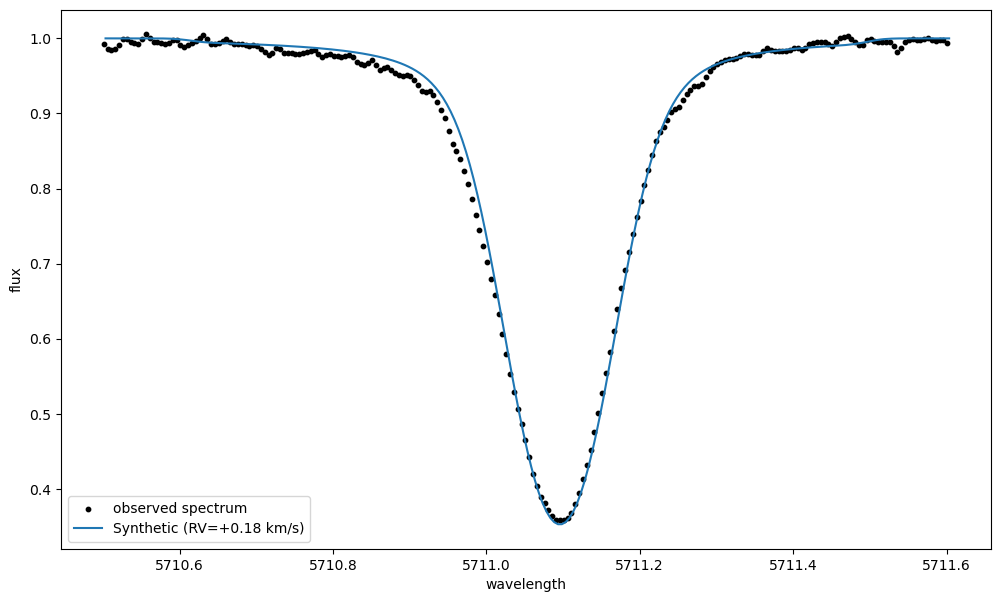

In [409]:
mask = (w_obs_hd285 >= 5710.5) & (w_obs_hd285 <= 5711.605)
w_obs_hd285_cut = w_obs_hd285[mask]
f_obs_hd285_cut = f_obs_hd285[mask]

best_rv_hd285, best_chi2_hd285 = rv_shift(rv_range, w_syn_hd285, f_syn_hd285, w_obs_hd285_cut, f_obs_hd285_cut)

#avg abundance
abundances1 = np.append(abundances, 0.080)
abundances1 = np.sort(abundances1)
w_syn_hd285_rv, f_syn_hd285_rv, best_chi2_hd285_rv, best_abund_hd285_rv = synth_compare_with_rv_shift("HD285181_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd285,f_obs_hd285,"r",vsini_hd285,limb_hd285, vmac_hd285, best_rv_hd285)


##### k2-38

In [236]:
vsini_k238 = 2.73
vmac_k238 = vmac[17]
limb_k238 = 0.661

LOWEST CHI2: Mg abundance: 0.12 with chi2=0.02762882688248635
Mg abundance: -1.0, chi2: 5.631982456015183
Mg abundance: -0.99, chi2: 5.560772772728502
Mg abundance: -0.98, chi2: 5.489349938919005
Mg abundance: -0.97, chi2: 5.417651064099777
Mg abundance: -0.96, chi2: 5.346327977522741
Mg abundance: -0.95, chi2: 5.274436156901368
Mg abundance: -0.94, chi2: 5.202631760157324
Mg abundance: -0.93, chi2: 5.130518818200612
Mg abundance: -0.92, chi2: 5.058803076031232
Mg abundance: -0.91, chi2: 4.986747202583134
Mg abundance: -0.9, chi2: 4.9147404492426885
Mg abundance: -0.89, chi2: 4.842750750221409
Mg abundance: -0.88, chi2: 4.770980691106393
Mg abundance: -0.87, chi2: 4.698909959648446
Mg abundance: -0.86, chi2: 4.626906937355271
Mg abundance: -0.85, chi2: 4.555260548614933
Mg abundance: -0.84, chi2: 4.4834440275388125
Mg abundance: -0.83, chi2: 4.412075618247057
Mg abundance: -0.82, chi2: 4.340671166195047
Mg abundance: -0.81, chi2: 4.269177139728997
Mg abundance: -0.8, chi2: 4.1979969052

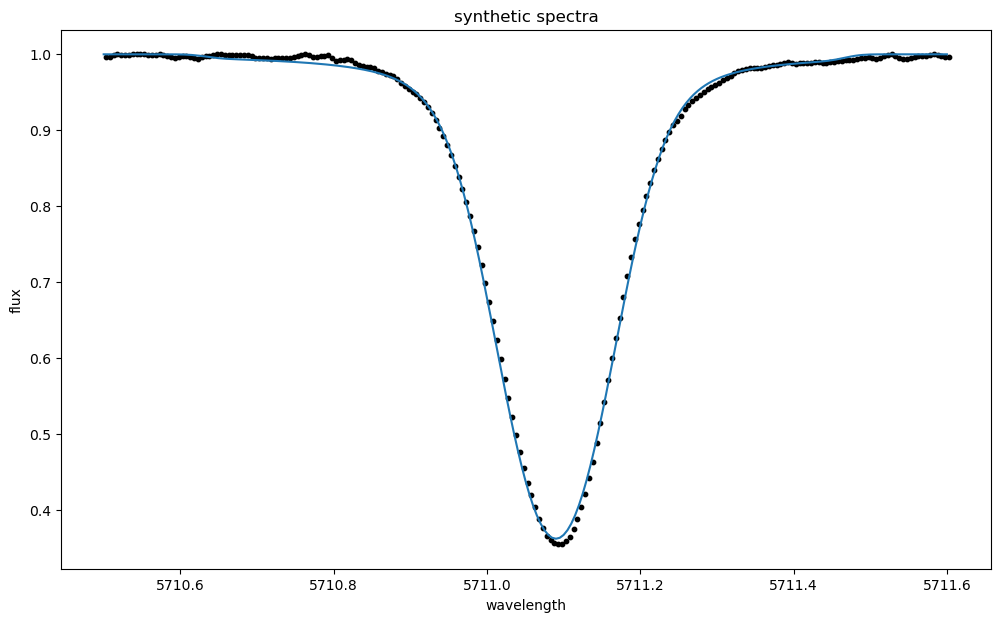

In [237]:
#avg abundance
abundances1 = np.append(abundances, 0.328)
abundances1 = np.sort(abundances1)
w_syn_k238, f_syn_k238, best_chi2_k238, best_abund_k238 = synth_compare("K2-38_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k238,f_obs_k238,"r",vsini_k238,limb_k238, vmac_k238)

chi2 from flux diff without shift: 0.02762882688248635
LOWEST CHI2 SHIFTED for RV= 0.05 km/s with chi2=0.01711589953595016


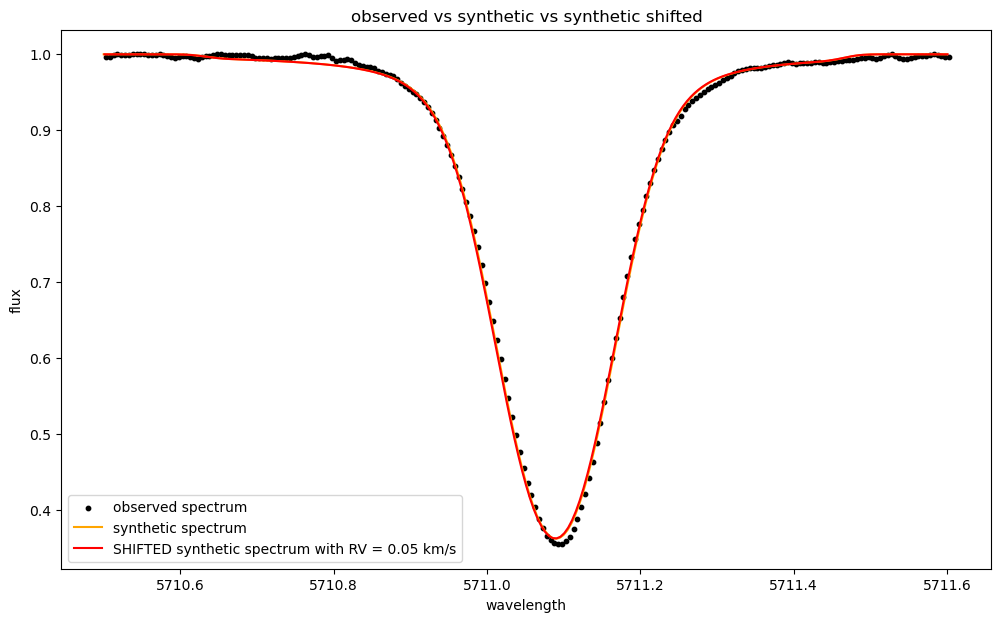

LOWEST CHI2: Mg abundance: 0.12 with chi2=0.01711589953921954
Mg abundance: -1.0, chi2: 5.631845140243077
Mg abundance: -0.99, chi2: 5.5606312886083336
Mg abundance: -0.98, chi2: 5.489203766499427
Mg abundance: -0.97, chi2: 5.417499653499654
Mg abundance: -0.96, chi2: 5.346170894429255
Mg abundance: -0.95, chi2: 5.27427283211752
Mg abundance: -0.94, chi2: 5.202461779595219
Mg abundance: -0.93, chi2: 5.130341280976577
Mg abundance: -0.92, chi2: 5.058617727853562
Mg abundance: -0.91, chi2: 4.9865531897646305
Mg abundance: -0.9, chi2: 4.914537185871648
Mg abundance: -0.89, chi2: 4.8425374359808
Mg abundance: -0.88, chi2: 4.770756572000277
Mg abundance: -0.87, chi2: 4.698674382833252
Mg abundance: -0.86, chi2: 4.626658850192901
Mg abundance: -0.85, chi2: 4.554999524531186
Mg abundance: -0.84, chi2: 4.483168884166655
Mg abundance: -0.83, chi2: 4.411785506496075
Mg abundance: -0.82, chi2: 4.3403651099826055
Mg abundance: -0.81, chi2: 4.268854412494278
Mg abundance: -0.8, chi2: 4.197656469958

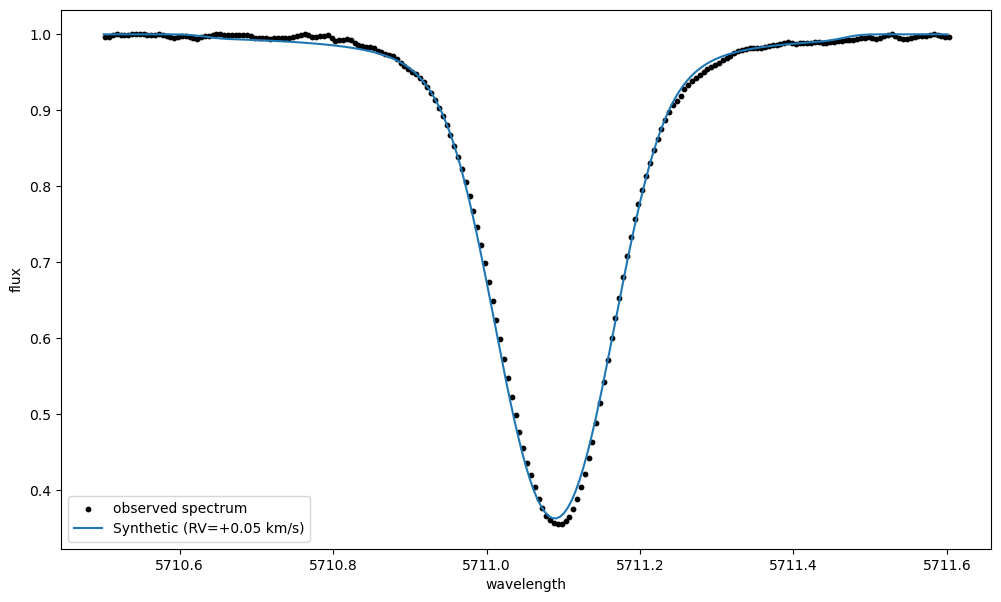

In [411]:
mask = (w_obs_k238 >= 5710.5) & (w_obs_k238 <= 5711.605)
w_obs_k238_cut = w_obs_k238[mask]
f_obs_k238_cut = f_obs_k238[mask]

best_rv_k238, best_chi2_k238 = rv_shift(rv_range, w_syn_k238, f_syn_k238, w_obs_k238_cut, f_obs_k238_cut)

#avg abundance
abundances1 = np.append(abundances, 0.328)
abundances1 = np.sort(abundances1)
w_syn_k238_rv, f_syn_k238_rv, best_chi2_k238_rv, best_abund_k238_rv = synth_compare_with_rv_shift("K2-38_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_k238,f_obs_k238,"r",vsini_k238,limb_k238, vmac_k238, best_rv_k238)

##### toi 238

In [ ]:
vsini_toi238 = #NO ROTATIONAL VELOCITY IN SIMBAD
vmac_toi238 = 
limb_toi238 = 

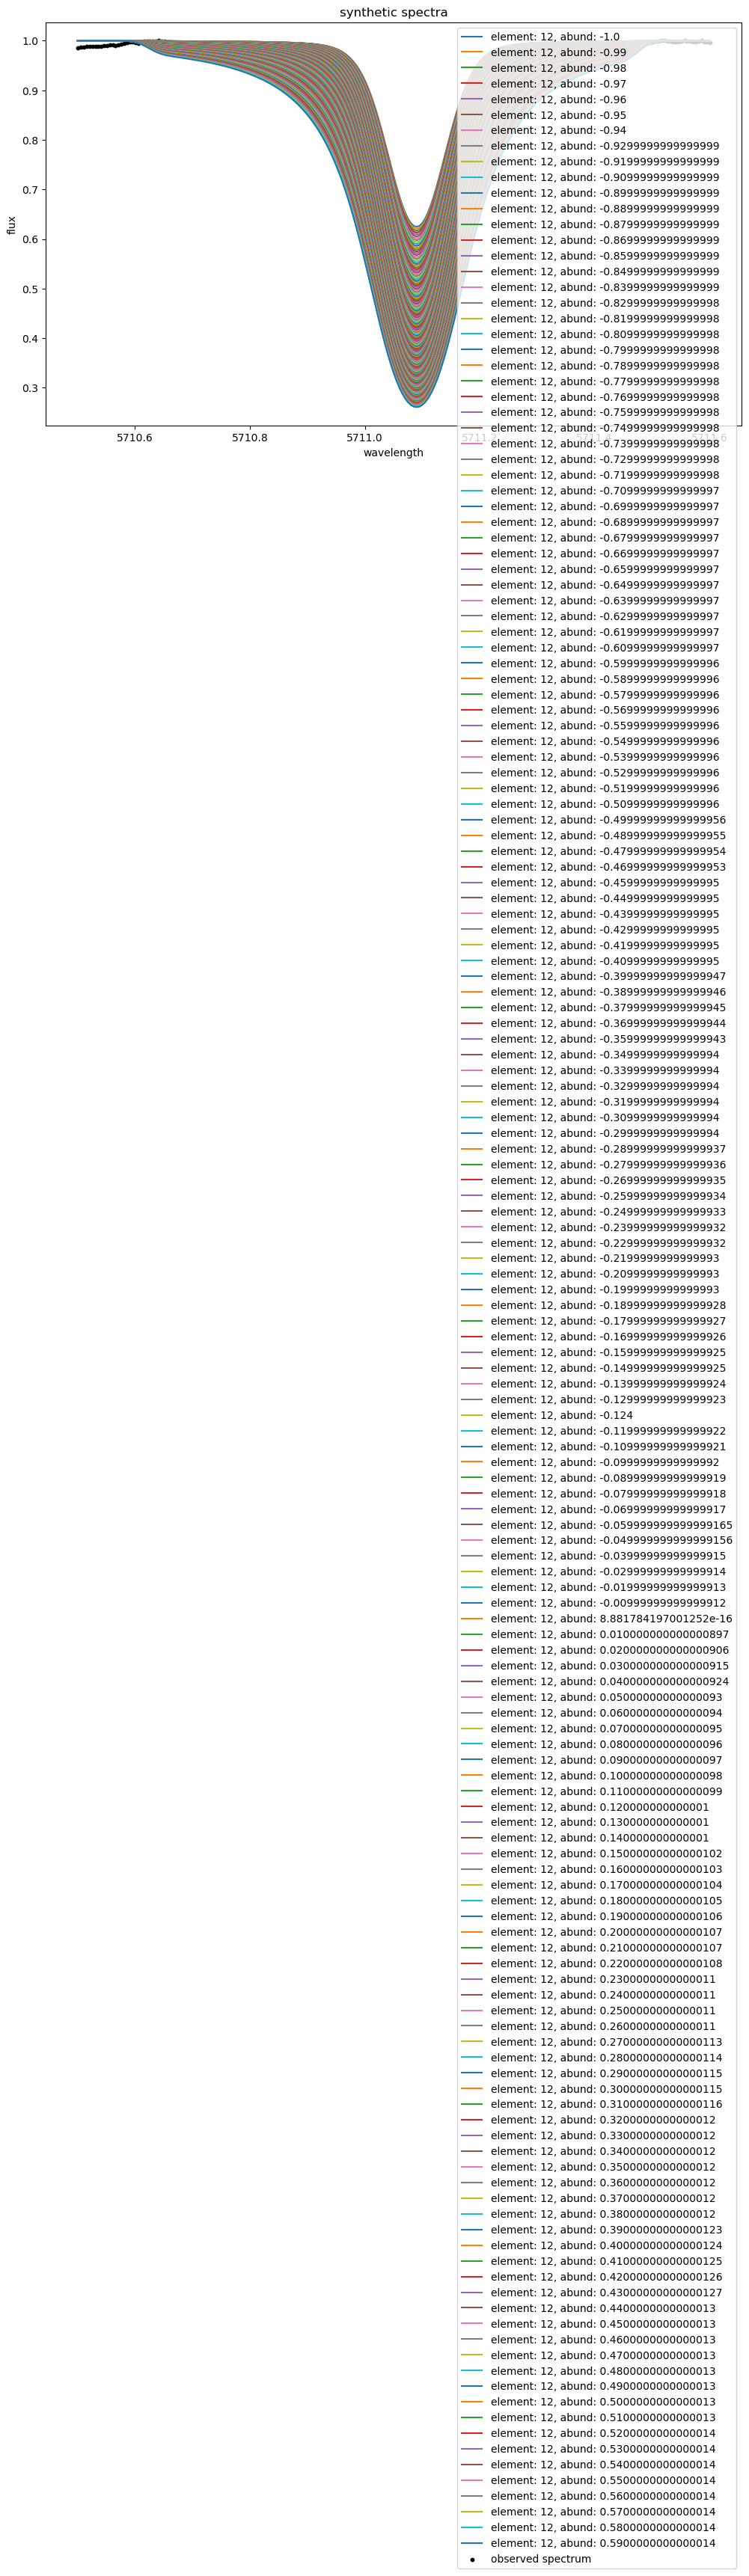

LOWEST CHI2: Mg abundance: 0.2300000000000011 with chi2=0.05006235153119109
Mg abundance: -1.0, chi2: 8.03720371784012
Mg abundance: -0.99, chi2: 7.960248638070913
Mg abundance: -0.98, chi2: 7.882089022086347
Mg abundance: -0.97, chi2: 7.804111834383653
Mg abundance: -0.96, chi2: 7.725927127607019
Mg abundance: -0.95, chi2: 7.647119509763723
Mg abundance: -0.94, chi2: 7.568029942737105
Mg abundance: -0.9299999999999999, chi2: 7.488229201053244
Mg abundance: -0.9199999999999999, chi2: 7.40835482513058
Mg abundance: -0.9099999999999999, chi2: 7.328359514818896
Mg abundance: -0.8999999999999999, chi2: 7.247684826173873
Mg abundance: -0.8899999999999999, chi2: 7.166688051883568
Mg abundance: -0.8799999999999999, chi2: 7.085692686852846
Mg abundance: -0.8699999999999999, chi2: 7.003958388294921
Mg abundance: -0.8599999999999999, chi2: 6.922461513100011
Mg abundance: -0.8499999999999999, chi2: 6.840768174306623
Mg abundance: -0.8399999999999999, chi2: 6.758615032575326
Mg abundance: -0.82999

In [ ]:
#avg abundance
abundances1 = np.append(abundances, -0.124)
abundances1 = np.sort(abundances1)
w_syn_toi238, f_syn_toi238, best_chi2_toi238, best_abund_toi238 = synth_compare("TOI-238_SINGLEHR11_ESPRESSO_2022_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi238,f_obs_toi238,"r",vsini_toi238,limb_toi238, vmac_toi238)

##### toi 561

In [238]:
vsini_toi561 = 1.52
vmac_toi561 = vmac[19]
limb_toi561 = 0.665

LOWEST CHI2: Mg abundance: 0.39 with chi2=0.09217200836021287
Mg abundance: -1.0, chi2: 7.963947154704166
Mg abundance: -0.99, chi2: 7.912460597168828
Mg abundance: -0.98, chi2: 7.8601907784320595
Mg abundance: -0.97, chi2: 7.807592255583298
Mg abundance: -0.96, chi2: 7.754006639327035
Mg abundance: -0.95, chi2: 7.699561162085204
Mg abundance: -0.94, chi2: 7.644902981595704
Mg abundance: -0.93, chi2: 7.589338665652223
Mg abundance: -0.92, chi2: 7.532833269188775
Mg abundance: -0.91, chi2: 7.4756804928031455
Mg abundance: -0.9, chi2: 7.418168873324052
Mg abundance: -0.89, chi2: 7.35969777208655
Mg abundance: -0.88, chi2: 7.300506944560225
Mg abundance: -0.87, chi2: 7.2412220097894
Mg abundance: -0.86, chi2: 7.181070416202636
Mg abundance: -0.85, chi2: 7.1197918537695255
Mg abundance: -0.84, chi2: 7.058101652908891
Mg abundance: -0.83, chi2: 6.9958806739304755
Mg abundance: -0.82, chi2: 6.932861964757963
Mg abundance: -0.81, chi2: 6.868906042668239
Mg abundance: -0.8, chi2: 6.80479092604

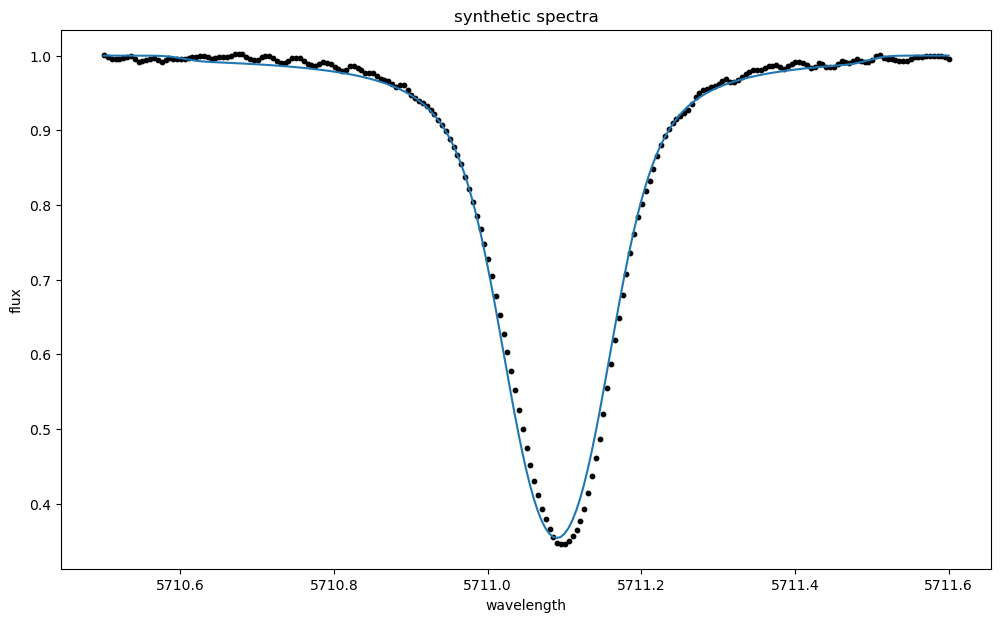

In [239]:
#avg abundance
abundances1 = np.append(abundances, -0.178)
abundances1 = np.sort(abundances1)
w_syn_toi561, f_syn_toi561, best_chi2_toi561, best_abund_toi561 = synth_compare("TOI-561_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi561,f_obs_toi561,"r",vsini_toi561,limb_toi561, vmac_toi561)

chi2 from flux diff without shift: 0.09217200836021287
LOWEST CHI2 SHIFTED for RV= 0.27 km/s with chi2=0.02769027391194078


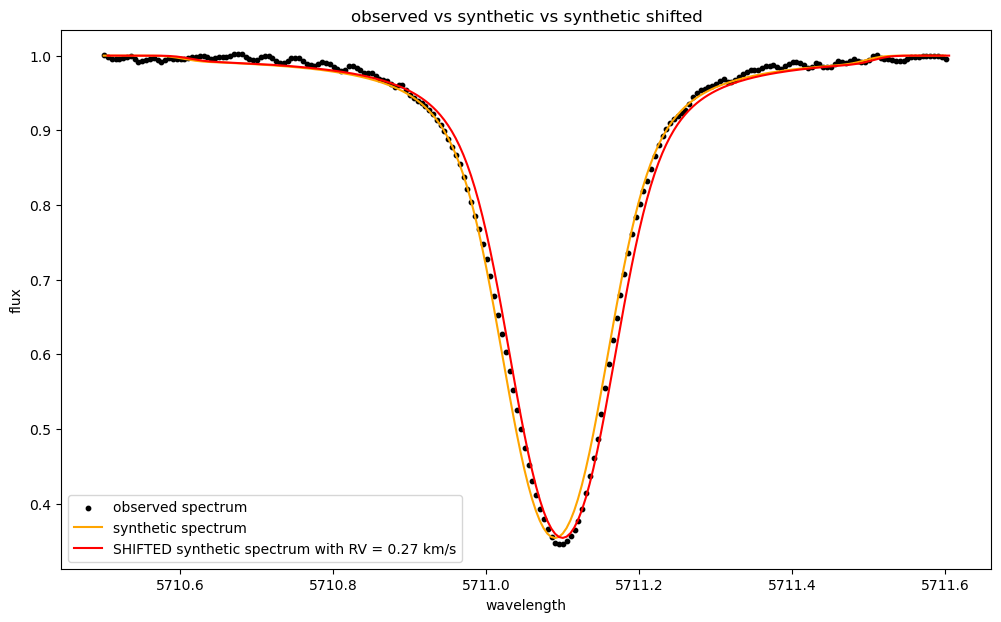

LOWEST CHI2: Mg abundance: 0.39 with chi2=0.027690273878159567
Mg abundance: -1.0, chi2: 7.963685094278874
Mg abundance: -0.99, chi2: 7.9121556564142
Mg abundance: -0.98, chi2: 7.859841144931243
Mg abundance: -0.97, chi2: 7.807195105353618
Mg abundance: -0.96, chi2: 7.7535598668342836
Mg abundance: -0.95, chi2: 7.699062177825132
Mg abundance: -0.94, chi2: 7.644349086462007
Mg abundance: -0.93, chi2: 7.588726709700157
Mg abundance: -0.92, chi2: 7.532160406749956
Mg abundance: -0.91, chi2: 7.474943993001729
Mg abundance: -0.9, chi2: 7.417365478754081
Mg abundance: -0.89, chi2: 7.358823680584641
Mg abundance: -0.88, chi2: 7.299559023822381
Mg abundance: -0.87, chi2: 7.240197248187875
Mg abundance: -0.86, chi2: 7.1799658947742735
Mg abundance: -0.85, chi2: 7.118602389178854
Mg abundance: -0.84, chi2: 7.056824357132467
Mg abundance: -0.83, chi2: 6.994510961876237
Mg abundance: -0.82, chi2: 6.93139600901836
Mg abundance: -0.81, chi2: 6.867339570170476
Mg abundance: -0.8, chi2: 6.803120360218

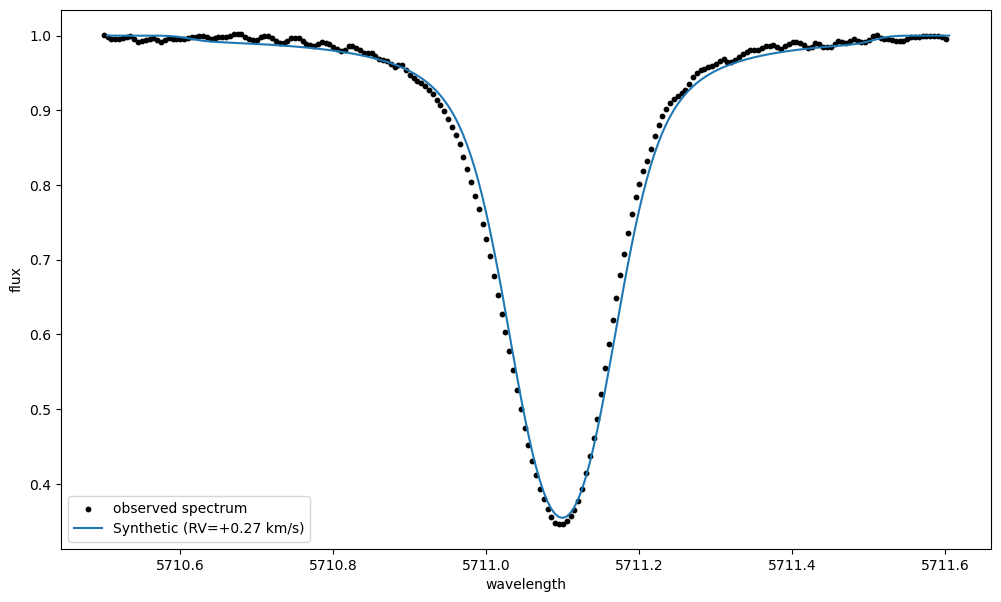

In [412]:
mask = (w_obs_toi561 >= 5710.5) & (w_obs_toi561 <= 5711.605)
w_obs_toi561_cut = w_obs_toi561[mask]
f_obs_toi561_cut = f_obs_toi561[mask]

best_rv_toi561, best_chi2_toi561 = rv_shift(rv_range, w_syn_toi561, f_syn_toi561, w_obs_toi561_cut, f_obs_toi561_cut)

#avg abundance
abundances1 = np.append(abundances, -0.178)
abundances1 = np.sort(abundances1)
w_syn_toi561_rv, f_syn_toi561_rv, best_chi2_toi561_rv, best_abund_toi561_rv = synth_compare_with_rv_shift("TOI-561_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_toi561,f_obs_toi561,"r",vsini_toi561,limb_toi561, vmac_toi561, best_rv_toi561)

##### wasp 47

In [240]:
vsini_wasp47 = 2.26
vmac_wasp47 = vmac[20]
limb_wasp47 = 0.688

LOWEST CHI2: Mg abundance: 0.11 with chi2=0.062090458401044823
Mg abundance: -1.0, chi2: 6.546779169596904
Mg abundance: -0.99, chi2: 6.462787409290087
Mg abundance: -0.98, chi2: 6.379466140087368
Mg abundance: -0.97, chi2: 6.295311503114484
Mg abundance: -0.96, chi2: 6.211445405627591
Mg abundance: -0.95, chi2: 6.127656782821058
Mg abundance: -0.94, chi2: 6.0442881075245305
Mg abundance: -0.93, chi2: 5.960255878767065
Mg abundance: -0.92, chi2: 5.877038076102454
Mg abundance: -0.91, chi2: 5.793631173547113
Mg abundance: -0.9, chi2: 5.710317307047151
Mg abundance: -0.89, chi2: 5.626668105735121
Mg abundance: -0.88, chi2: 5.543857525420072
Mg abundance: -0.87, chi2: 5.460662348642174
Mg abundance: -0.86, chi2: 5.378223156644667
Mg abundance: -0.85, chi2: 5.295215887837146
Mg abundance: -0.84, chi2: 5.213052136877919
Mg abundance: -0.83, chi2: 5.13120476622111
Mg abundance: -0.82, chi2: 5.049018222821836
Mg abundance: -0.81, chi2: 4.966869007439783
Mg abundance: -0.8, chi2: 4.88565953606

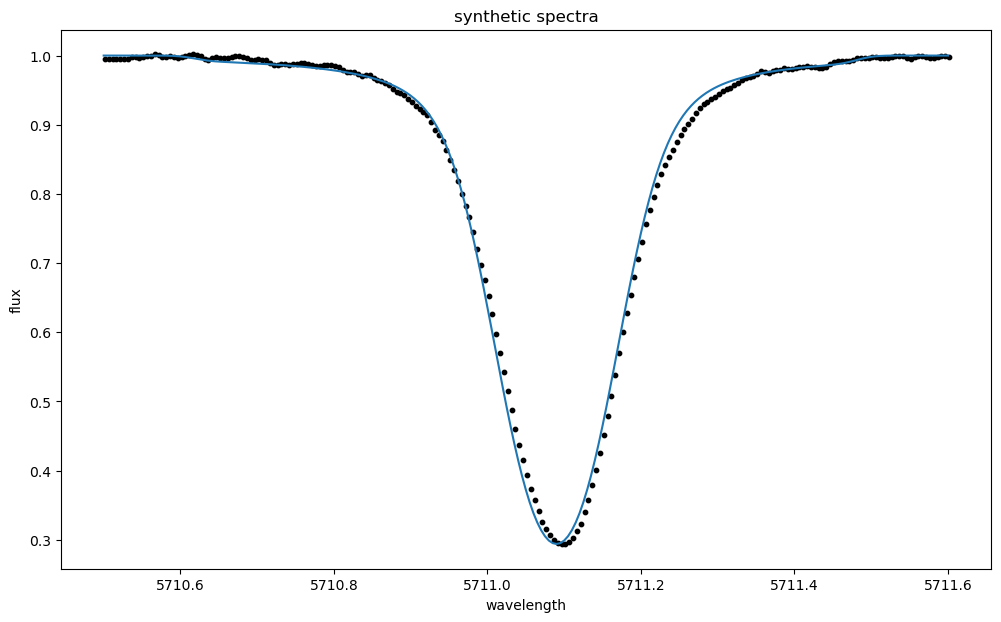

In [ ]:
#avg abundance
abundances1 = np.append(abundances, 0.415)
abundances1 = np.sort(abundances1)
w_syn_wasp47, f_syn_wasp47, best_chi2_wasp47, best_abund_wasp47 = synth_compare("WASP-47_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_wasp47,f_obs_wasp47,"r",vsini_wasp47,limb_wasp47, vmac_wasp47)

chi2 from flux diff without shift: 0.062090458401044823
LOWEST CHI2 SHIFTED for RV= 0.26 km/s with chi2=0.01846719051510204


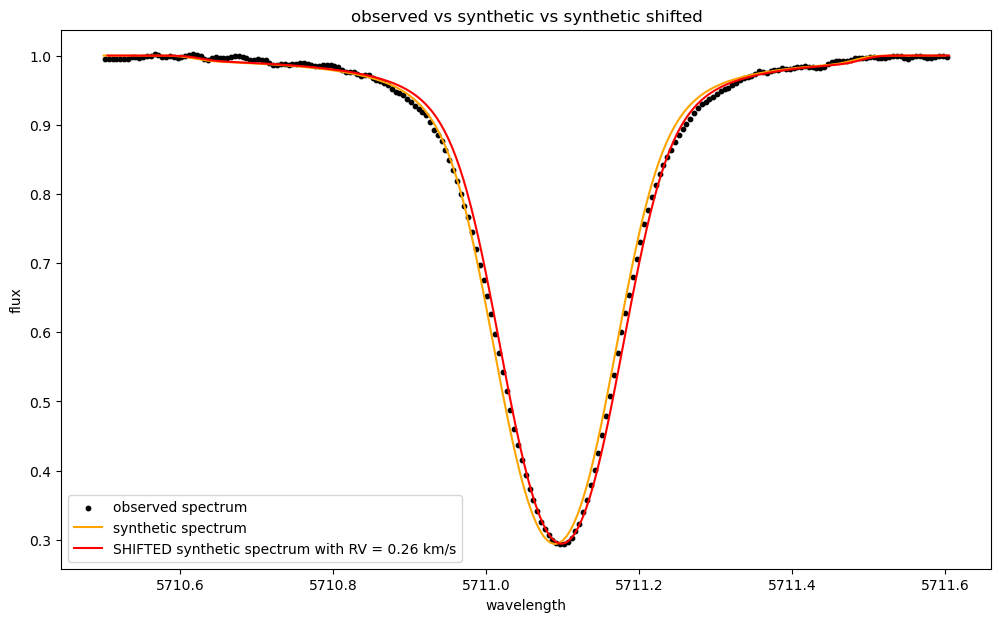

LOWEST CHI2: Mg abundance: 0.11 with chi2=0.018467190590992097
Mg abundance: -1.0, chi2: 6.546049442646654
Mg abundance: -0.99, chi2: 6.461962314742892
Mg abundance: -0.98, chi2: 6.378542814558971
Mg abundance: -0.97, chi2: 6.2942856207202285
Mg abundance: -0.96, chi2: 6.210313455545356
Mg abundance: -0.95, chi2: 6.126414896216502
Mg abundance: -0.94, chi2: 6.042933555157398
Mg abundance: -0.93, chi2: 5.958783468353555
Mg abundance: -0.92, chi2: 5.8754451396012275
Mg abundance: -0.91, chi2: 5.791912699578637
Mg abundance: -0.9, chi2: 5.708470064391273
Mg abundance: -0.89, chi2: 5.624687078950334
Mg abundance: -0.88, chi2: 5.541739682706907
Mg abundance: -0.87, chi2: 5.458402465493165
Mg abundance: -0.86, chi2: 5.3758185409036185
Mg abundance: -0.85, chi2: 5.29266065894501
Mg abundance: -0.84, chi2: 5.210343337790801
Mg abundance: -0.83, chi2: 5.128338175608491
Mg abundance: -0.82, chi2: 5.0459886526430235
Mg abundance: -0.81, chi2: 4.9636716472811875
Mg abundance: -0.8, chi2: 4.8822907

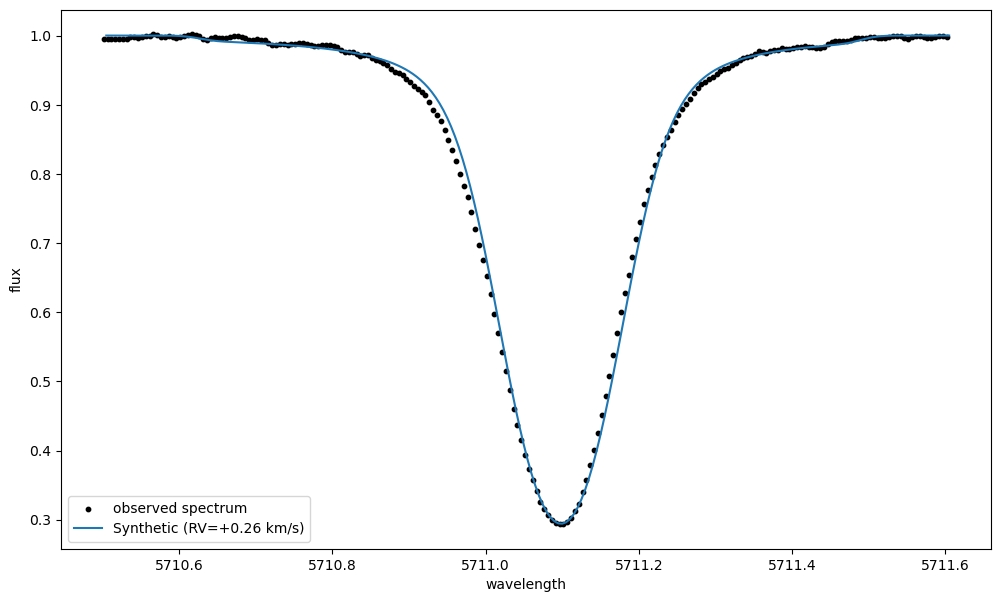

In [413]:
mask = (w_obs_wasp47 >= 5710.5) & (w_obs_wasp47 <= 5711.605)
w_obs_wasp47_cut = w_obs_wasp47[mask]
f_obs_wasp47_cut = f_obs_wasp47[mask]

best_rv_wasp47, best_chi2_wasp47 = rv_shift(rv_range, w_syn_wasp47, f_syn_wasp47, w_obs_wasp47_cut, f_obs_wasp47_cut)

#avg abundance
abundances1 = np.append(abundances, 0.415)
abundances1 = np.sort(abundances1)
w_syn_wasp47_rv, f_syn_wasp47_rv, best_chi2_wasp47_rv, best_abund_wasp47_rv = synth_compare_with_rv_shift("WASP-47_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_wasp47,f_obs_wasp47,"r",vsini_wasp47,limb_wasp47, vmac_wasp47, best_rv_wasp47)

##### hd806

In [ ]:
vsini_hd806 = #NO ROTATIONAL VELOCITY IN SIMBAD
vmac_hd806 = 
limb_hd806 =

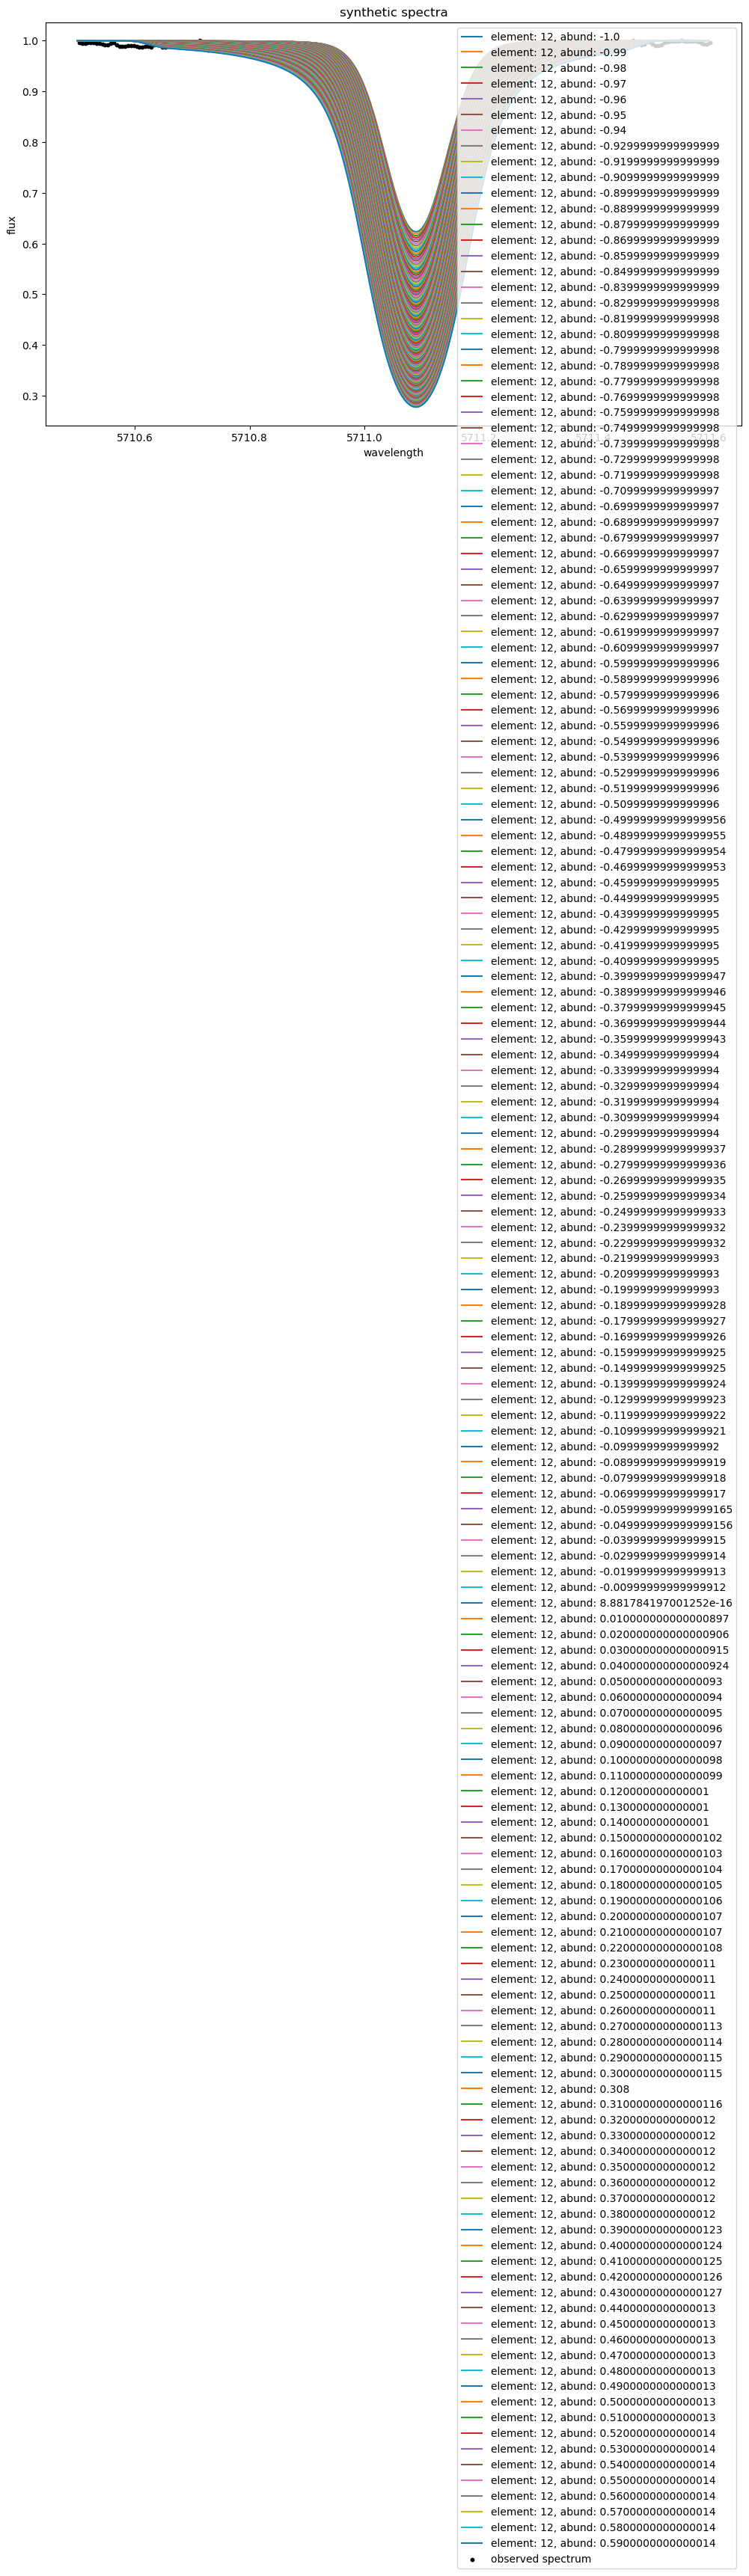

LOWEST CHI2: Mg abundance: -0.13999999999999924 with chi2=0.3673243784351805
Mg abundance: -1.0, chi2: 4.4324228981559255
Mg abundance: -0.99, chi2: 4.361065282817634
Mg abundance: -0.98, chi2: 4.2896457058498
Mg abundance: -0.97, chi2: 4.217873818275603
Mg abundance: -0.96, chi2: 4.146495942009025
Mg abundance: -0.95, chi2: 4.074809912377992
Mg abundance: -0.94, chi2: 4.003105324772665
Mg abundance: -0.9299999999999999, chi2: 3.9320273263119665
Mg abundance: -0.9199999999999999, chi2: 3.8607643187961753
Mg abundance: -0.9099999999999999, chi2: 3.7893822978191136
Mg abundance: -0.8999999999999999, chi2: 3.7184330230529135
Mg abundance: -0.8899999999999999, chi2: 3.6474075493207847
Mg abundance: -0.8799999999999999, chi2: 3.576682077390603
Mg abundance: -0.8699999999999999, chi2: 3.50649508198559
Mg abundance: -0.8599999999999999, chi2: 3.4361593951090086
Mg abundance: -0.8499999999999999, chi2: 3.366232056578476
Mg abundance: -0.8399999999999999, chi2: 3.2964317299551684
Mg abundance: 

In [ ]:
#avg abundance
abundances1 = np.append(abundances, 0.308)
abundances1 = np.sort(abundances1)
w_syn_hd806, f_syn_hd806, best_chi2_hd806, best_abund_hd806 = synth_compare("HD80653_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd806,f_obs_hd806,"r",vsini_hd806,limb_hd806, vmac_hd806)

##### hd 137

In [ ]:
vsini_hd137 = # NO ROTATIONAL VELOCITY IN SIMBAD
vmac_hd137 = vmac[6]
limb_hd137 = 0.63

In [243]:
#avg abundance
abundances1 = np.append(abundances, 0.008)
abundances1 = np.sort(abundances1)
w_syn_hd137, f_syn_hd137, best_chi2_hd137, best_abund_hd137 = synth_compare("HD137496_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd137,f_obs_hd137,"r",vsini_hd137,limb_hd137, vmac_hd137)

KeyboardInterrupt: 

##### hd203

In [ ]:
vsini_hd203 = # NO ROTATIONAL VELOCITY IN SIMBAD
vmac_hd203 = 
limb_hd203 = 

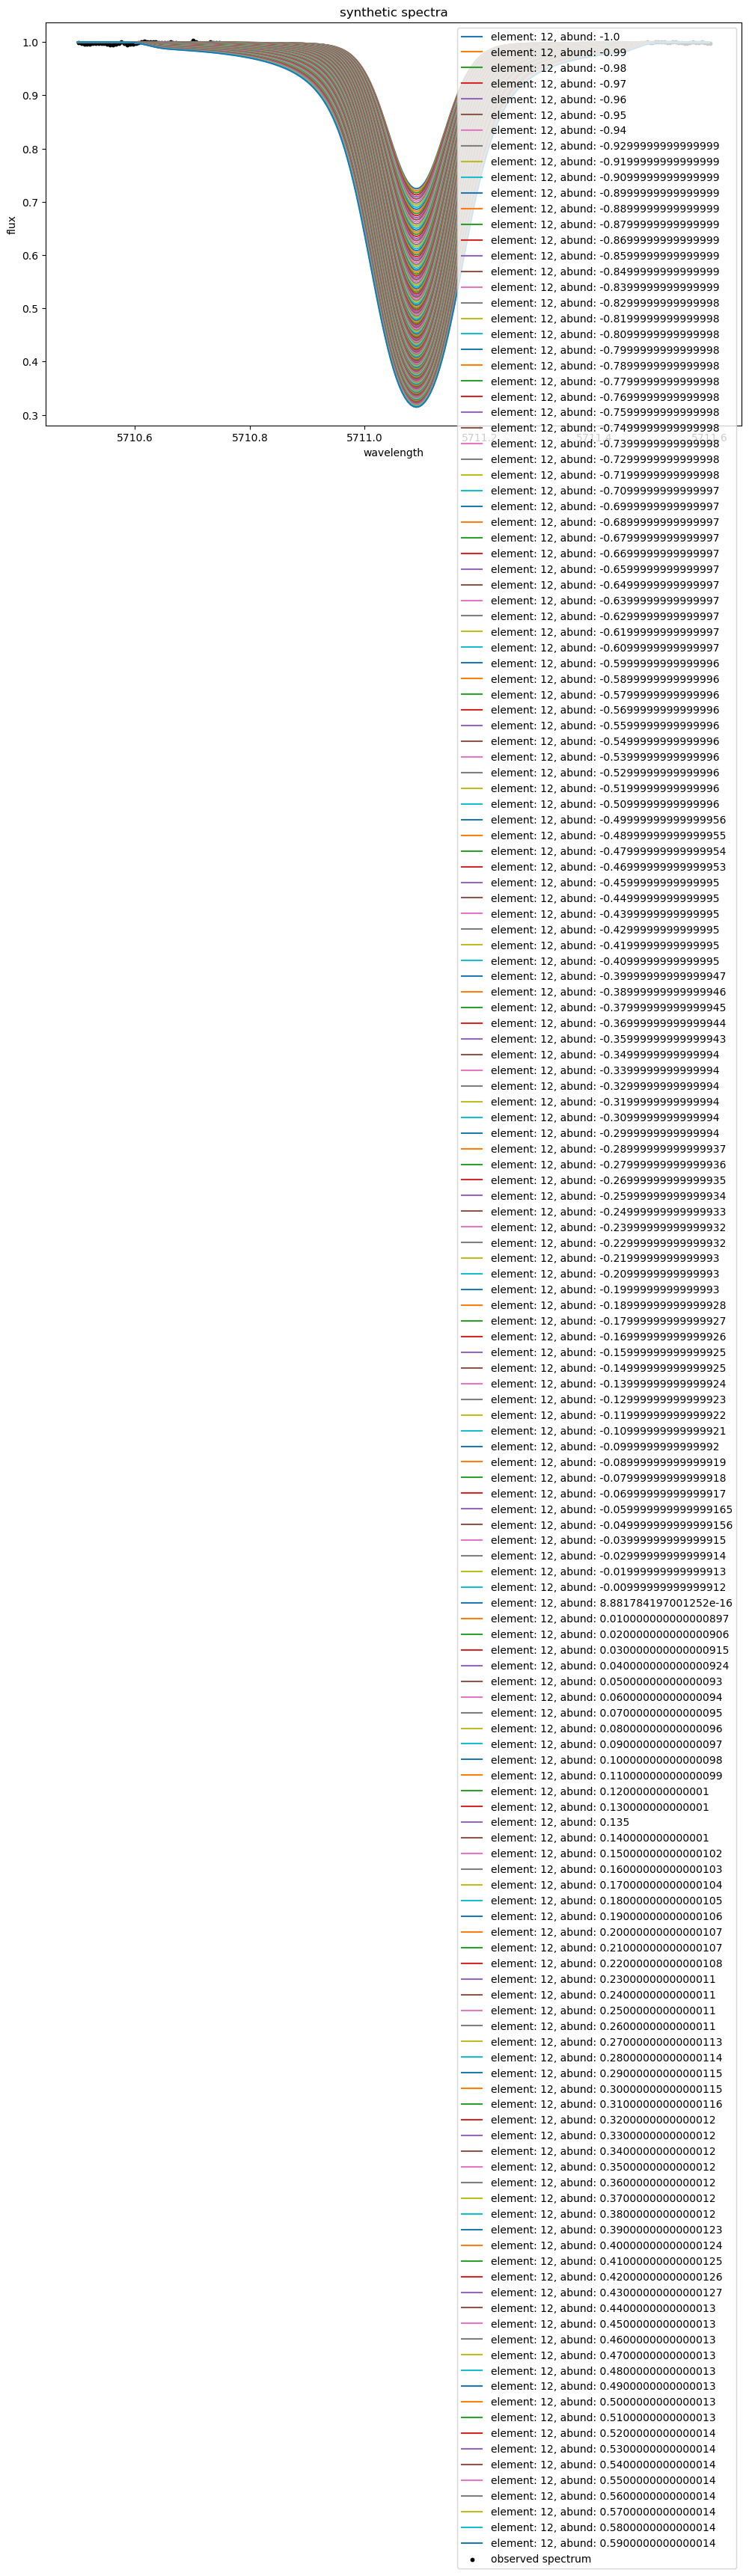

LOWEST CHI2: Mg abundance: 0.3400000000000012 with chi2=0.05402171725695114
Mg abundance: -1.0, chi2: 7.5377288130899744
Mg abundance: -0.99, chi2: 7.475938853619429
Mg abundance: -0.98, chi2: 7.413142995207625
Mg abundance: -0.97, chi2: 7.35007826643101
Mg abundance: -0.96, chi2: 7.28644677814046
Mg abundance: -0.95, chi2: 7.222171665654521
Mg abundance: -0.94, chi2: 7.156954675592263
Mg abundance: -0.9299999999999999, chi2: 7.09145745217643
Mg abundance: -0.9199999999999999, chi2: 7.0255044364538435
Mg abundance: -0.9099999999999999, chi2: 6.958766758201114
Mg abundance: -0.8999999999999999, chi2: 6.891707538210561
Mg abundance: -0.8899999999999999, chi2: 6.823922280749113
Mg abundance: -0.8799999999999999, chi2: 6.755661461538132
Mg abundance: -0.8699999999999999, chi2: 6.687085575269755
Mg abundance: -0.8599999999999999, chi2: 6.617932493024289
Mg abundance: -0.8499999999999999, chi2: 6.548256379594995
Mg abundance: -0.8399999999999999, chi2: 6.478684800066857
Mg abundance: -0.8299

In [ ]:
#avg abundance
abundances1 = np.append(abundances, 0.135)
abundances1 = np.sort(abundances1)
w_syn_hd203, f_syn_hd203, best_chi2_hd203, best_abund_hd203 = synth_compare("HD20329_ESPRESSO_2024_orig.atm",abundances1,5710.5,5711.605,0.005,w_obs_hd203,f_obs_hd203,"r",vsini_hd203,limb_hd203, vmac_hd203)

#### all results

In [257]:
best_abund_hd137 = 0
best_chi2_hd137 = 0

best_abund_hd203 = 0
best_chi2_hd203 = 0

best_abund_hd806 = 0
best_chi2_hd806 = 0

best_abund_toi238 = 0
best_chi2_toi238 = 0

In [259]:
best_abund_by_synth = [best_abund_55Cnc,best_abund_corot,best_abund_k2106,best_abund_k2314,best_abund_k2229,best_abund_hd136, best_abund_hd137,
                       best_abund_toi402,best_abund_hd203,best_abund_hd213,best_abund_hd3167,best_abund_hd806,best_abund_toi469,best_abund_k2111,
                       best_abund_k2131,best_abund_k2265,best_abund_hd285,best_abund_k238,best_abund_toi238,best_abund_toi561,best_abund_wasp47]
best_chi2_by_synth = [best_chi2_55cnc, best_chi2_corot, best_chi2_k2106, best_chi2_k2314, best_chi2_k2229, best_chi2_hd136, best_chi2_hd137,
                      best_chi2_toi402, best_chi2_hd203, best_chi2_hd213, best_chi2_hd3167, best_chi2_hd806, best_chi2_toi469, best_chi2_k2111, 
                      best_chi2_k2131, best_chi2_k2265, best_chi2_hd285, best_chi2_k238, best_chi2_toi238, best_chi2_toi561, best_chi2_wasp47]
mg_ew = sample["MgI_rel_sun"]


In [414]:
best_abund_hd137_rv = 0
best_chi2_hd137_rv = 0

best_abund_hd203_rv = 0
best_chi2_hd203_rv = 0

best_abund_hd806_rv = 0
best_chi2_hd806_rv = 0

best_abund_toi238_rv = 0
best_chi2_toi238_rv = 0


In [415]:
best_abund_by_synth_rv = [best_abund_55Cnc_rv, best_abund_corot_rv, best_abund_k2106_rv, best_abund_k2314_rv, best_abund_k2229_rv, best_abund_hd136_rv, best_abund_hd137_rv,
                       best_abund_toi402_rv, best_abund_hd203_rv, best_abund_hd213_rv, best_abund_hd3167_rv, best_abund_hd806_rv, best_abund_toi469_rv, best_abund_k2111_rv,
                       best_abund_k2131_rv, best_abund_k2265_rv, best_abund_hd285_rv, best_abund_k238_rv, best_abund_toi238_rv, best_abund_toi561_rv, best_abund_wasp47_rv]

best_chi2_by_synth_rv = [best_chi2_55cnc_rv, best_chi2_corot_rv, best_chi2_k2106_rv, best_chi2_k2314_rv, best_chi2_k2229_rv, best_chi2_hd136_rv, best_chi2_hd137_rv,
                      best_chi2_toi402_rv, best_chi2_hd203_rv, best_chi2_hd213_rv, best_chi2_hd3167_rv, best_chi2_hd806_rv, best_chi2_toi469_rv, best_chi2_k2111_rv, 
                      best_chi2_k2131_rv, best_chi2_k2265_rv, best_chi2_hd285_rv, best_chi2_k238_rv, best_chi2_toi238_rv, best_chi2_toi561_rv, best_chi2_wasp47_rv]


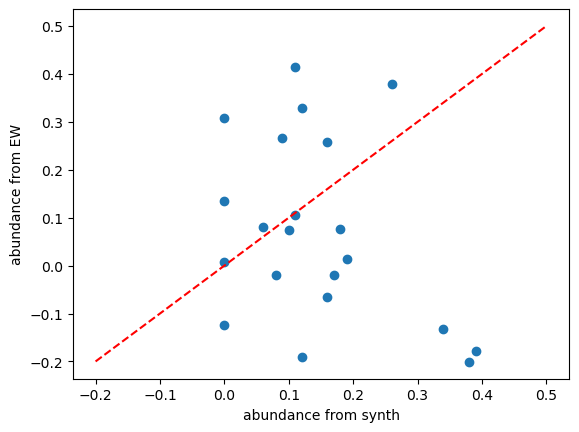

In [260]:
plt.scatter(best_abund_by_synth,mg_ew)
x=np.linspace(-0.2,0.5,10)
plt.plot(x,x,color="r",linestyle="--")
plt.xlabel("abundance from synth")
plt.ylabel("abundance from EW")
plt.show()


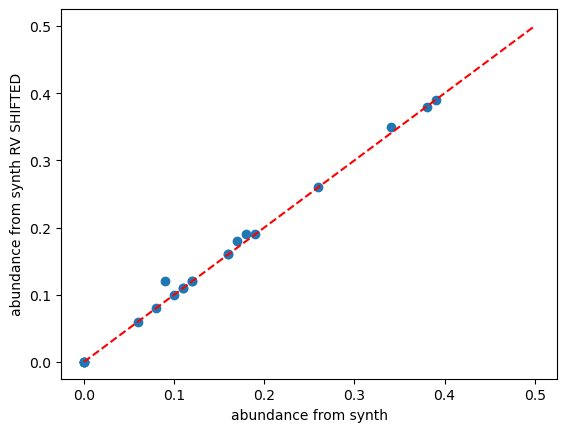

In [422]:
plt.scatter(best_abund_by_synth,best_abund_by_synth_rv)

x=np.linspace(0,0.5,10)
plt.plot(x,x,color="r",linestyle="--")

plt.xlabel("abundance from synth")
plt.ylabel("abundance from synth RV SHIFTED")
plt.show()

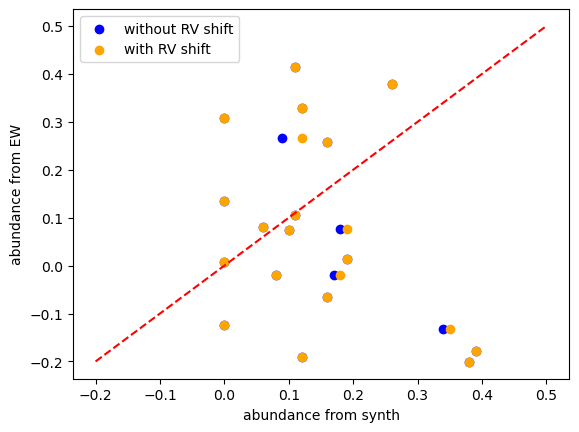

In [425]:
plt.scatter(best_abund_by_synth,mg_ew, color="b",label="without RV shift")
plt.scatter(best_abund_by_synth_rv,mg_ew, color="orange",label="with RV shift")
x=np.linspace(-0.2,0.5,10)
plt.plot(x,x,color="r",linestyle="--")
plt.xlabel("abundance from synth")
plt.ylabel("abundance from EW")
plt.legend()
plt.show()

In [426]:
star_names = sample["star"]

Text(0.5, 0, 'difference between abundances of synth and EW method')

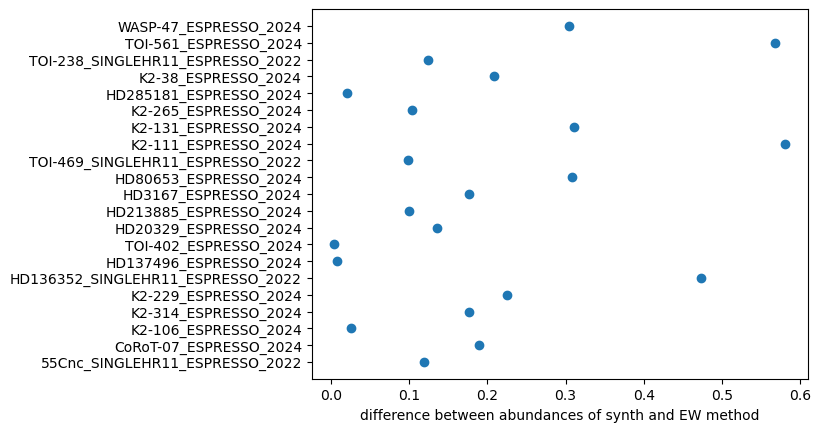

In [427]:
plt.scatter(np.abs(best_abund_by_synth-sample["MgI_rel_sun"]),sample["star"])

plt.xlabel("difference between abundances of synth and EW method")

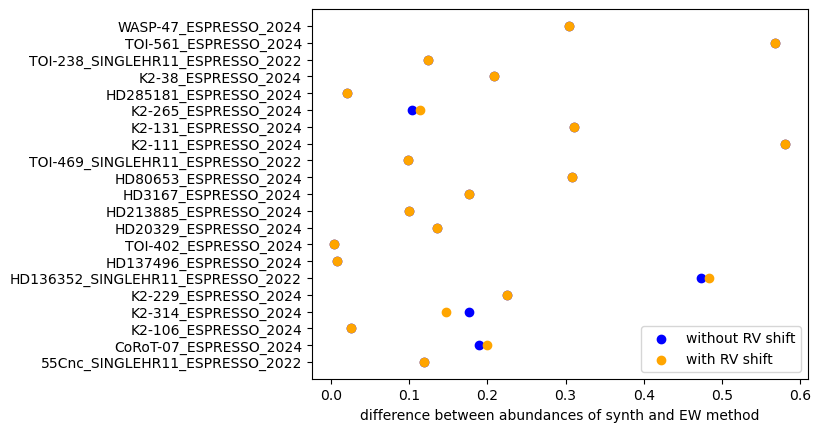

In [430]:
plt.scatter(np.abs(best_abund_by_synth-sample["MgI_rel_sun"]),sample["star"],color="b",label="without RV shift")
plt.scatter(np.abs(best_abund_by_synth_rv-sample["MgI_rel_sun"]),sample["star"],color="orange",label="with RV shift")

plt.xlabel("difference between abundances of synth and EW method")
plt.legend()

In [262]:
np.abs(best_abund_by_synth-sample["MgI_rel_sun"]) < 0.2

0      True
1      True
2      True
3      True
4     False
5     False
6      True
7      True
8      True
9      True
10     True
11    False
12     True
13    False
14    False
15     True
16     True
17    False
18     True
19    False
20    False
Name: MgI_rel_sun, dtype: bool

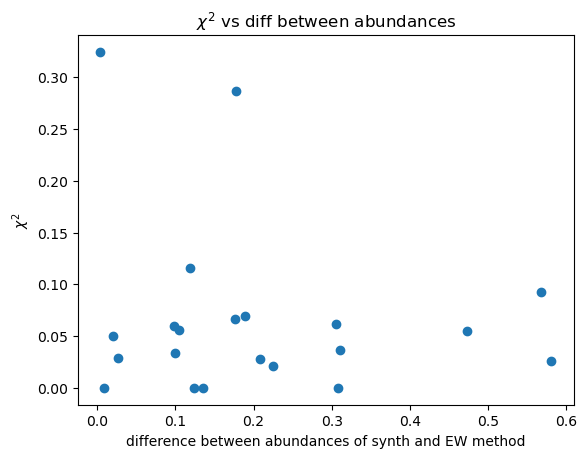

In [437]:
plt.scatter(np.abs(best_abund_by_synth-sample["MgI_rel_sun"]),best_chi2_by_synth)

plt.xlabel("difference between abundances of synth and EW method")
plt.ylabel(r"$\chi^{2}$") 
plt.title(r"$\chi^{2}$ vs diff between abundances")
plt.show()

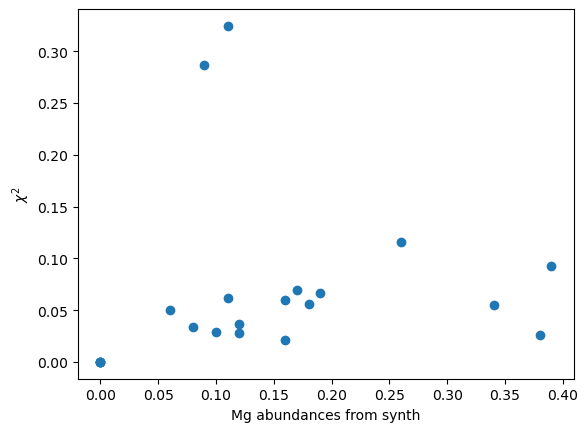

In [432]:
plt.scatter(best_abund_by_synth,best_chi2_by_synth)
plt.xlabel("Mg abundances from synth")
plt.ylabel(r"$\chi^{2}$") 
plt.show()

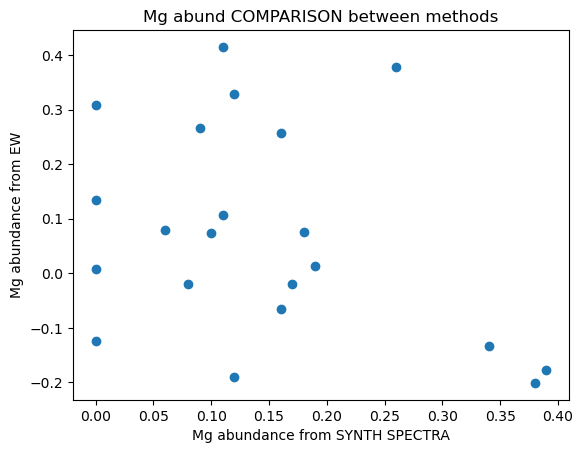

In [436]:
plt.scatter(best_abund_by_synth, mg_ew)
plt.xlabel("Mg abundance from SYNTH SPECTRA")
plt.ylabel("Mg abundance from EW")
plt.title("Mg abund COMPARISON between methods")
plt.show()

In [ ]:

stars = ["55cnc", "corot", "k2106", "k2314", "k2229", "hd136", "toi402", "hd213", "hd3167"]

stars_data = {
    star: {
        "obs_wavelength": globals().get(f"w_syn_{star}", []),
        "obs_flux_normalized": globals().get(f"f_syn_{star}", [])
    }
    for star in stars
}

df = pd.DataFrame.from_dict(
    {star: [data["obs_wavelength"], data["obs_flux_normalized"]] for star, data in stars_data.items()},
    orient="index",
    columns=["obs_wavelength", "obs_flux_normalized"]
)

print(df)

df.to_csv("normalized_spectra_table.csv")




                                           obs_wavelength  \
55cnc   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
corot   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
k2106   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
k2314   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
k2229   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
hd136   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
toi402  [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
hd213   [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   
hd3167  [5710.5, 5710.505, 5710.51, 5710.515, 5710.52,...   

                                      obs_flux_normalized  
55cnc   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
corot   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
k2106   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
k2314   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
k2229   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
hd136   [1.0, 1.0, 1.0, 1.0, 

## new parameters

In [23]:
from synth_spectra import vmac

In [25]:
vmac = vmac(sample["teff"],sample["logg"])

0     3.030078
1     2.675728
2     2.936368
3     3.631968
4     2.768302
5     3.091750
6     3.950800
7     3.063200
8     3.135518
9     3.565982
10    2.860102
11    3.890752
12    2.969888
13    3.430592
14    2.935312
15    2.840000
16    2.804558
17    3.445902
18    3.046432
19    2.675662
20    3.081750
dtype: float64


Text(0, 0.5, 'vmac')

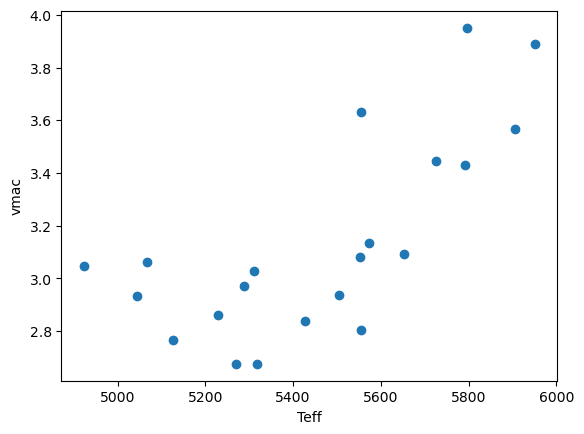

In [26]:
plt.scatter(sample["teff"],vmac)
plt.xlabel("Teff")
plt.ylabel("vmac")

In [31]:
#FWHM of marcoturbulenct function
#fwhm = rest_wavelength * (marcoturbulence / c) * 2.355 from fwhm formula for gaussian profile

c = 299792 #km/s
fwhm = []
for i in range(len(vmac)):
    fwhm_i = 5711.09 * (vmac[i] / c) * 2.355
    fwhm.append(fwhm_i)

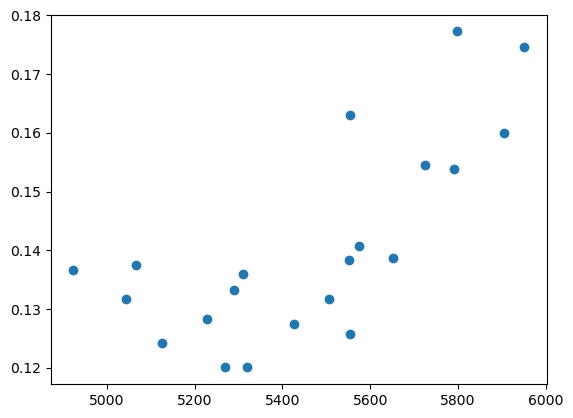

In [32]:
plt.scatter(sample["teff"],fwhm)

In [35]:
sample["star"]

0        55Cnc_SINGLEHR11_ESPRESSO_2022
1                CoRoT-07_ESPRESSO_2024
2                  K2-106_ESPRESSO_2024
3                  K2-314_ESPRESSO_2024
4                  K2-229_ESPRESSO_2024
5     HD136352_SINGLEHR11_ESPRESSO_2022
6                HD137496_ESPRESSO_2024
7                 TOI-402_ESPRESSO_2024
8                 HD20329_ESPRESSO_2024
9                HD213885_ESPRESSO_2024
10                 HD3167_ESPRESSO_2024
11                HD80653_ESPRESSO_2024
12     TOI-469_SINGLEHR11_ESPRESSO_2022
13                 K2-111_ESPRESSO_2024
14                 K2-131_ESPRESSO_2024
15                 K2-265_ESPRESSO_2024
16               HD285181_ESPRESSO_2024
17                  K2-38_ESPRESSO_2024
18     TOI-238_SINGLEHR11_ESPRESSO_2022
19                TOI-561_ESPRESSO_2024
20                WASP-47_ESPRESSO_2024
Name: star, dtype: object

## big function for all

In [ ]:

files = [
    ("55Cnc_SINGLEHR11_ESPRESSO_2022_orig.atm", "spectra/55Cnc_SINGLEHR11_ESPRESSO_2022.fits"),
    ("CoRoT-07_ESPRESSO_2024_orig.atm", "spectra/CoRoT-07_ESPRESSO_2024.fits"),
    ("K2-106_ESPRESSO_2024_orig.atm","spectra/K2-106_ESPRESSO_2024_c.fits"),
    ("K2-314_ESPRESSO_2024_orig.atm","spectra/K2-314_ESPRESSO_2024.fits"),
    ("K2-229_ESPRESSO_2024_orig.atm","spectra/K2-229_ESPRESSO_2024.fits"),
    ("HD136352_SINGLEHR11_ESPRESSO_2022_orig.atm","spectra/HD136352_SINGLEHR11_ESPRESSO_2022.fits"),
    ("HD137496_ESPRESSO_2024_orig.atm","spectra/HD137496_ESPRESSO_2024_c.fits"),
    ("TOI-402_ESPRESSO_2024_orig.atm","spectra/TOI-402_ESPRESSO_2024.fits"),
    ("HD20329_ESPRESSO_2024_orig.atm","spectra/HD20329_ESPRESSO_2024.fits"),
    ("HD213885_ESPRESSO_2024_orig.atm","spectra/HD213885_ESPRESSO_2024.fits"),
    ("HD3167_ESPRESSO_2024_orig.atm", "spectra/HD3167_ESPRESSO_2024.fits"),
    ("HD80653_ESPRESSO_2024_orig.atm","spectra/HD80653_ESPRESSO_2024_c.fits"),
    ("TOI-469_SINGLEHR11_ESPRESSO_2022_orig.atm","spectra/TOI-469_SINGLEHR11_ESPRESSO_2024.fits"),
    ("K2-111_ESPRESSO_2024_orig.atm","spectra/K2-111_ESPRESSO_2024.fits"),
    ("K2-131_ESPRESSO_2024_orig.atm","spectra/K2-131_ESPRESSO_2024_c.fits"),
    ("K2-265_ESPRESSO_2024_orig.atm","spectra/K2-265_ESPRESSO_2024.fits"),
    ("HD285181_ESPRESSO_2024_orig.atm","spectra/HD285181_ESPRESSO_2024_c.fits"),
    ("K2-38_ESPRESSO_2024_orig.atm","spectra/K2-38_ESPRESSO_2024.fits"),
    ("TOI-238_SINGLEHR11_ESPRESSO_2022_orig.atm","spectra/TOI-238_SINGLEHR11_ESPRESSO_2022.fits"),
    ("TOI-561_ESPRESSO_2024_orig.atm","spectra/TOI-561_ESPRESSO_2024_c.fits"),
    ("WASP-47_ESPRESSO_2024_orig.atm","spectra/WASP-47_ESPRESSO_2024.fits")
]

abundances1 = [-0.5, 0, 0.5] + list(sample["MgI_rel_sun"])

mgI_values = list(sample["MgI_rel_sun"])

w_obs_all = []
f_obs_all = []
w_syn_all = []
f_syn_all = []
best_chi2_all = []
best_abund_all = []

for i, (atmosphere, fits) in enumerate(files):
    star_name = os.path.basename(atmosphere).split('_')[0]
    
    abundances1 = [-0.5, 0, 0.5, mgI_values[i]]
   
    w_obs, f_obs, w_syn, f_syn, best_chi2, best_abund = synth_compare(atmosphere, abundances1, 5710, 5712.005, 0.005, fits)
    
    w_obs_all.append(w_obs)
    f_obs_all.append(f_obs)
    w_syn_all.append(w_syn)
    f_syn_all.append(f_syn)
    best_chi2_all.append(best_chi2)
    best_abund_all.append(best_abund)
    
    globals()[f"w_obs_{star_name}"] = w_obs
    globals()[f"f_obs_{star_name}"] = f_obs
    globals()[f"w_syn_{star_name}"] = w_syn
    globals()[f"f_syn_{star_name}"] = f_syn
    globals()[f"best_chi2_{star_name}"] = best_chi2
    globals()[f"best_abund_{star_name}"] = best_abund
    
    print(f"Processed {star_name}: best_abund={best_abund}, best_chi2={best_chi2}")

NameError: name 'sample' is not defined